In [1]:
### load modules 
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re 
import pickle
import pingouin as pg
from itertools import groupby
from operator import itemgetter
from patsy import dmatrices
import statsmodels.formula.api as smf
import statsmodels.discrete.discrete_model as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

### load my scripts 
import data_combiner as dc
import plotting_funcs as pf
import sim as sim


plt.rcParams["figure.figsize"] = (20,10)
sns.set_context('talk',font_scale=2)
plt.rcParams["lines.linewidth"] = 3

plt.rcParams['font.size'] = 15
plt.rcParams['font.family'] = 'Verdana'

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
curr_round = 'round_1'
all_filenames = glob.glob("../../experiment1k/run_exp/data/*.csv")

In [3]:
all_data = dc.clean_data_group(all_filenames).reset_index(drop=True)
num_subs = len(list(set(all_data['sub_num'])))
all_data['prt_rel_mvt'] = all_data['prt'] - all_data['opt_prt']
all_data['prt_rel_om'] = all_data['prt'] - all_data['opt_prt_om']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198


In [38]:
all_data.query("sub_num==70 & planet==31").reward_list

3908    [99.0, 45.0, 20.0, 11.0, 5.0]
Name: reward_list, dtype: object

In [206]:
all_sub_num = []
all_block = []
all_true_planet = []
all_planet = []
all_galaxy = []
all_stay_num = []
all_reward = []
all_planet_in_block = []

for sub_num in range(198):
    sub_data = all_data.query("sub_num=="+str(sub_num))
    for b in range(1,6):
        block_data = sub_data.query("block=="+str(b))
        block_planets = block_data.planet
        planet_in_block = 0
        for planet in block_planets:
            planet_data = block_data.query("planet=="+str(planet))
            planet_reward = planet_data.reset_index().reward_list[0]
            true_planet = planet_data.reset_index().true_planet[0]
            galaxy = planet_data.reset_index().galaxy[0]
            stay_num = 0
            for reward in planet_reward:
                all_sub_num += [sub_num]
                all_block += [b]
                all_true_planet += [true_planet]
                all_planet += [planet]
                all_galaxy += [galaxy]
                all_stay_num += [stay_num]
                all_reward += [reward]
                all_planet_in_block += [planet_in_block]
                stay_num += 1
            planet_in_block += 1

temp = pd.DataFrame({'sub_num':all_sub_num,'block':all_block,'true_planet':all_true_planet,
                     'planet':all_planet,'galaxy':all_galaxy,'stay_num':all_stay_num,'reward':all_reward,
                    'planet_in_block':all_planet_in_block})
temp.to_csv("all_data_dataset_2022.csv")

In [82]:
avgd_data = all_data.groupby(by=['sub_num','galaxy']).mean().reset_index()
avgd_data.to_csv("ref_point_galaxy_dataset_2022_newOpt.csv")

all_data = all_data.astype({'galaxy':'int32'})
avgd_data = all_data.groupby(by=['sub_num','true_planet']).mean().reset_index()
avgd_data.loc[:,['sub_num','true_planet','galaxy','prt']].to_csv("ref_point_data_planet_by_planet_dataset_2022.csv")

In [4]:
avgd_data = all_data.groupby(by=['sub_num']).mean().reset_index()
mean = np.mean(avgd_data.prt)
sd = stats.tstd(avgd_data.prt)

print("low bound: " + str(mean - 2.0*sd))
print("upp bound: " + str(mean + 2.0*sd))

low bound: -0.8771113468978378
upp bound: 9.764851647876863


In [5]:
subs_to_drop = list(set(all_data.query("catch_perf != 2 ").sub_num))

x=avgd_data.prt < 1.5 # 24,39
ind=np.where(x==True)[0]
subs_to_drop += avgd_data.iloc[ind,:].sub_num.to_list()

x=avgd_data.prt > mean + 2.0*sd
ind=np.where(x==True)[0]
subs_to_drop += avgd_data.iloc[ind,:].sub_num.to_list()

x= avgd_data.n_prac > 2
ind=np.where(x==True)[0]
subs_to_drop +=avgd_data.iloc[ind,:].sub_num.to_list()

all_data = all_data[~all_data['sub_num'].isin(subs_to_drop)]

In [81]:
np.sort(all_data.groupby(by=['sub_num']).mean().prt_rel_om)

array([-3.25842697, -3.25581395, -3.20930233, -3.01176471, -3.        ,
       -2.98765432, -2.88607595, -2.8045977 , -2.76712329, -2.48101266,
       -1.98780488, -1.97402597, -1.8875    , -1.54411765, -1.25333333,
       -0.97260274, -0.88571429, -0.82608696, -0.71641791, -0.625     ,
       -0.4057971 , -0.4057971 , -0.39130435, -0.38235294, -0.26153846,
       -0.13235294, -0.11940299, -0.03076923, -0.03030303,  0.01538462,
        0.01587302,  0.03076923,  0.06060606,  0.09090909,  0.09230769,
        0.12307692,  0.15384615,  0.15625   ,  0.21875   ,  0.21875   ,
        0.24615385,  0.28571429,  0.32258065,  0.32307692,  0.33870968,
        0.37704918,  0.38095238,  0.42857143,  0.44444444,  0.48387097,
        0.48387097,  0.49180328,  0.51612903,  0.51612903,  0.54098361,
        0.59016393,  0.59677419,  0.61016949,  0.63333333,  0.68333333,
        0.68852459,  0.7       ,  0.71666667,  0.72131148,  0.76666667,
        0.7704918 ,  0.78688525,  0.83333333,  0.91525424,  0.93

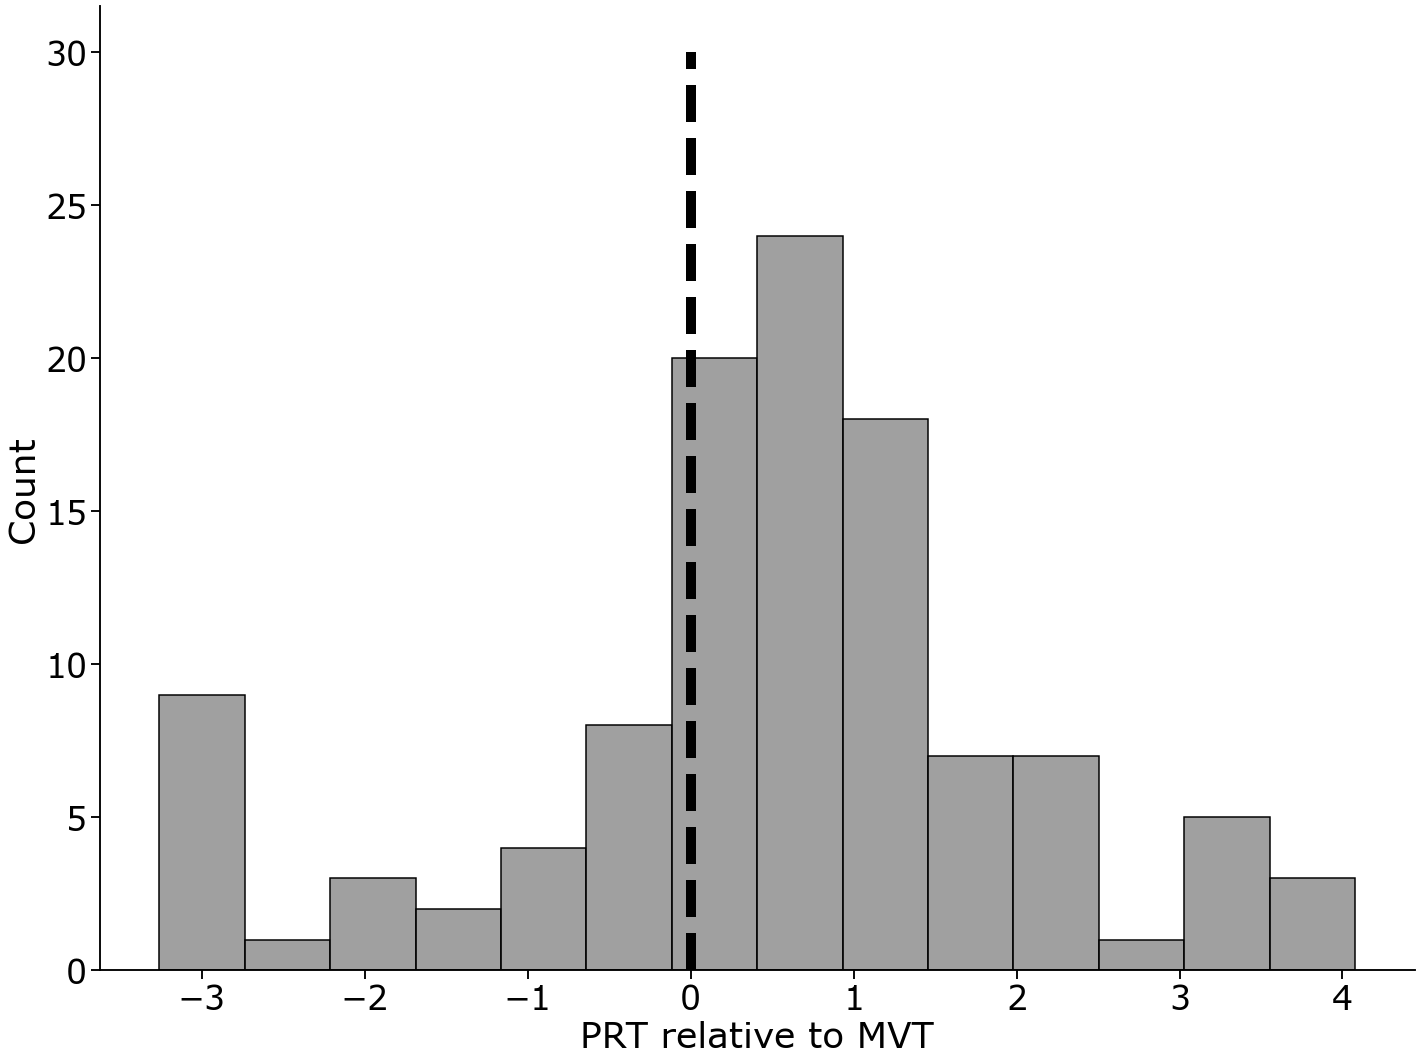

In [66]:
avgd_data = all_data.groupby(by=['sub_num']).mean().reset_index()
plt.rcParams["figure.figsize"] = (20,15)

sns.histplot(x='prt_rel_om',color='grey',data=avgd_data)
sns.despine(top=True,right=True)
plt.xlabel('PRT relative to MVT')
plt.plot([0,0],[0,30],'k--',linewidth=10)
plt.tight_layout()

plt.savefig('plots/avg_over_gal_indiv_sub.png')

In [67]:
stats.ttest_1samp(avgd_data.prt_rel_om,popmean=0)

Ttest_1sampResult(statistic=3.1999067356066013, pvalue=0.0017926373902848243)

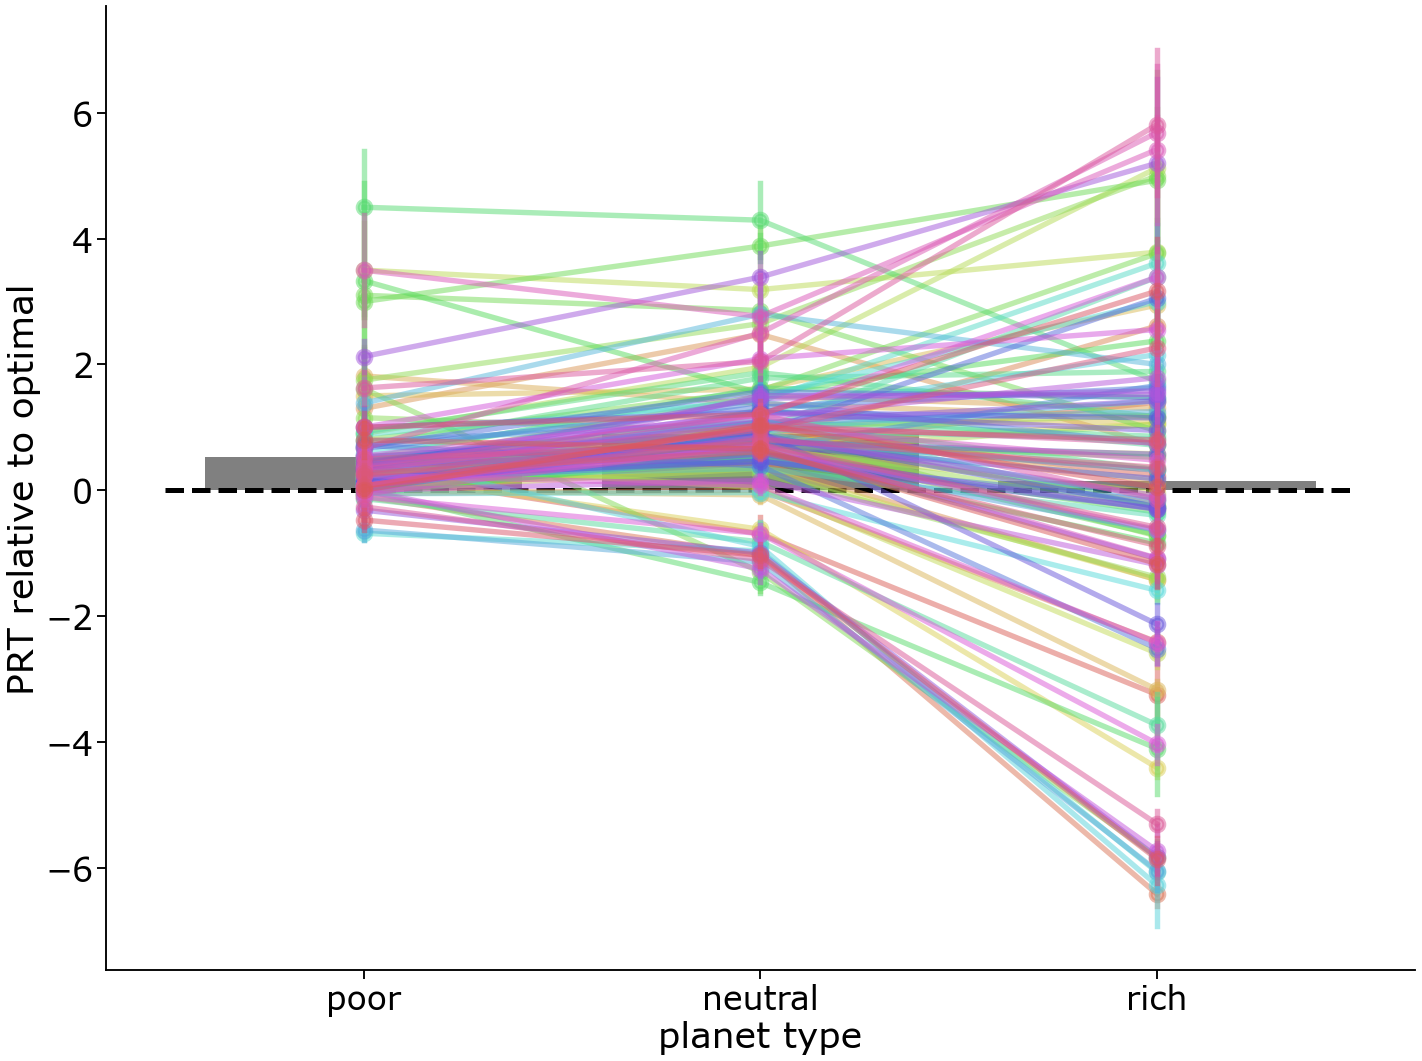

In [68]:
plt.rcParams["figure.figsize"] = (20,15)
avgd_data = all_data.groupby(by=['sub_num','galaxy']).mean().reset_index()

fig, ax = plt.subplots()
sns.barplot(x='galaxy',y='prt_rel_om',ci=68,color='grey',data=avgd_data,ax=ax)

g=sns.pointplot(x='galaxy',y='prt_rel_om',hue='sub_num',ci=68,palette='hls',data=all_data.query("sub_num!='nan'"),ax=ax)

g.set_xticklabels(['poor','neutral','rich'])
g.set_ylabel('PRT relative to optimal')
g.set_xlabel('planet type')
sns.despine(top=True,right=True)
plt.setp(g.collections, alpha=.5) #for the markers
plt.setp(g.lines, alpha=.5)       #for the lines
g.get_legend().remove()
plt.plot([-0.5,2.5],[0,0],'k--', linewidth=5)


plt.tight_layout()
plt.savefig('plots/galaxy_sep_indiv_sub_2022.png')

In [6]:
avgd_data = all_data.groupby(by=['sub_num','galaxy']).mean().reset_index()
avgd_data.query("galaxy==0").prt_rel_om.mean()

0.6180013273146079

In [10]:
print(stats.ttest_ind(avgd_data.query('galaxy==2').prt,avgd_data.query('galaxy==1').prt))

print(stats.ttest_ind(avgd_data.query('galaxy==1').prt,avgd_data.query('galaxy==0').prt))


Ttest_indResult(statistic=12.072325618558853, pvalue=2.5695612044895662e-26)
Ttest_indResult(statistic=5.496286030102993, pvalue=1.0269619336944841e-07)


In [69]:
print(stats.ttest_1samp(avgd_data.query('galaxy==0').prt_rel_om,popmean=0))
print(stats.ttest_1samp(avgd_data.query('galaxy==1').prt_rel_om,popmean=0))
print(stats.ttest_1samp(avgd_data.query('galaxy==2').prt_rel_om,popmean=0))

Ttest_1sampResult(statistic=6.56095081488452, pvalue=1.7642688089255716e-09)
Ttest_1sampResult(statistic=8.99347124004096, pvalue=7.374355718867176e-15)
Ttest_1sampResult(statistic=0.5360887750102497, pvalue=0.5929698705198403)


In [164]:
g=sns.catplot(x='galaxy',y='prt_rel_om',hue='sub_num',col='diff_prt',ci=68,palette='hls',kind='point',data=all_data.query("sub_num!='nan'"),ax=ax)
g.set_xticklabels(['poor','neutral','rich'])
g.set_ylabels('PRT relative to optimal')
g.set_xlabels('planet type')
sns.despine(top=True,right=True)
plt.setp(g.collections, alpha=.5) #for the markers
plt.setp(g.lines, alpha=.5)       #for the lines
g.get_legend().remove()
plt.plot([-0.5,2.5],[0,0],'k--')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)


KeyError: 'diff_prt'

In [49]:
print('poor')
print('mean')
print(avgd_data.query('galaxy==0')['prt_rel_om'].mean())
print('sd')
print(stats.tstd(avgd_data.query('galaxy==0')['prt_rel_om']))
print(stats.ttest_1samp(avgd_data.query('galaxy==0')['prt_rel_om'],popmean=0))

print('')
print('neutral')
print('mean')
print(avgd_data.query('galaxy==1')['prt_rel_om'].mean())
print('sd')
print(stats.tstd(avgd_data.query('galaxy==1')['prt_rel_om']))
print(stats.ttest_1samp(avgd_data.query('galaxy==1')['prt_rel_om'],popmean=0))

print('')
print('rich')
print('mean')
print(avgd_data.query('galaxy==2')['prt_rel_om'].mean())
print('sd')
print(stats.tstd(avgd_data.query('galaxy==2')['prt_rel_om']))
stats.ttest_1samp(avgd_data.query('galaxy==2')['prt_rel_om'],popmean=0)

poor
mean


UndefinedVariableError: name 'galaxy' is not defined

In [50]:
avgd_data.loc[:,['sub_num','galaxy','prt_rel_om']].to_csv("sub_galaxy_reference_point.csv")

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['galaxy'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [20]:
plt.rcParams["figure.figsize"] = (20,15)

g=sns.pointplot(x='galaxy',y='prt_rel_om',ci=68,color='grey',data=avgd_data.query("sub_num!='nan'"))
g.set_xticklabels(['poor','neutral','rich'])
g.set_ylabel('PRT rel Opt')

plt.tight_layout()
plt.savefig('plots/galaxy_sep_avg.png')

NameError: name 'avgd_data' is not defined

In [36]:
subs= np.unique(avgd_data.sub_num)
new_df = pd.DataFrame(columns=['sub_num','measure','diff_prt'])
for sub in subs:
    neutral_poor = avgd_data .query("sub_num=="+str(sub)+" & galaxy==1").reset_index().prt_rel_om[0] - avgd_data .query("sub_num=="+str(sub)+"& galaxy==0").reset_index().prt_rel_om[0]
    rich_neutral = avgd_data .query("sub_num=="+str(sub)+" & galaxy==2").reset_index().prt_rel_om[0] - avgd_data .query("sub_num=="+str(sub)+"& galaxy==1").reset_index().prt_rel_om[0]
    row = pd.DataFrame({'sub_num':[sub]*2,'measure':['neutral-poor','rich-neutral'],'diff_prt':[neutral_poor,rich_neutral]})
    
    new_df = pd.concat([new_df,row])
    

KeyError: 0

In [187]:
new_df

NameError: name 'new_df' is not defined

In [188]:
g=sns.pointplot(x='measure',y='PRT rel Opt - diff',hue='sub_num',palette='hls',ci=68,join=False,data=new_df.query("sub_num!='nan'"))
plt.setp(g.collections, alpha=.5) #for the markers
plt.setp(g.lines, alpha=.5)       #for the lines
plt.plot([0,1],[0,0],'k--')
g.get_legend().remove()
plt.xlabel('')
plt.tight_layout()
plt.savefig('plots/galaxy_diff_indiv_sub.png')

NameError: name 'new_df' is not defined

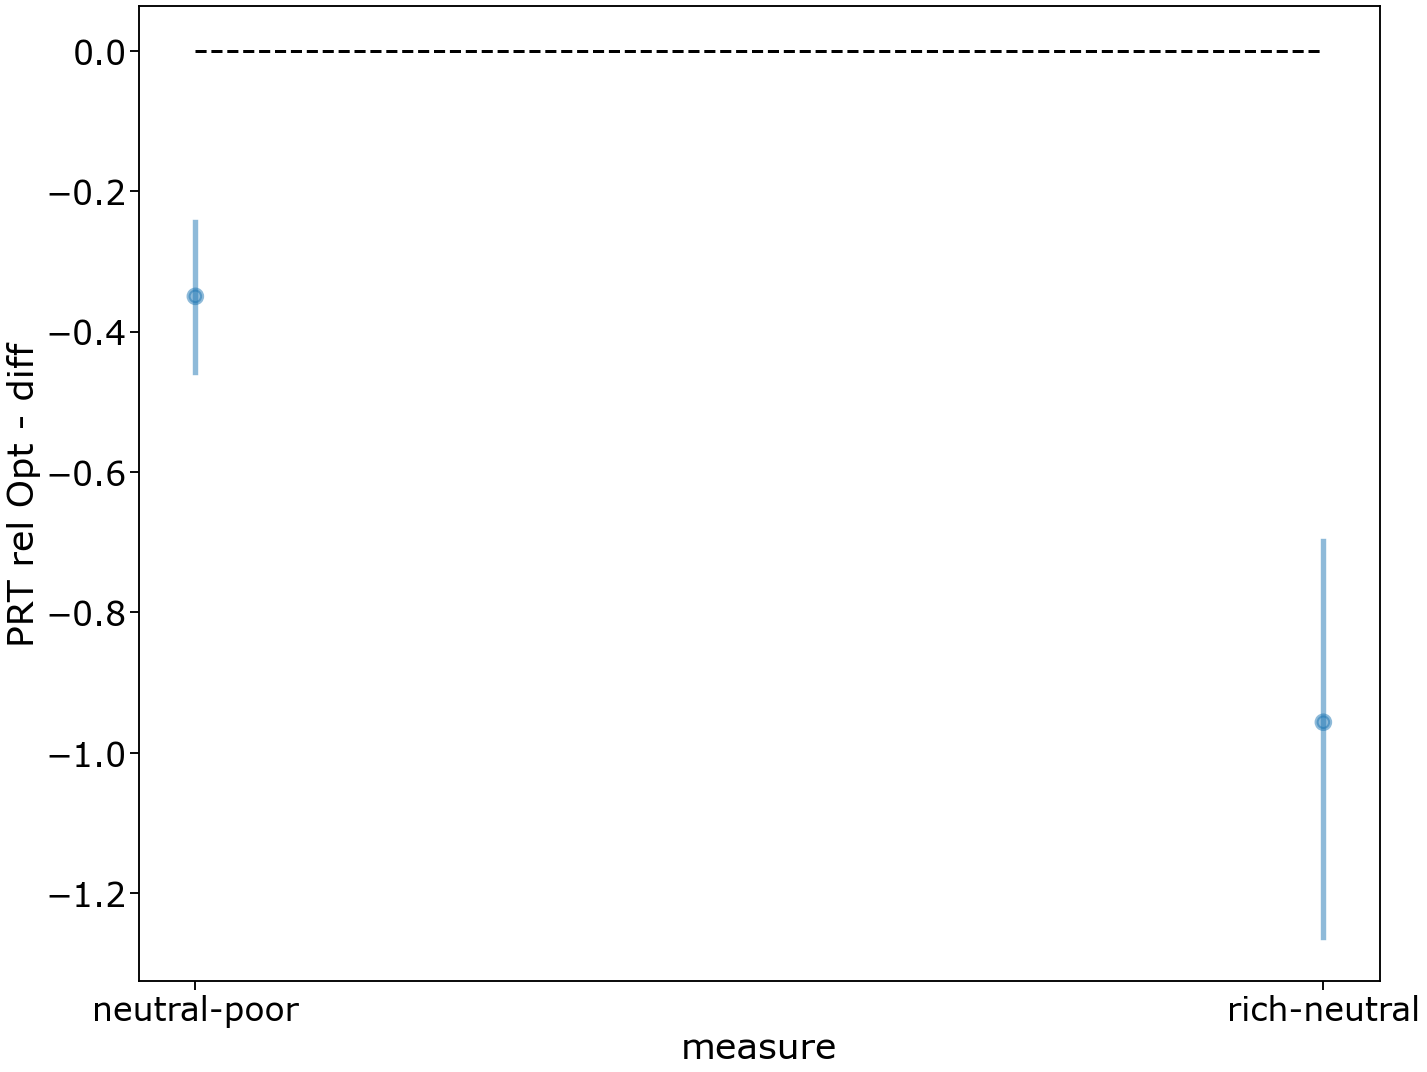

In [11]:
g=sns.pointplot(x='measure',y='PRT rel Opt - diff',ci=68,join=False,data=new_df.query("sub_num!='nan'"))
plt.setp(g.collections, alpha=.5) #for the markers
plt.setp(g.lines, alpha=.5)       #for the lines
plt.plot([0,1],[0,0],'k--')
plt.tight_layout()
plt.savefig('plots/galaxy_diff_indiv_sub.png')

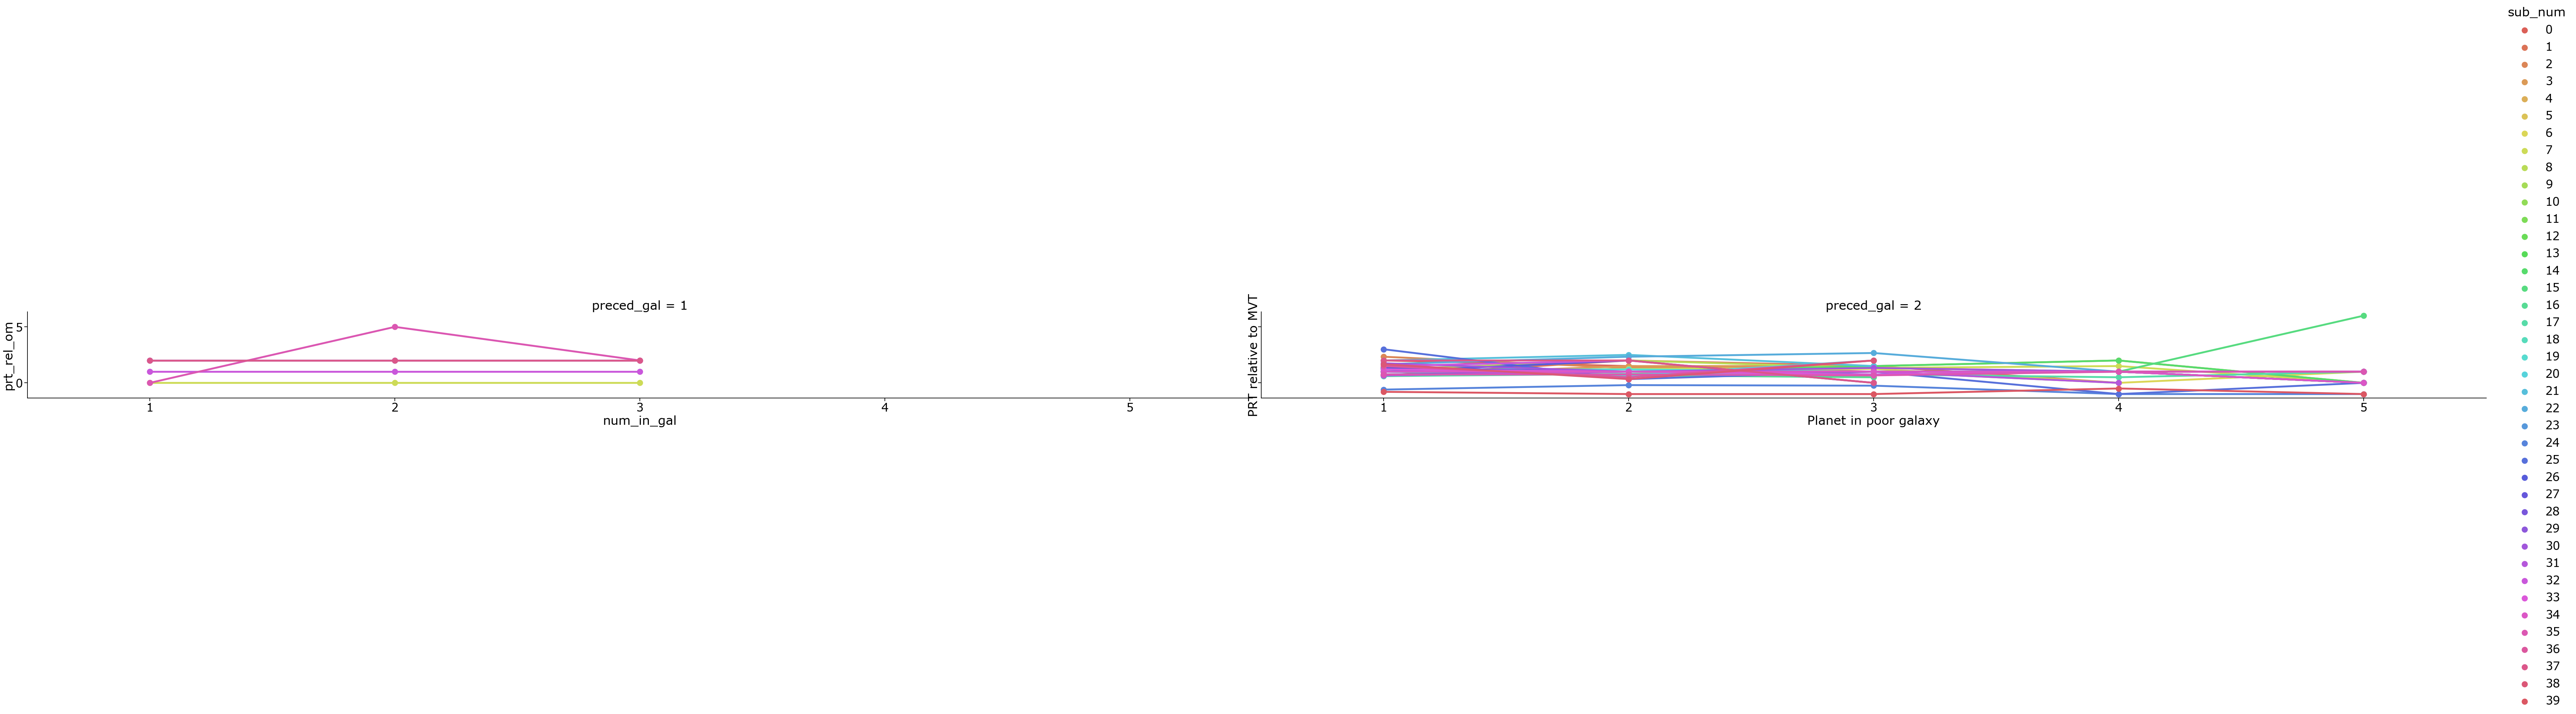

In [24]:
plt.rcParams["figure.figsize"] = (20,30)

temp=all_data.groupby(by=['sub_num','galaxy','preced_gal','num_in_gal']).prt_rel_om.mean().reset_index()
sns.catplot(x='num_in_gal',y='prt_rel_om',col='preced_gal',hue='sub_num',palette='hls',kind='point',ci=68,aspect=10,data=temp.query('galaxy==0 &(preced_gal==1 | preced_gal==2)'))
plt.ylabel("PRT relative to MVT")
plt.xlabel("Planet in poor galaxy")

plt.legend().remove()
savefig=1
#plt.tight_layout()
if savefig:
    plt.savefig("plots/recency_effects_poor_only_2021.png")

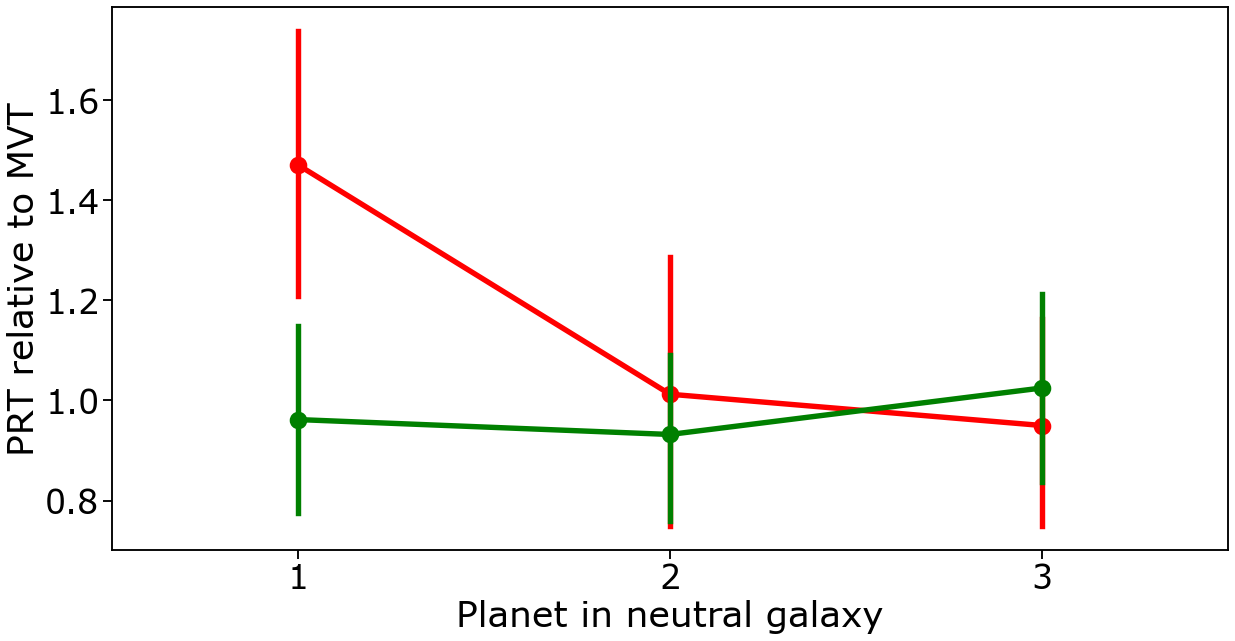

In [25]:
plt.rcParams["figure.figsize"] = (20,10)

temp=all_data.groupby(by=['sub_num','galaxy','preced_gal','num_in_gal']).prt_rel_om.mean().reset_index()
sns.pointplot(x='num_in_gal',y='prt_rel_om',hue='preced_gal',hue_order=[0,2],palette=['r','g'],ci=68,aspect=10,data=temp.query('galaxy==1 &(preced_gal==0 | preced_gal==2) &num_in_gal <=3'))
plt.ylabel("PRT relative to MVT")
plt.xlabel("Planet in neutral galaxy")

plt.legend().remove()
savefig=1
#plt.tight_layout()
plt.savefig("plots/recency_effects_neutral_only_2021.png")

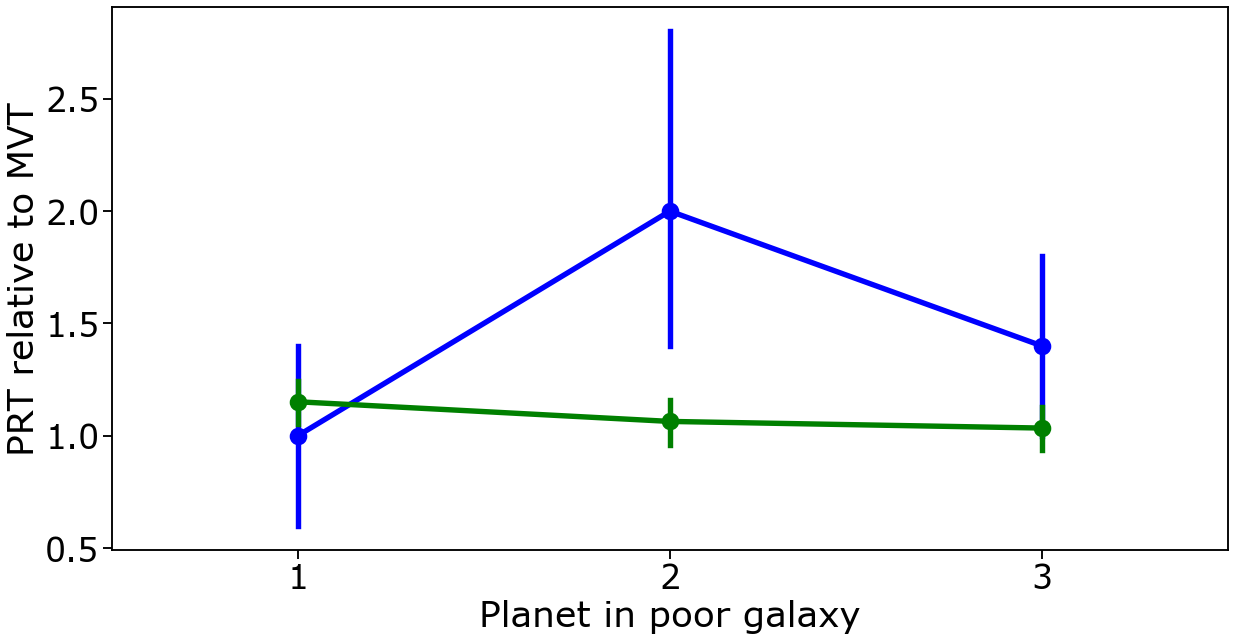

In [26]:
plt.rcParams["figure.figsize"] = (20,10)

temp=all_data.groupby(by=['sub_num','galaxy','preced_gal','num_in_gal']).prt_rel_om.mean().reset_index()
sns.pointplot(x='num_in_gal',y='prt_rel_om',hue='preced_gal',hue_order=[1,2],palette=['b','g'],ci=68,aspect=10,data=temp.query('galaxy==0 &(preced_gal==1 | preced_gal==2)  &num_in_gal <=3'))
plt.ylabel("PRT relative to MVT")
plt.xlabel("Planet in poor galaxy")

plt.legend().remove()
savefig=1
#plt.tight_layout()
if savefig:
    plt.savefig("plots/recency_effects_poor_only_2021.png")

In [65]:
plt.rcParams["figure.figsize"] = (20,30)

temp=df.groupby(by=['sub_num','galaxy','preced_gal','num_in_gal']).prt_rel_om.mean().reset_index()
sns.catplot(x='num_in_gal',y='prt_rel_om',col='preced_gal',hue='sub_num',palette='hls',kind='point',ci=68,data=temp.query('galaxy==1 &(preced_gal==0 | preced_gal==2)'))
plt.ylabel("PRT relative to MVT")
plt.xlabel("Planet in poor galaxy")

plt.legend().remove()
savefig=1
#plt.tight_layout()
if savefig:
    plt.savefig("plots/recency_effects_neutral_only.png")

NameError: name 'df' is not defined

# Reaction Time check 

In [16]:
def make_sub_rt_df(sub_num):
    print(sub_num)
    sub_df = pd.DataFrame(columns=['sub_num','condition','block','planet_num','stay_num','stay?','galaxy','prior_galaxy','num_in_gal'])
    curr_sub = all_data.query("sub_num=="+str(sub_num)).reset_index()
    n_planet = max(curr_sub.planet) + 1
    cond_num = curr_sub.condition[0]

    for p in range(n_planet):
        curr_planet = curr_sub.query("planet=="+str(p)).reset_index()
        curr_block = curr_planet.block[0]
        curr_galaxy = curr_planet.galaxy[0]
        curr_prior_galaxy = curr_planet.preced_gal[0]
        num_in_gal = curr_planet.num_in_gal[0]
        rt = curr_planet.rt_list[0]
        n_stay = len(rt)
        
#         if n_stay == 0:
#             rt = [np.nan]
#             n_stay = 1
        tmp = pd.DataFrame({'sub_num':[sub_num]*n_stay, 'condition':[cond_num]*n_stay, 
                        'block':[curr_block]*n_stay,'planet_num':[p]*n_stay,'stay_num':range(n_stay),'stay?':[1]*(n_stay-1) + [0],
                        'galaxy':[curr_galaxy]*n_stay,'prior_galaxy':[curr_prior_galaxy]*n_stay,'num_in_gal':[num_in_gal]*n_stay,
                       'rt':rt})
        sub_df['zlog_rt'] = stats.zscore(np.log(tmp['rt']),nan_policy='omit')
    return sub_df

def make_rt_df(subs):
    rt_df = pd.DataFrame(columns=['sub_num','condition','block','planet_num','stay_num','stay?','galaxy','prior_galaxy','num_in_gal'])

    for sub in subs:
        sub_df = make_sub_rt_df(sub)
        rt_df = pd.concat([rt_df,sub_df])
    return rt_df

In [17]:
subs = list(set(all_data.sub_num.tolist()))
rt_df = make_rt_df(subs)

0
1
2
3
5
6
7
8
9


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


10
11


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


12
13
15


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


16
17
18
19
20
21
22
23
24
25
27
28
29
30
31
32
33
34


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


35
36
37
38
39


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


40
41
42
44
45
46
47
48
50
51
52


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


53


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **

54
55


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


56
57
58
59
60
63
64
65
66
67
68
69
70
71
72
75
76
77
78
80
81
82
84
85


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **

87
88
89
91
92
93
94
96
97
99
100
101
102
104
105
106
107
108
109
110


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


111
112


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **

113


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


114
115
116
117


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


119
120
121
122
123
124
125
126
127


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


128
129
130
131
132


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


133
134
135
136
137
138
140
141
142
143
144
145
146
147
148
149
150


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **

151
152
153


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


154
155
156
157
158
159


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


160
161
162
163
164
165
166
167
168
169
170
171
172
173
175
176
177
178
179
181
182


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **

183
184
187


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


188
189
190
191
192
194
195
196
197
198


In [18]:
rt_df

sub_num condition block planet_num stay_num stay? galaxy prior_galaxy  \
0      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   
1      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   
2      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   
0      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   
1      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   
..     ...       ...   ...        ...      ...   ...    ...          ...   
0      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   
1      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   
2      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   
3      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   
0      NaN       NaN   NaN        NaN      NaN   NaN    NaN          NaN   

   num_in_gal  zlog_rt  
0         NaN      NaN  
1         NaN      NaN  
2         NaN      NaN  
0         NaN      NaN  
1         NaN      NaN  
..        ...      ...  
0         NaN      NaN  
1         NaN      NaN  
2         NaN      NaN  
3         NaN      NaN  
0         NaN      NaN  

[631 rows x 10 columns]

In [15]:
stats.zscore(np.log(rt_df.query("sub_num==0").rt.reset_index(drop=True)),nan_policy='omit')

0      0.978841
1      0.726489
2      1.030964
3     -1.001556
4      0.750209
         ...   
177   -0.414409
178   -0.548963
179    0.239464
180   -0.420750
181   -0.317743
Name: rt, Length: 182, dtype: float64

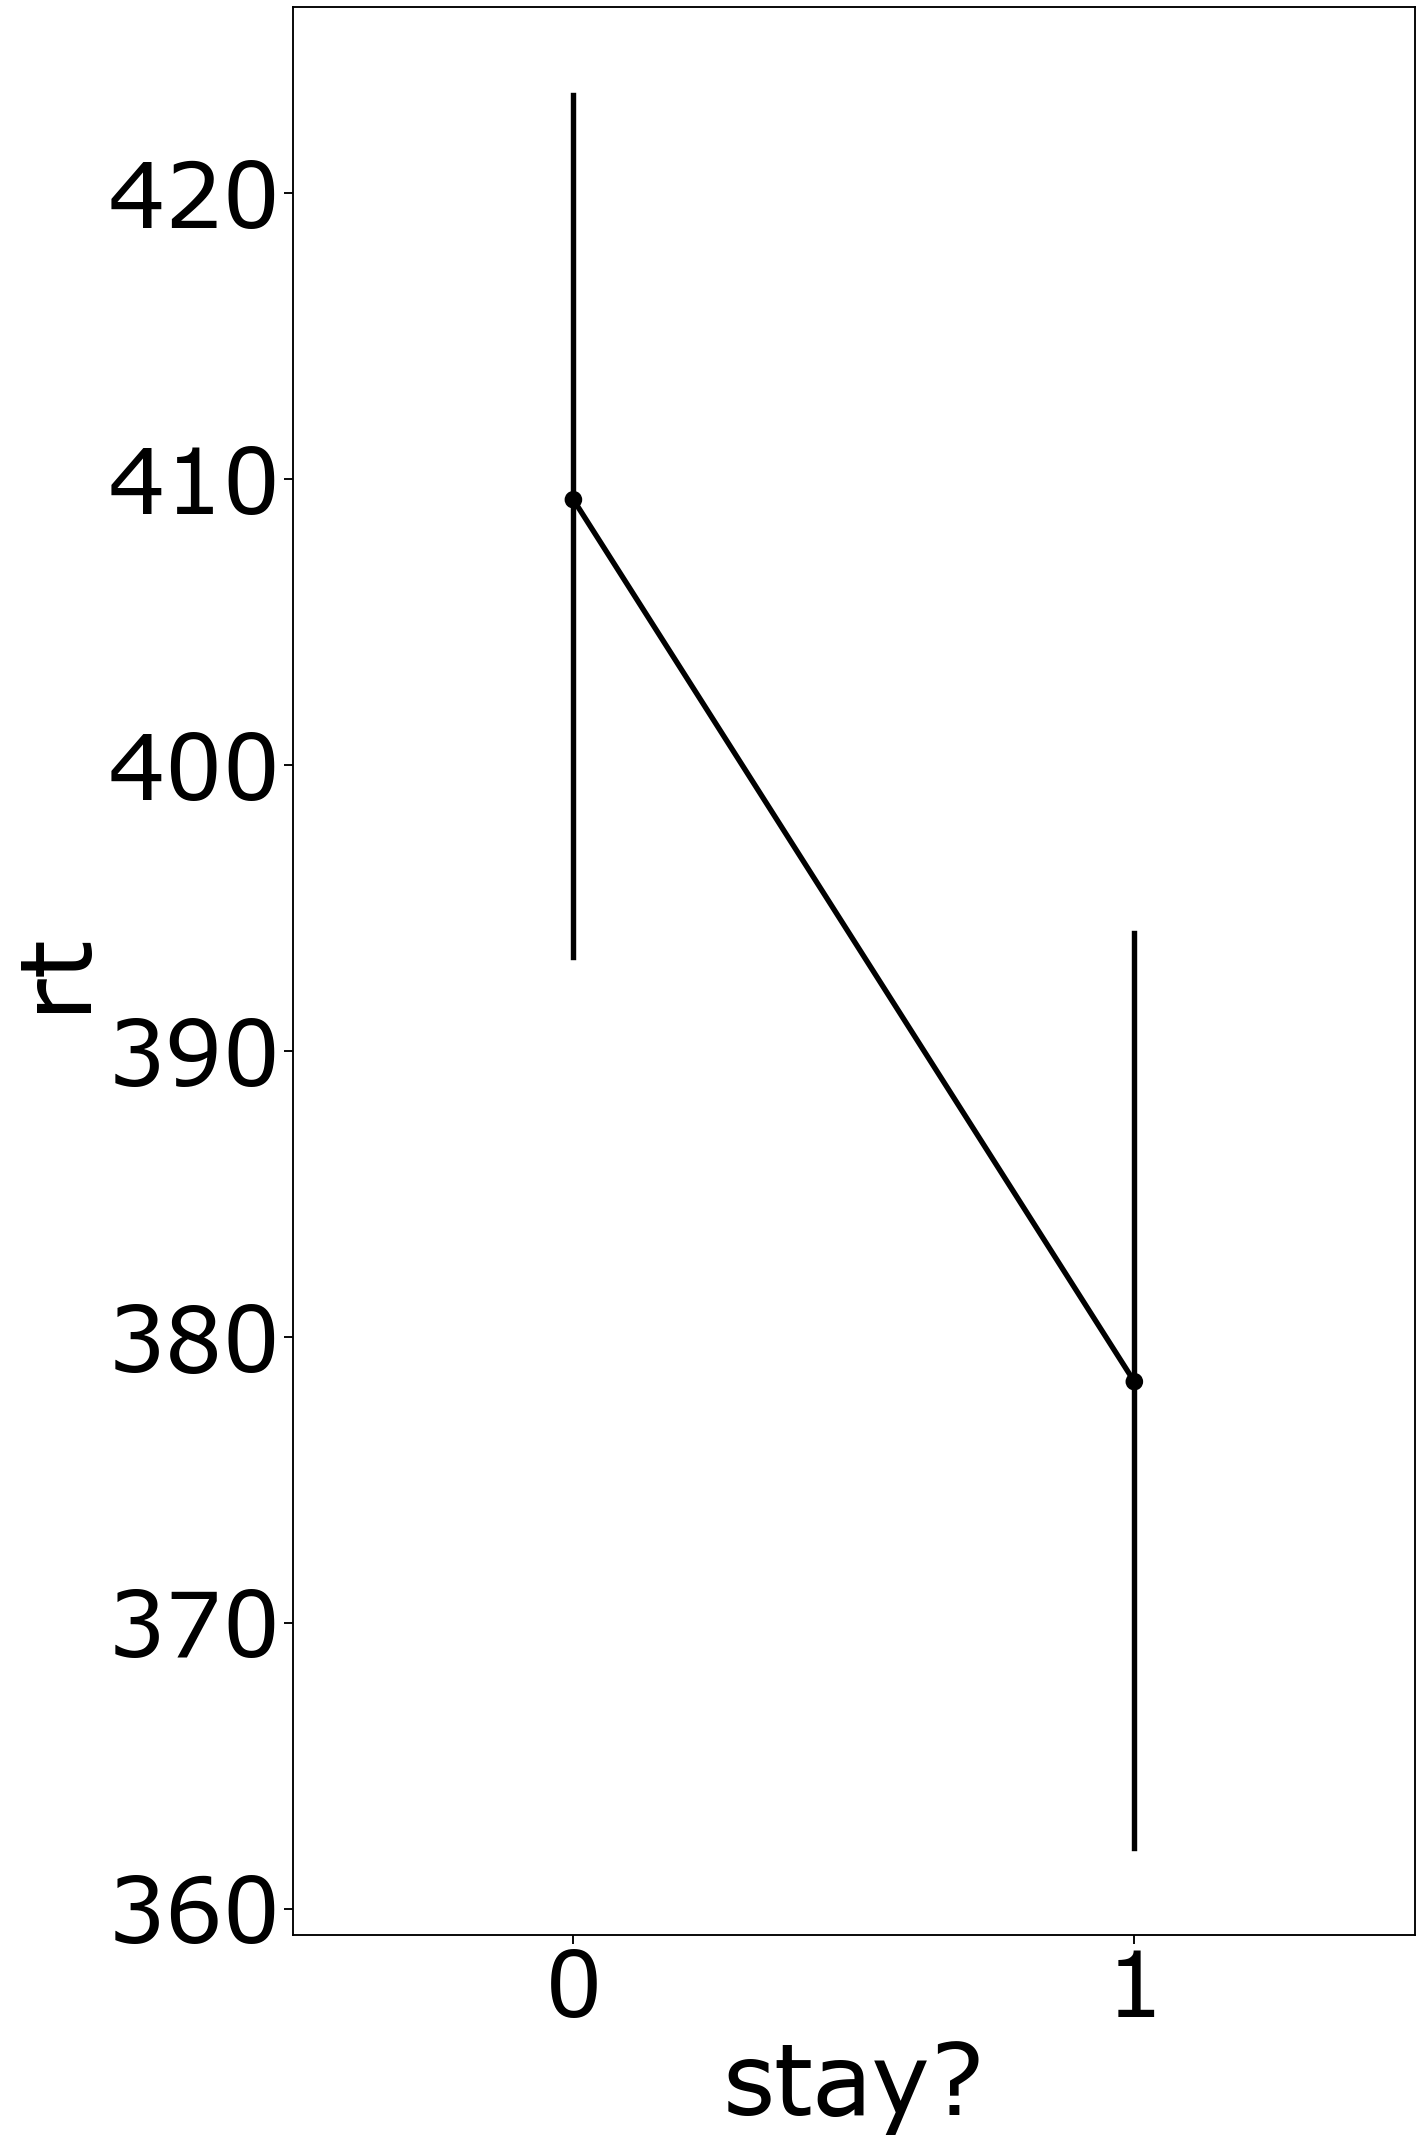

In [194]:
avg = rt_df.groupby(by=['sub_num',"stay?"]).mean().reset_index()


sns.pointplot(x='stay?',y='rt',color='k',ci=68,data=avg)
plt.tight_layout()
plt.savefig("plots/stay_leave_rt.png")

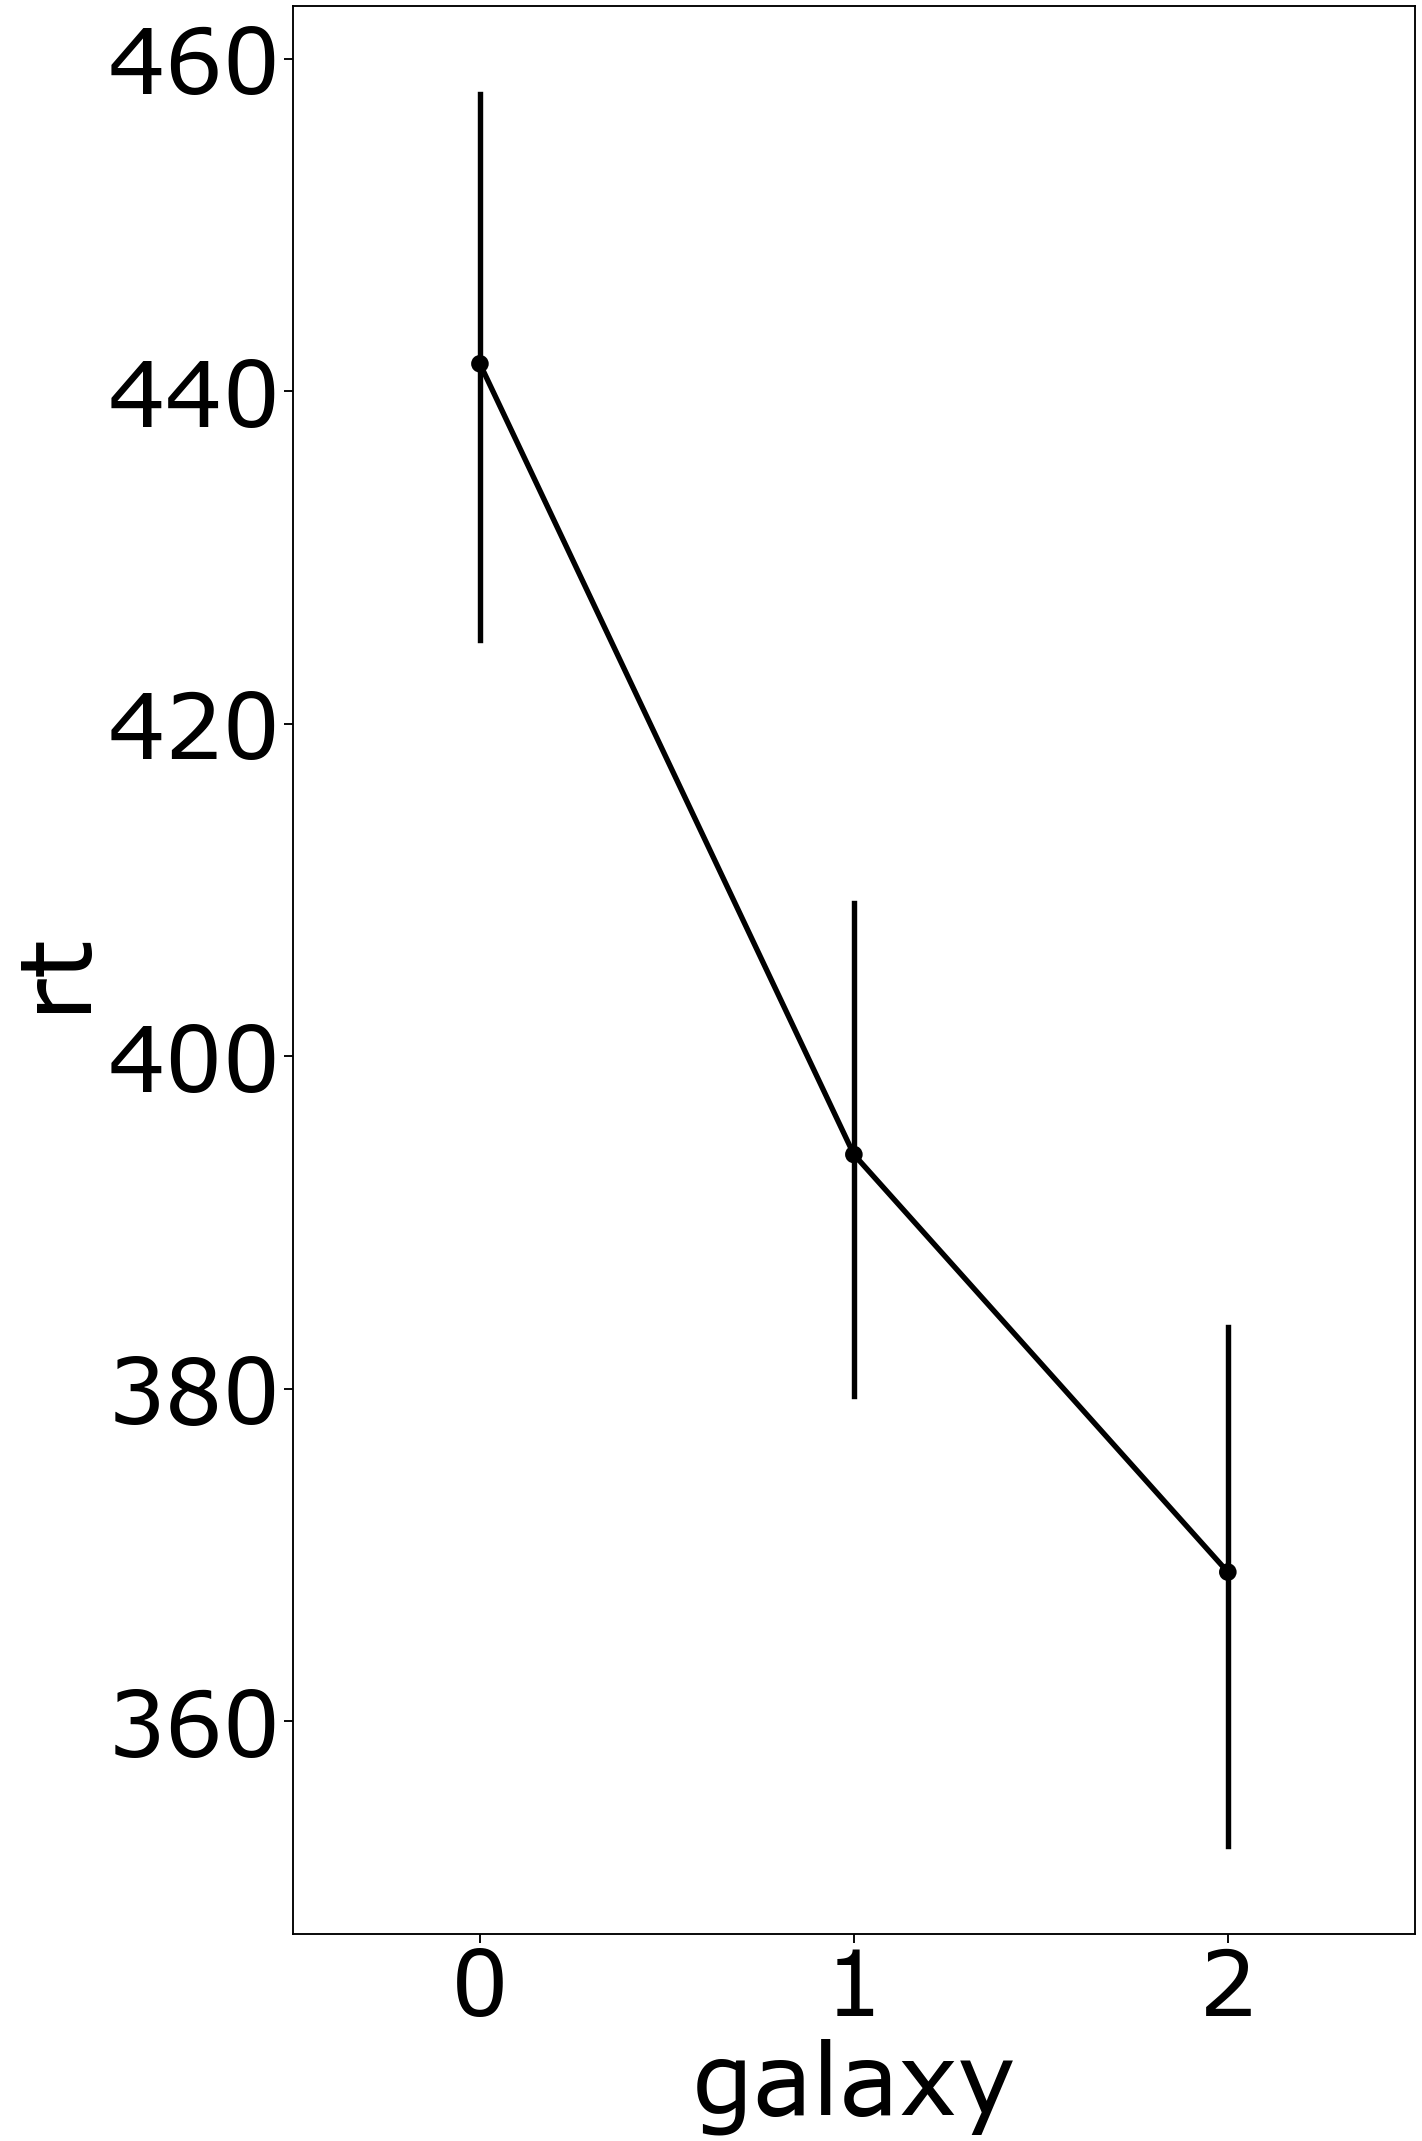

In [195]:
avg = rt_df.groupby(by=['sub_num',"galaxy"]).mean().reset_index()

sns.pointplot(x='galaxy',y='rt',ci=68,color='k',data=avg)
plt.tight_layout()

plt.savefig("plots/galaxy_rt.png")

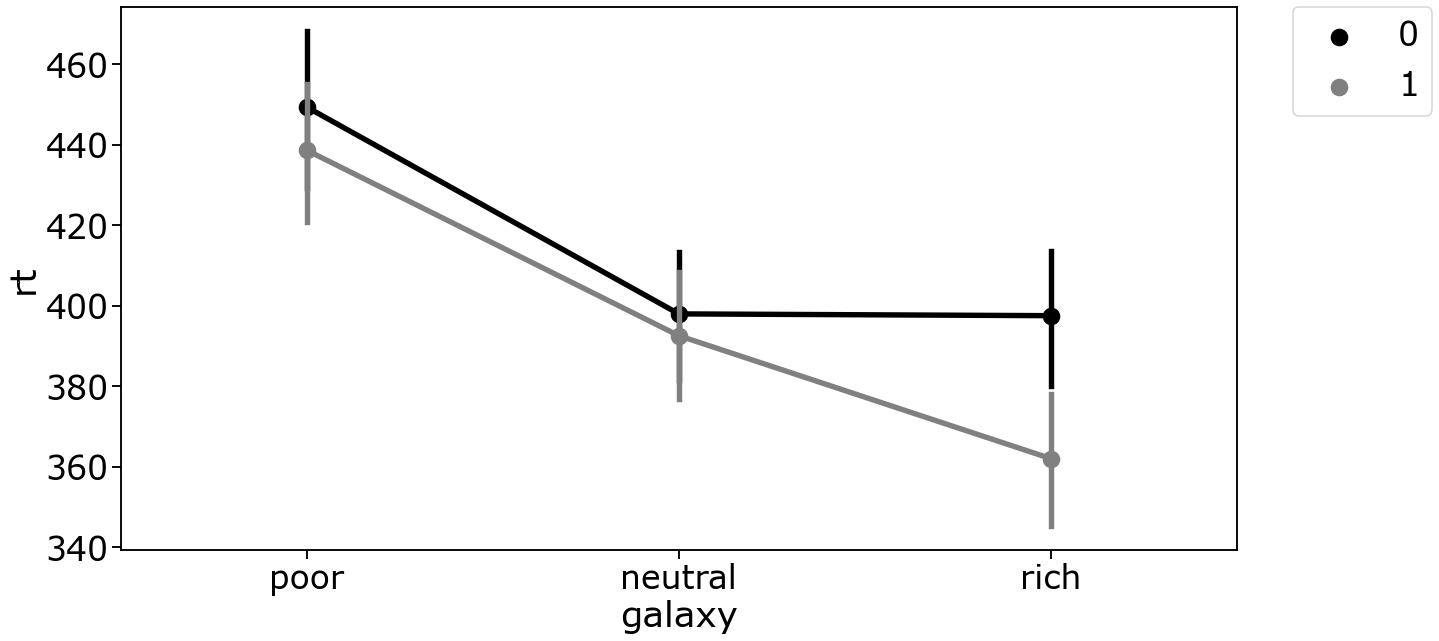

In [56]:
avg = rt_df.groupby(by=['sub_num',"stay?","galaxy"]).mean().reset_index()

g=sns.pointplot(x='galaxy',y='rt',hue="stay?",palette=['black','grey'],legend_out=False,ci=68,data=avg)
g.set_xticklabels(['poor','neutral','rich'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend(labels=['leave','stay'])

plt.savefig("plots/galaxy_rt_staay.png")

In [78]:
avg['stay'] = avg['stay?'] 
diff=np.array(avg.query("galaxy==2 & stay==0").zlog_rt.tolist()) - np.array(avg.query("galaxy==2 & stay==1").zlog_rt.tolist())
subs=avg.query("galaxy==2 & stay==0").sub_num.tolist()
diff = pd.DataFrame({'sub_num':subs,'diff':diff})
diff

sub_num      diff
0          0  0.306332
1          1  0.249016
2          2  0.962897
3          3 -0.222072
4          5  0.054899
..       ...       ...
111      190 -0.612498
112      192 -1.027970
113      195  0.022501
114      196 -0.592937
115      197 -0.045371

[116 rows x 2 columns]

<AxesSubplot:xlabel='num_in_gal', ylabel='zlog_rt'>

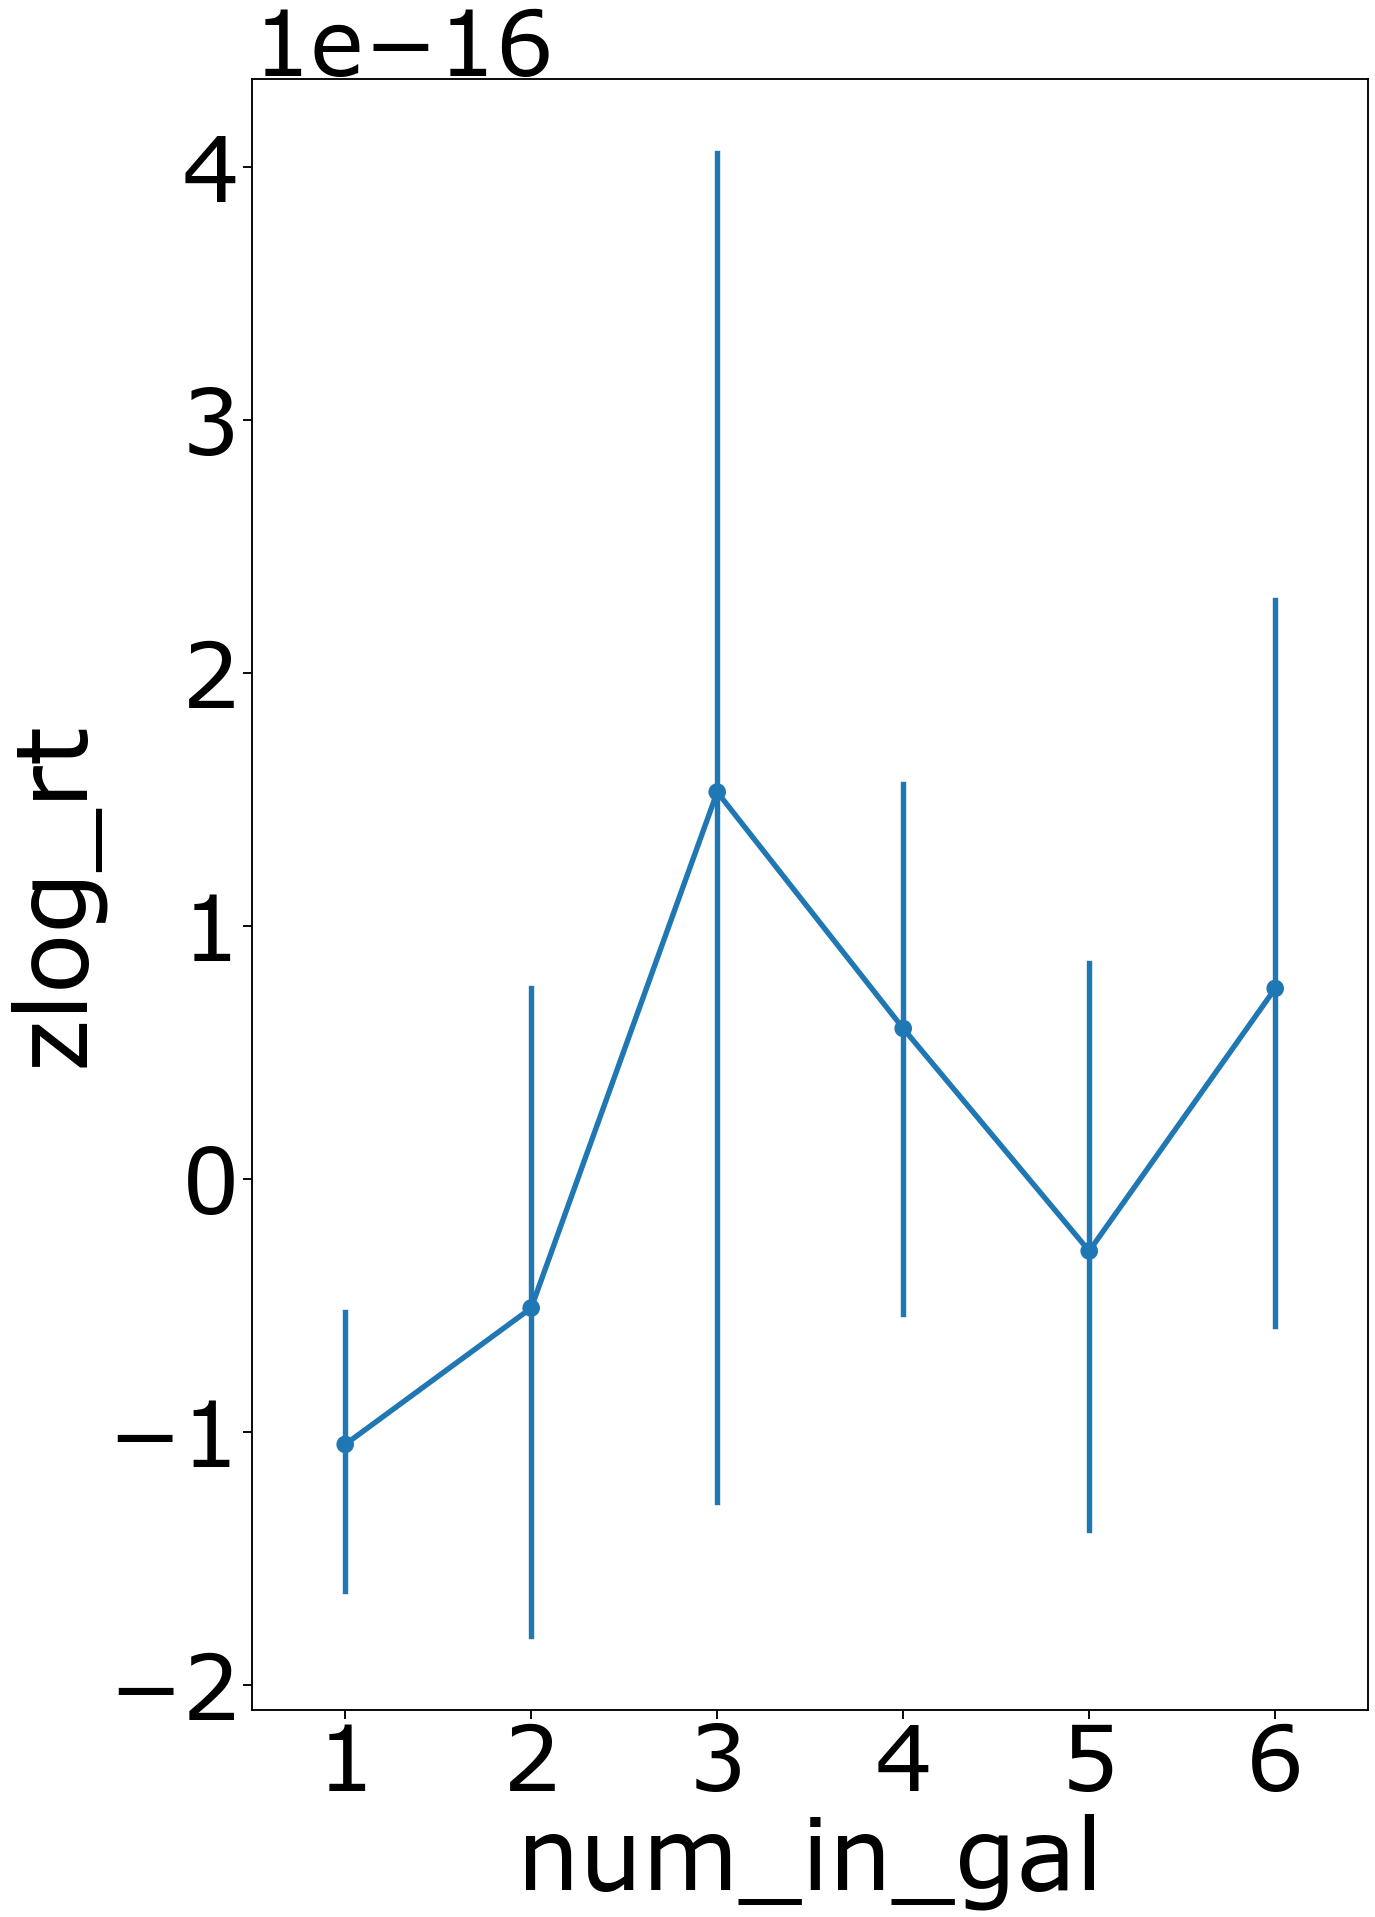

In [198]:
avg = rt_df.groupby(by=['sub_num',"num_in_gal"]).mean().reset_index()
sns.pointplot(x='num_in_gal',y='zlog_rt',ci=68,data=avg.query("num_in_gal <= 6"))


(-0.5, 6.05)

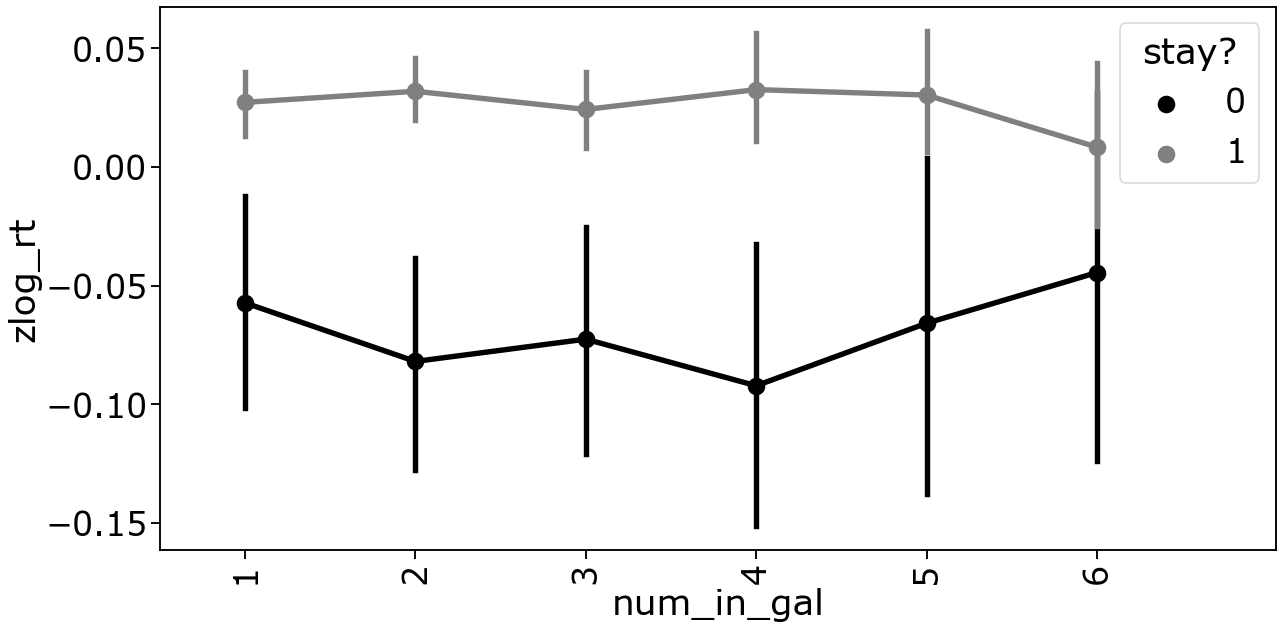

In [97]:
plt.rcParams["figure.figsize"] = (20,10)

avg = rt_df.groupby(by=['sub_num',"num_in_gal","stay?"]).mean().reset_index()
sns.pointplot(x='num_in_gal',y='zlog_rt',hue="stay?",palette=['black','grey'],ci=68,data=avg.query("num_in_gal <= 6"))
plt.xticks(rotation=90)
plt.xlim([-0.5,6.05])

# correlate w/ model parameters

In [79]:
params = pd.read_csv("params_2022.csv")

rt_df=pd.merge(rt_df, params, on='sub_num')
all_data=pd.merge(all_data, params, on='sub_num')
diff=pd.merge(diff, params, on='sub_num')

In [19]:
sns.set_context('talk',font_scale=3)


In [20]:
sns.lmplot(x='gamma',y='total_score',data=all_data)

KeyError: "['total_score'] not in index"

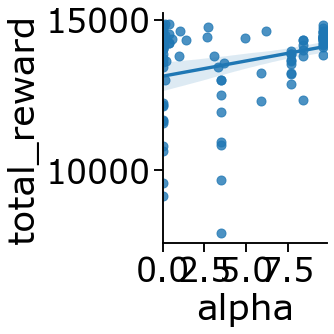

In [21]:
sns.set_context('talk',font_scale=2)

avg = all_data.groupby(by=['sub_num','alpha']).mean().reset_index()

sns.lmplot(x='alpha',y='total_reward',data=avg)

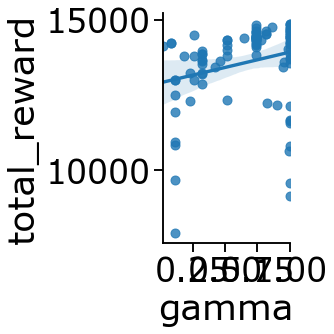

In [22]:
avg = all_data.groupby(by=['sub_num','gamma']).mean().reset_index()

sns.lmplot(x='gamma',y='total_reward',data=avg)

Ttest_indResult(statistic=1.2614387049107507, pvalue=0.21020743729416597)


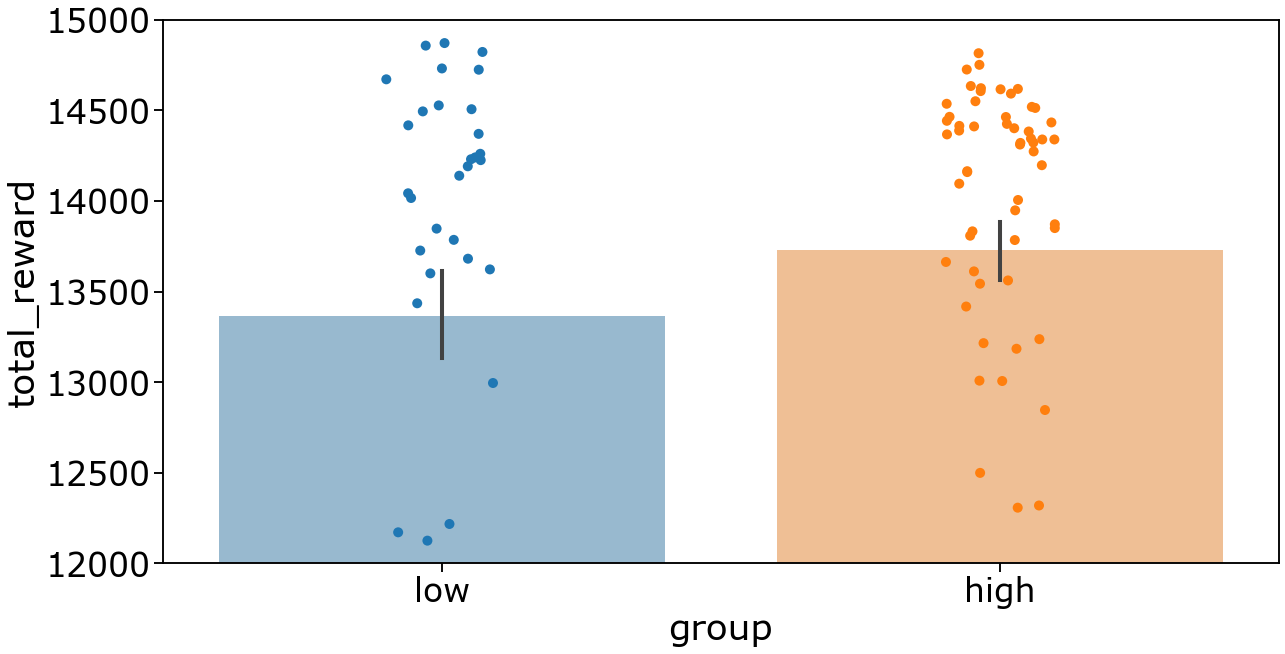

In [28]:
avg = all_data.groupby(by=['sub_num','alpha']).mean().reset_index()

avg['group'] =avg.apply (lambda row: label_group(row), axis=1)
g=sns.barplot(x='group',y='total_reward',alpha=0.5,ci=68,data=avg)
sns.stripplot(x='group',y='total_reward',s=10,data=avg)
g.set_ylim([12000,15000])
print(stats.ttest_ind(avg.query("group=='high'").total_reward,avg.query("group=='low'").total_reward))
plt.savefig('plots/total_reward_v_alpha_large.png',bbox_inches = "tight",dpi=300)

In [29]:
avg['rho_2_trans_0'] = rho_2_trans_0
avg['rho_2_trans_1'] = rho_2_trans_1

Ttest_indResult(statistic=1.9535199479513468, pvalue=0.05366906106672878)


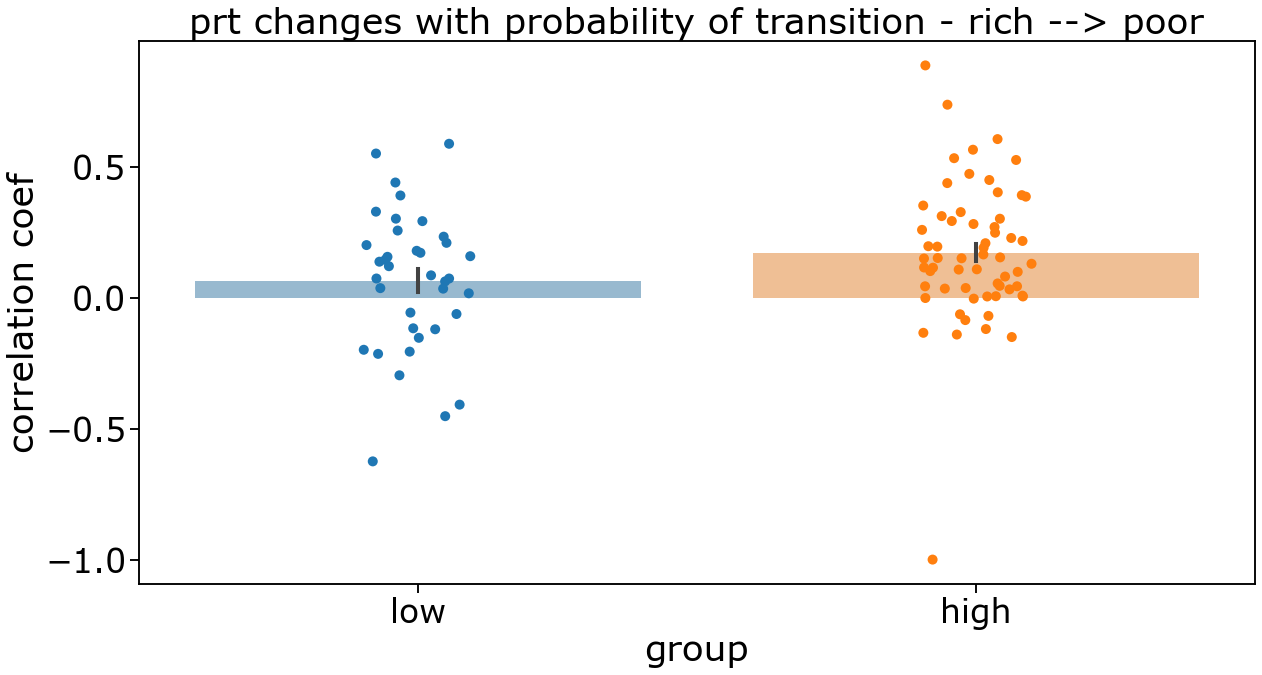

In [31]:
g=sns.barplot(x='group',y='rho_2_trans_0',alpha=0.5,ci=68,data=avg)
sns.stripplot(x='group',y='rho_2_trans_0',s=10,data=avg)
g.set_ylabel('correlation coef')
g.set_title('prt changes with probability of transition - rich --> poor')
print(stats.ttest_ind(avg.query("group=='high'").rho_2_trans_0,avg.query("group=='low'").rho_2_trans_0))
plt.savefig('plots/rho_2_0_v_alpha_large.png',bbox_inches = "tight",dpi=300)

Ttest_indResult(statistic=-1.0746309166226926, pvalue=0.28523358486155304)


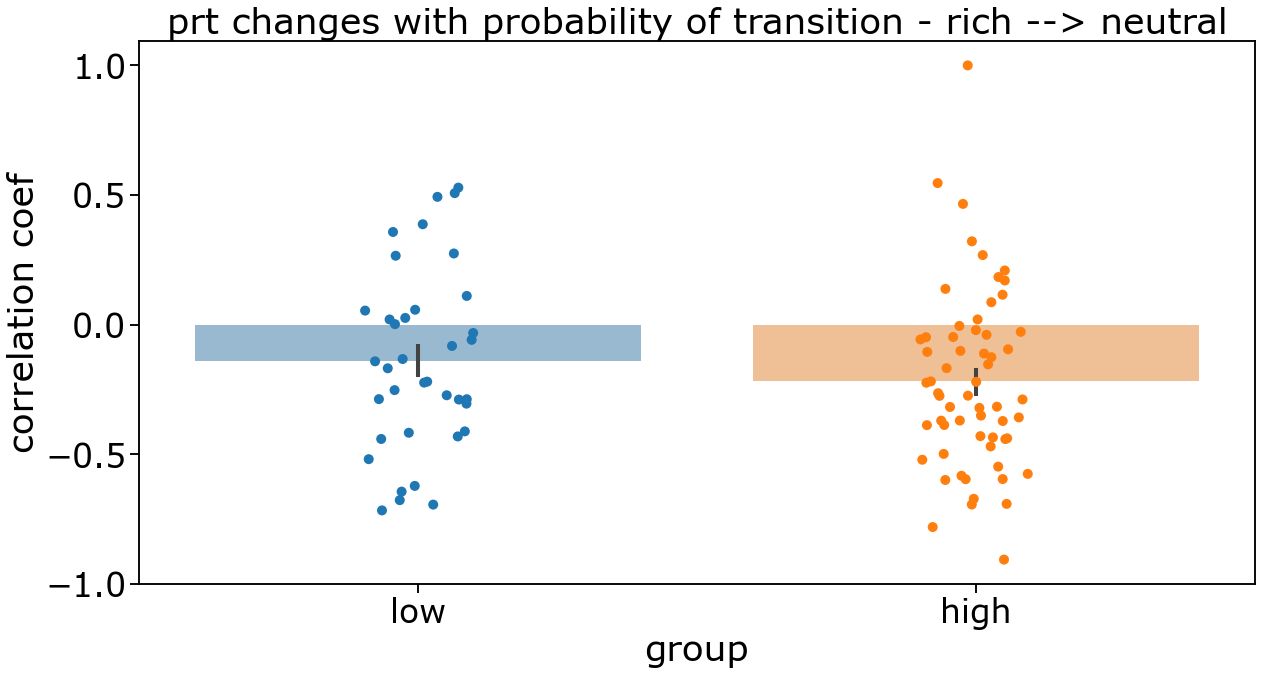

In [32]:
g=sns.barplot(x='group',y='rho_2_trans_1',alpha=0.5,ci=68,data=avg)
sns.stripplot(x='group',y='rho_2_trans_1',s=10,data=avg)
g.set_ylabel('correlation coef')
g.set_title('prt changes with probability of transition - rich --> neutral')
print(stats.ttest_ind(avg.query("group=='high'").rho_2_trans_1,avg.query("group=='low'").rho_2_trans_1))
plt.savefig('plots/rho_2_1_v_alpha.png',bbox_inches = "tight",dpi=300)

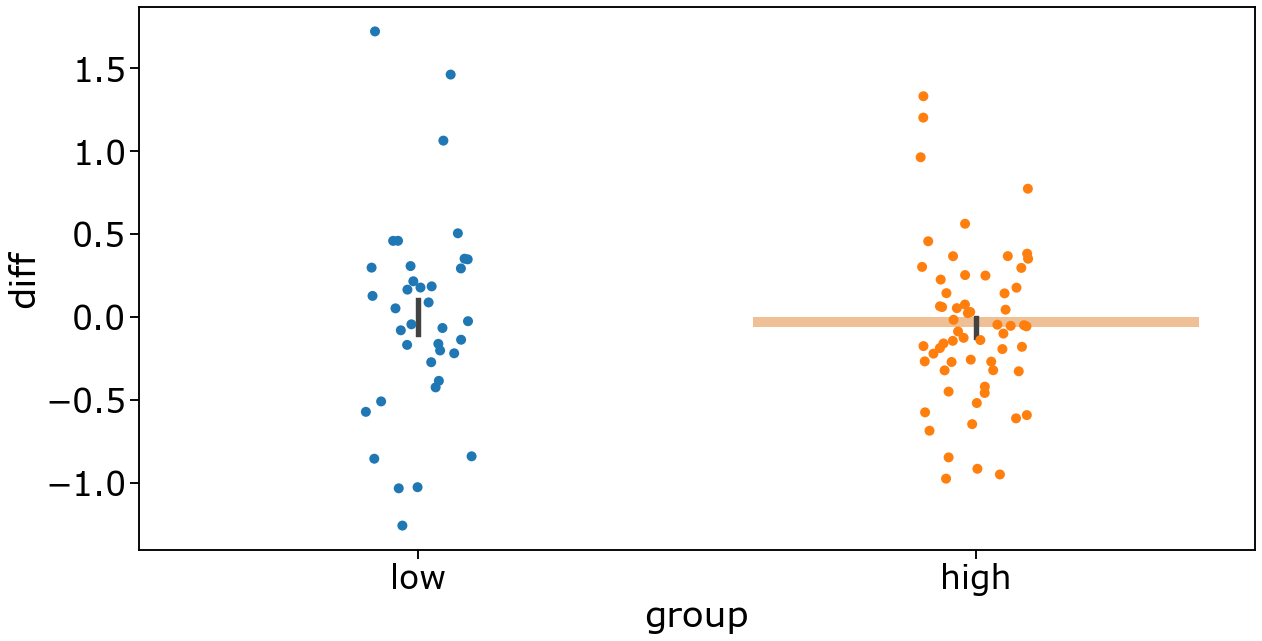

In [86]:
avg = diff.groupby(by=['sub_num','alpha']).mean().reset_index()

avg['group'] =avg.apply (lambda row: label_group(row), axis=1)
g=sns.barplot(x='group',y='diff',alpha=0.5,ci=68,data=avg)
sns.stripplot(x='group',y='diff',s=10,data=avg)
#print(stats.ttest_ind(avg.query("group=='high'").diff,avg.query("group=='low'").diff))
plt.savefig('plots/diff_v_alpha_large.png',bbox_inches = "tight",dpi=300)

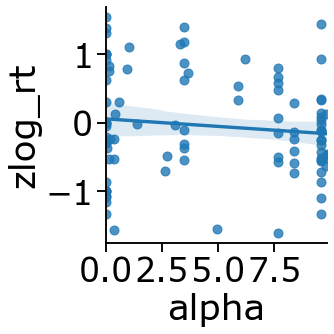

In [42]:
avg=rt_df.groupby(by=['sub_num',"stay?","alpha","num_in_gal"]).mean().reset_index()
avg['stay']=avg['stay?']
leave_rt = avg.query("stay==0 & num_in_gal==6")

sns.lmplot(x='alpha',y='zlog_rt',data=leave_rt)

In [81]:
def label_group (row):
    if row['alpha'] < 1:
        return 'low'
    else:
        return 'high'
leave_rt['group'] =leave_rt.apply (lambda row: label_group(row), axis=1)

NameError: name 'leave_rt' is not defined

Ttest_indResult(statistic=-0.06139467511006299, pvalue=0.9511725311105796)


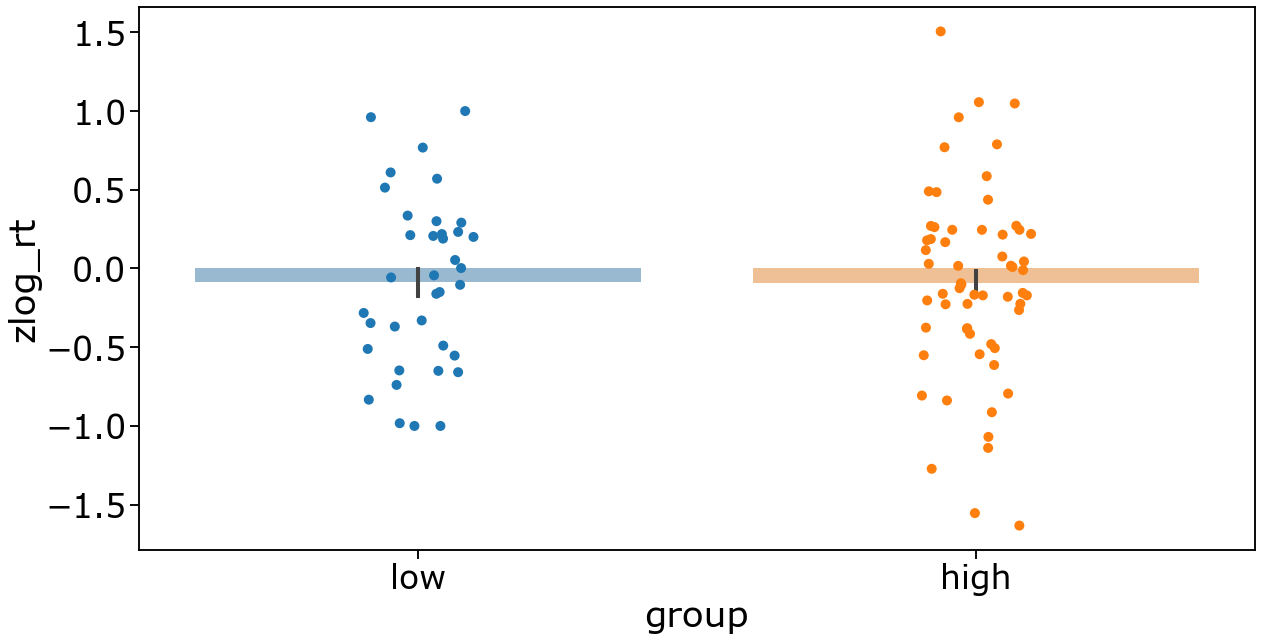

In [38]:
sns.barplot(x='group',y='zlog_rt',ci=68,alpha=0.5,data=leave_rt)
sns.stripplot(x='group',y='zlog_rt',s=10,data=leave_rt)

print(stats.ttest_ind(leave_rt.query("group=='high'").zlog_rt,leave_rt.query("group=='low'").zlog_rt))
plt.savefig('plots/zlog_rt_v_alpha.png',bbox_inches = "tight",dpi=300)

# Demograpics 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


           n         r          CI95%       r2    adj_r2     p-val   BF10  \
pearson  116 -0.027751  [-0.21, 0.16]  0.00077 -0.016915  0.767455  0.121   

            power  
pearson  0.059966  


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


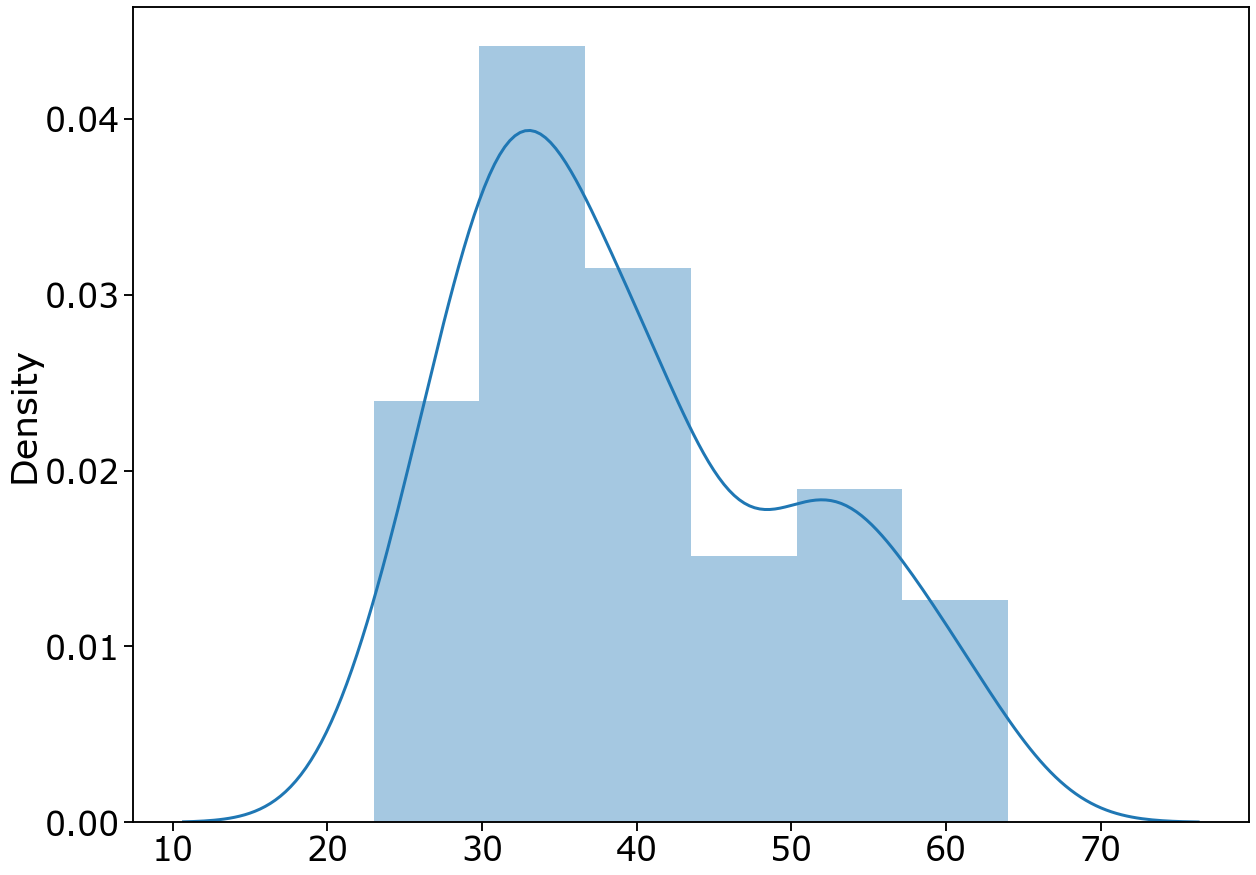

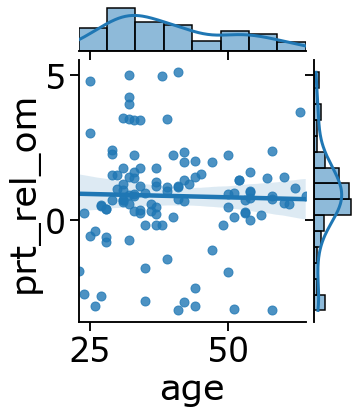

In [124]:
sns.distplot(all_data.groupby("sub_num").age.mean().tolist())
if savefig:
    plt.savefig("plots/age_dsistribution.png")


print(pg.corr(all_data.groupby("sub_num").age.mean(),all_data.groupby("sub_num").prt_rel_om.mean()))
sns.jointplot(all_data.groupby("sub_num").age.mean(),all_data.groupby("sub_num").prt_rel_om.mean(),kind="reg")
if savefig:
    plt.savefig("plots/age_dsistribution_corr_prt_rel_mvt.png")


In [130]:
np.std(all_data.groupby("sub_num").age.mean())

10.561087236394952

In [113]:
stats.tstd(all_data.groupby(by='sub_num').age.mean())


13.505079766042831

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


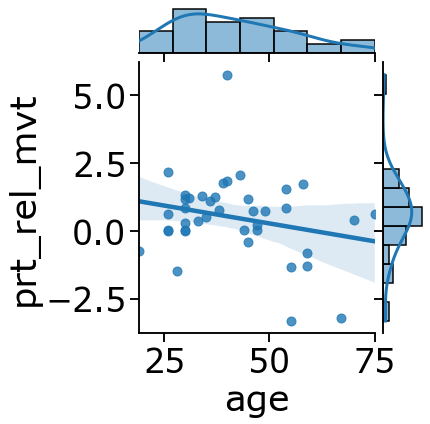

In [33]:
sns.jointplot(all_data.groupby("sub_num").age.mean(),all_data.groupby("sub_num").prt_rel_mvt.mean(),kind="reg")


In [34]:
s = 0
gender_df = pd.DataFrame(columns=['sub_num','gender'])
for f in all_filenames:
    raw_data = pd.read_csv(f)    
    gender = raw_data.query("trial_type=='demo'").planet.tolist()[0].split(":")[1]
    
    row = pd.DataFrame({'sub_num':s,'gender':gender},index=[0])
    
    gender_df = pd.concat([gender_df,row])
    s+= 1

TypeError: unsupported operand type(s) for +: 'builtin_function_or_method' and 'str'

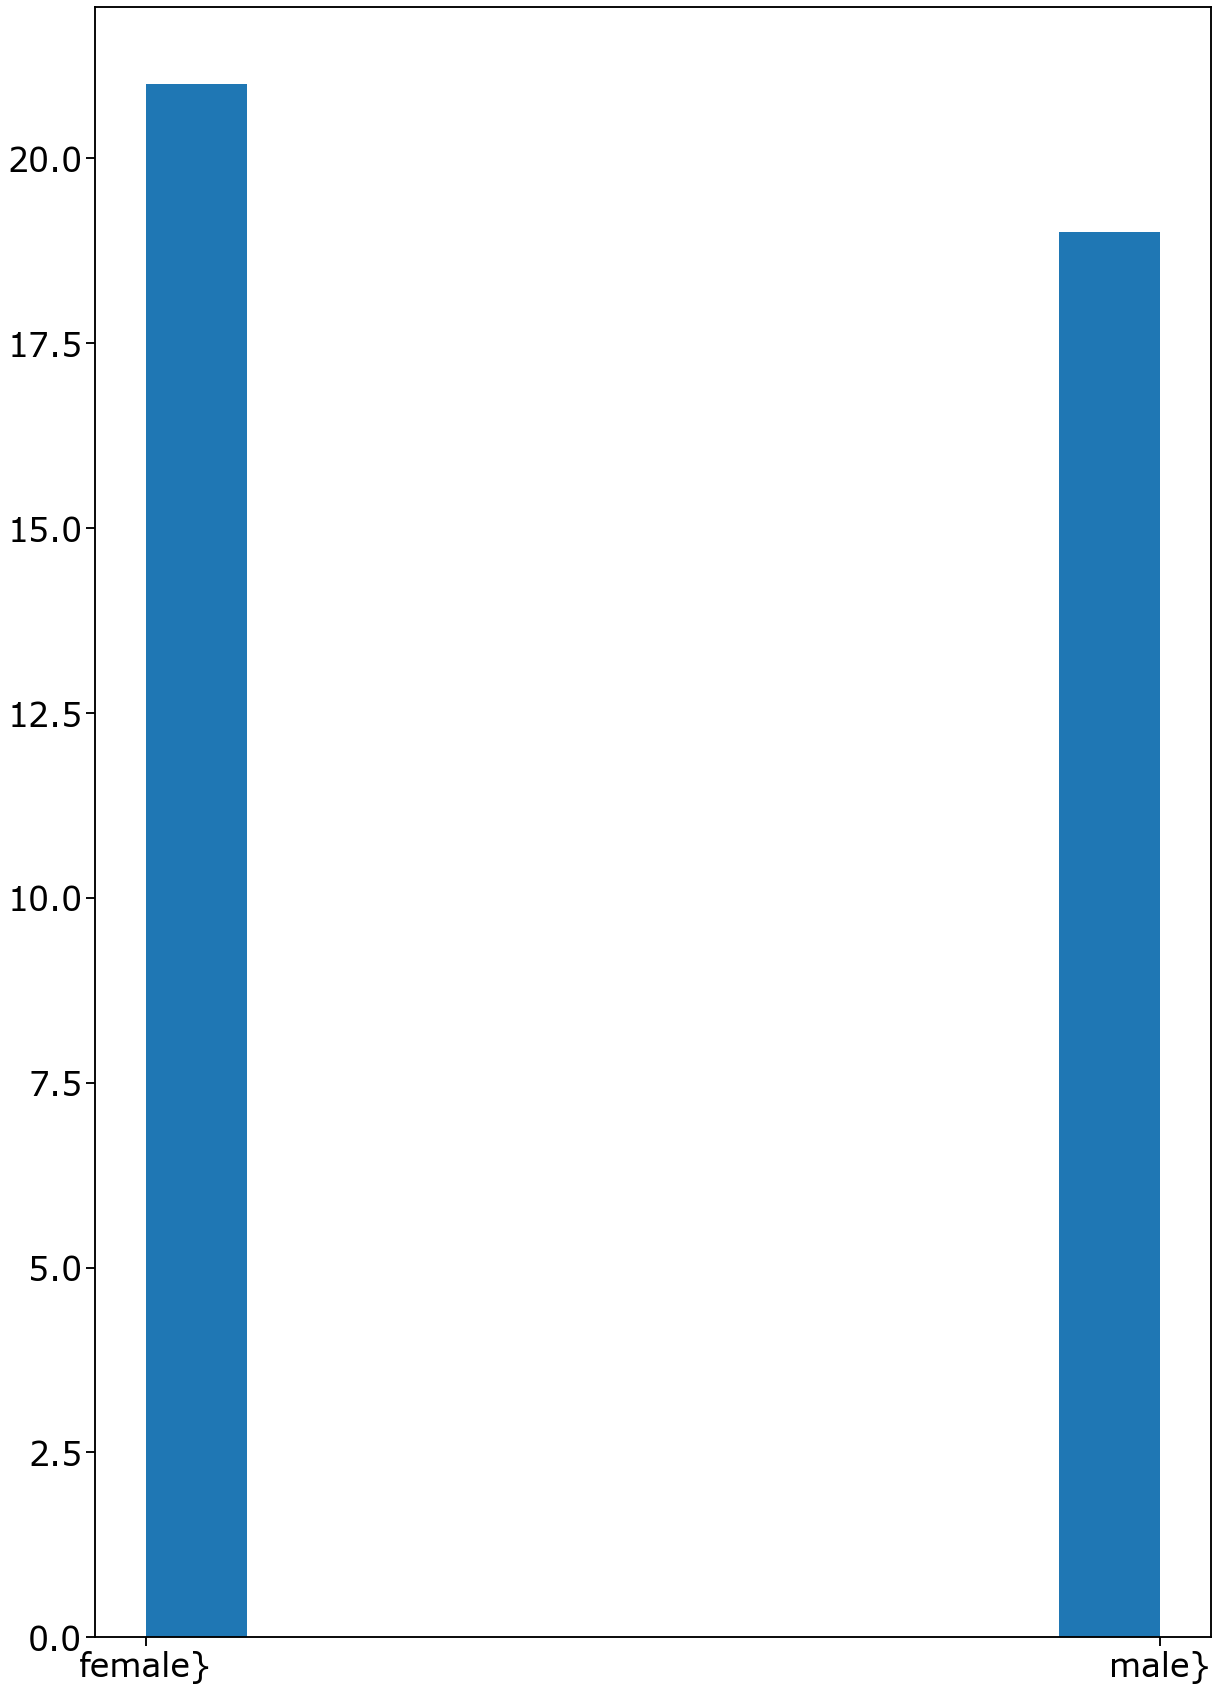

In [35]:
plt.hist(gender_df['gender'].tolist())
if savefig:
    plt.savefig(round+"/hist_gender.png")


# QUIC

In [75]:
##### FOR ANALYZING QUIC DATA 
def indiv_quic_data(filename,sub_num):
    raw_data = pd.read_csv(filename)
    sub_quic_data = pd.DataFrame(columns=["sub_num",'q_num','answer'])
    prior_12=raw_data.loc[raw_data["trial_type"]=="quic_prior_12"]

    for question in range(6,15):
        temp = re.split(':|{|}',str(prior_12.iloc[:,question].values[0]))
        temp = list(filter(lambda a: a != '', temp))
        q_num = int(temp[0][1])
        temp_df = pd.DataFrame({'sub_num': sub_num,'q_num':q_num,'answer':temp[1]}, index=[0])
        sub_quic_data = sub_quic_data.append(temp_df)
    
    prior_18=raw_data.loc[raw_data["trial_type"]=="quic_prior_18"]
    for question in range(6,35):
        temp = re.split(':|{|}',prior_18.iloc[:,question].values[0])
        temp = list(filter(lambda a: a != '', temp))
        temp[1] = temp[1].split('}')[0]
        q_num = int(temp[0][1:]) + 9

        temp_df = pd.DataFrame({'sub_num': sub_num,'q_num':q_num,'answer':temp[1]}, index=[0])
        sub_quic_data = sub_quic_data.append(temp_df)
    sub_quic_data = sub_quic_data.replace({'Yes':1,'No':0,'Prefer not to answer':np.nan})
    return sub_quic_data

def make_all_quic_data(filenames):
    num_subs = len(filenames)
    quic_data = pd.DataFrame(columns=["sub_num",'q_num','answer','total_score'])
    for f in range(num_subs):
        try:
            sub_data = indiv_quic_data(filenames[f],f)
            summary_score = quic_summary(sub_data)
            sub_data['total_score'] = summary_score
            quic_data = quic_data.append(sub_data)
        except:
            continue
    quic_data = quic_data.astype({'sub_num':'int','q_num':'int','total_score': 'int'})

    return quic_data

def quic_summary(dataframe):
    reverse_items = [0,1,2,3,4,5,6,8,9,10,13,15,25,32]
    # reverse code the dataframes 
    dataframe = reverse_code_items(dataframe,reverse_items)
    # now calc a summary score 
    return dataframe['answer'].sum()
    

def reverse_code_items(dataframe,reverse_items):
    for item in reverse_items:
        dataframe.iloc[item]['answer'] = 1 - dataframe.iloc[item]['answer']
    return dataframe

In [76]:
all_quic_data = make_all_quic_data(all_filenames)
quic_sub_sort = all_quic_data.sort_values(by=['total_score'],ascending=False)['sub_num'].unique()
# high to low 
quic_sub_sort

#all_quic_data = all_quic_data.dropna()

<ipython-input-75-4b862fa89240>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.iloc[item]['answer'] = 1 - dataframe.iloc[item]['answer']


array([ 48,  13,  98,  72,  30, 106, 100,  21,  77,  23, 101,  10,  63,
        82,   2,  42,   9,  17,  50,  79,  94,  40,  37,  97,  93,  29,
         3,  31,  61,  64,  90,   5,  26, 107,  70,  55, 105,  47,  22,
        28,  62,  89,  99,  12,  67,  68,  51,  18, 102,  25,  66,  85,
        19, 109,  35,  71,  38,  95,  81,  73,  53,  32,   6,  87,   0,
        14,  43,  11,  84,  88,  91,  57,   1,  15,  74,  27, 108,   8,
        83,  36,  20,  39,  92,  86,  78,  75,  80,  69,  49,  45,  96,
         7,  41,  56,  59,  60])

In [77]:
quic=all_quic_data.loc[:,['sub_num','total_score']]

In [78]:
x=avgd_data.merge(all_quic_data.loc[:,['sub_num','total_score']].drop_duplicates())
x.loc[:,['sub_num','condition','prt_rel_mvt','total_score']].to_csv('to_correlate_with_params.csv')

In [79]:
all_quic_data.loc[:,['sub_num','total_score']].drop_duplicates()

sub_num  total_score
0         0            7
0         1            5
0         2           23
0         3           18
0         5           17
..      ...          ...
0       105           15
0       106           25
0       107           17
0       108            4
0       109           10

[96 rows x 2 columns]

In [137]:
avg = all_data.groupby('sub_num').mean().reset_index()
subs = avg["sub_num"].tolist()
avg = avg.set_index('sub_num')

avg = all_data.groupby(['sub_num','galaxy']).mean().reset_index()
avg_rich=avg.query("galaxy==2")
avg_rich = avg_rich.set_index('sub_num')

avg_quic=all_quic_data.groupby('sub_num').mean().reset_index(0)
avg_quic = avg_quic.set_index('sub_num')
quic_df = pd.DataFrame({'sub_num':subs,'avg_prt':list(avg['prt'].loc[subs]),'avg_rich_prt':list(avg_rich['prt'].loc[subs]),'total_reward':list(avg['total_reward'].loc[subs]),'quic_score':list(avg_quic['total_score'].loc[subs])})
quic_df = quic_df[~quic_df['sub_num'].isin(subs_to_drop)]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

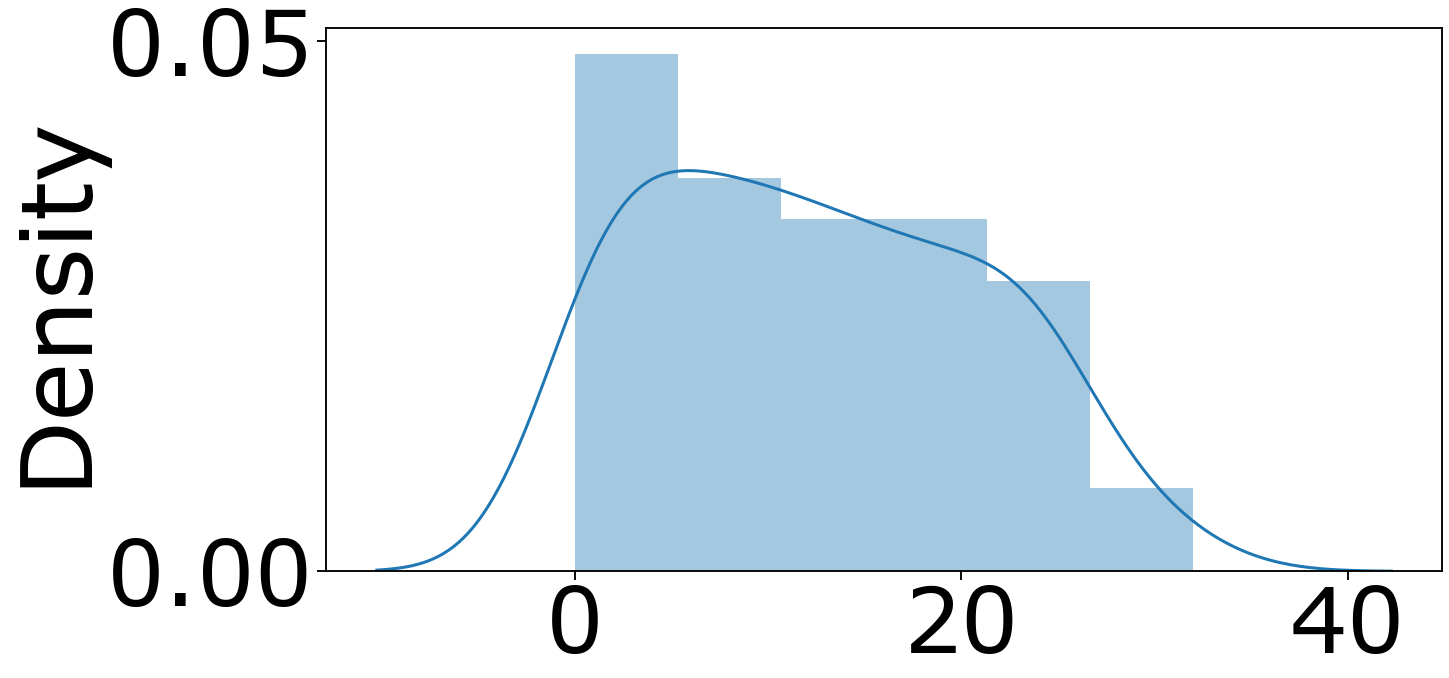

In [105]:
sns.distplot(avg_quic['total_score'].tolist())

          n         r          CI95%        r2   adj_r2     p-val   BF10  \
pearson  36 -0.069046  [-0.39, 0.27]  0.004767 -0.05555  0.689057  0.224   

           power  
pearson  0.06827  


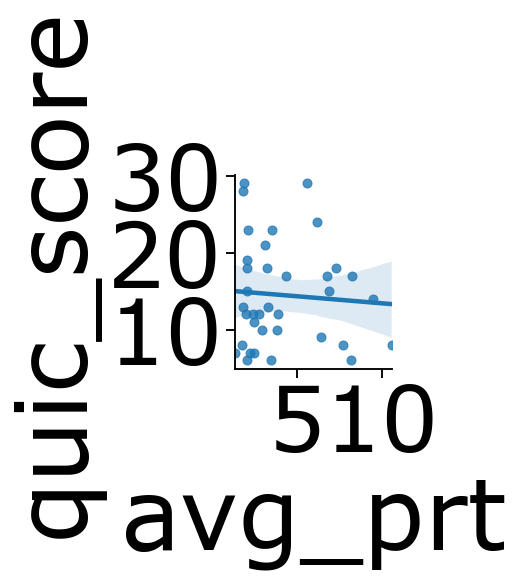

In [140]:
x=quic_df.query("quic_score>5")
import pingouin as pg
print(pg.corr(x['quic_score'],x['avg_prt']))

sns.lmplot(x='avg_prt',y='quic_score',data=quic_df.query("quic_score>5"))

# Difference in PRTs in rich galaxies 

In [44]:
print(pg.corr(quic_df['diff_rich'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich',y='log_quic',kind="reg",data=quic_df)
if savefig:
    plt.savefig(round +"/corr_diff_rich.png")

NameError: name 'quic_df' is not defined

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  51 -0.064401  [-0.33, 0.21]  0.004147 -0.037346  0.653446  0.073242
           n         r          CI95%       r2    adj_r2     p-val     power
spearman  54  0.119333  [-0.15, 0.38]  0.01424 -0.024417  0.390078  0.138424
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  49  0.080022  [-0.21, 0.35]  0.006404 -0.036796  0.584673  0.084802
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  53 -0.128271  [-0.39, 0.15]  0.016454 -0.022888  0.360008  0.150731


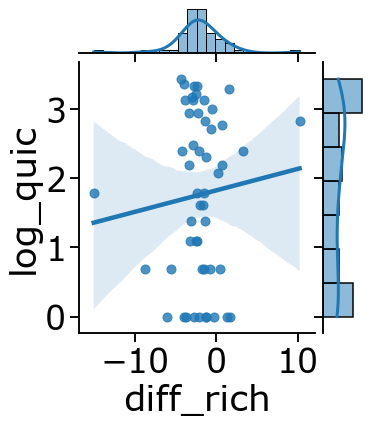

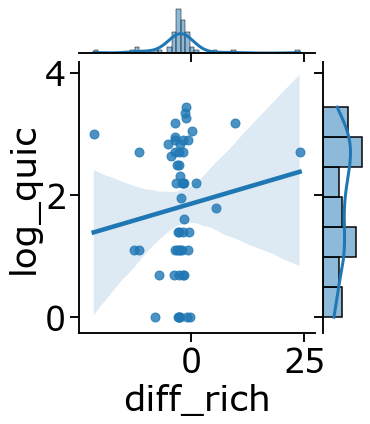

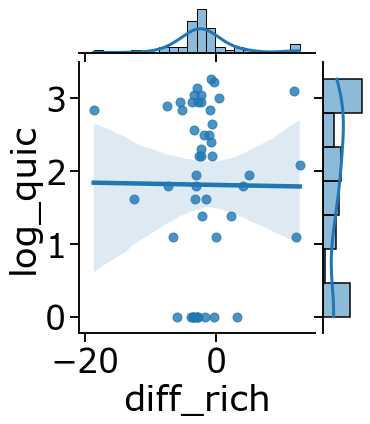

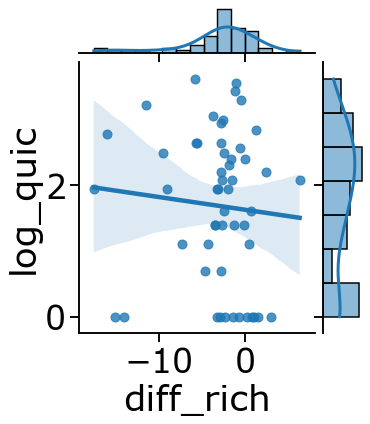

In [32]:
savefig=0
print(pg.corr(quic_1['diff_rich'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig("plots/corr_diff_rich_cond_1.png")

print(pg.corr(quic_2['diff_rich'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig("plots/corr_diff_rich_cond_2.png")

print(pg.corr(quic_5['diff_rich'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig("plots/corr_diff_rich_cond_5.png")
    
print(pg.corr(quic_6['diff_rich'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig("plots/corr_diff_rich_cond_6.png")

# Difference in poor galaxies 

            n         r          CI95%        r2    adj_r2     p-val    power
spearman  129 -0.050319  [-0.22, 0.12]  0.002532 -0.013301  0.571184  0.08746


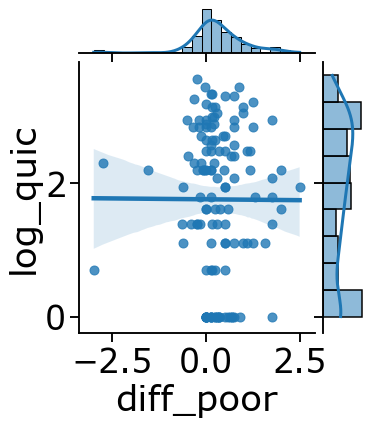

In [35]:
print(pg.corr(quic_df['diff_poor'],quic_df['log_quic'],method='spearman'))

sns.jointplot(x='diff_poor',y='log_quic',kind="reg",data=quic_df)
if savefig:
    plt.savefig(round +"/corr_diff_poor.png")

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  33  0.010425  [-0.33, 0.35]  0.000109 -0.066551  0.954086  0.049914
           n         r           CI95%        r2    adj_r2     p-val    power
spearman  33 -0.398587  [-0.65, -0.06]  0.158871  0.102796  0.021587  0.64853
           n         r          CI95%        r2    adj_r2     p-val    power
spearman  32  0.019083  [-0.33, 0.37]  0.000364 -0.068576  0.917434  0.05076
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  31  0.139504  [-0.23, 0.47]  0.019461 -0.050577  0.454173  0.116618


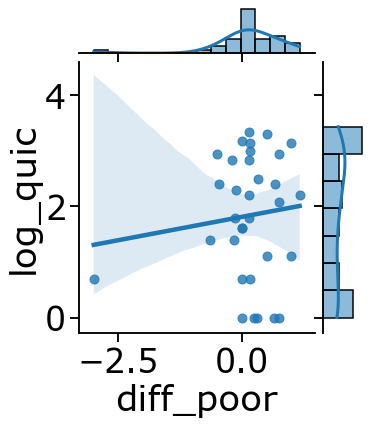

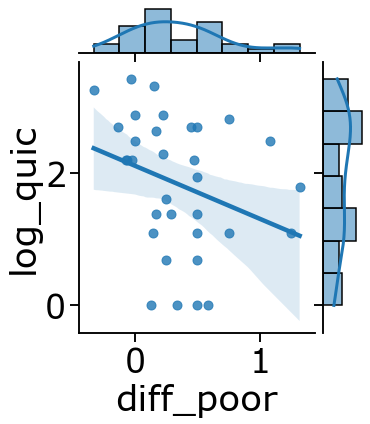

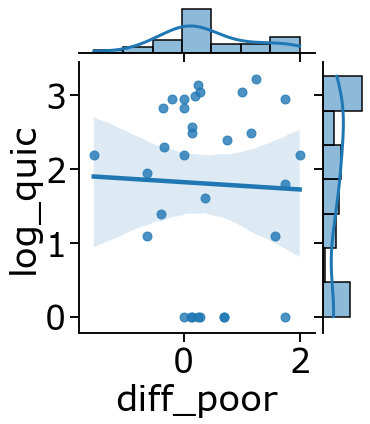

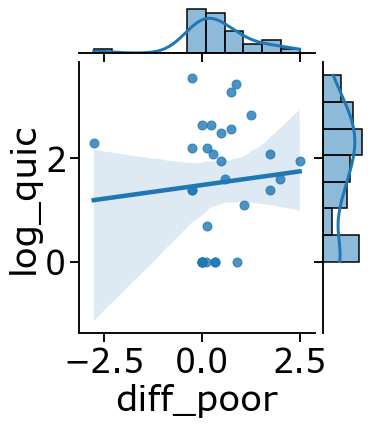

In [36]:
print(pg.corr(quic_1['diff_poor'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_poor',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig("plots/corr_diff_poor_cond_1.png")

print(pg.corr(quic_2['diff_poor'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_poor',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig("plots/corr_diff_poor_cond_2.png")


print(pg.corr(quic_5['diff_poor'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_poor',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig("plots/corr_diff_poor_cond_5.png")
    
print(pg.corr(quic_6['diff_poor'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_poor',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig("plots/corr_diff_poor_cond_6.png")

# Difference in neutral galaxies

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  59  0.101087  [-0.16, 0.35]  0.010219 -0.025131  0.446177  0.118903


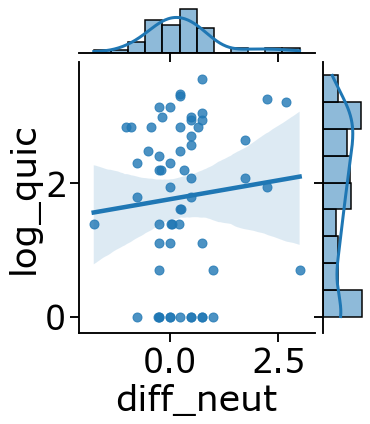

In [37]:
print(pg.corr(quic_df['diff_neut'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut',y='log_quic',kind="reg",data=quic_df)

if savefig:
    plt.savefig(round +"/corr_diff_neut.png")

           n         r          CI95%        r2    adj_r2    p-val     power
spearman  16 -0.283106  [-0.68, 0.25]  0.080149 -0.061366  0.28801  0.189435
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  15  0.114027  [-0.42, 0.59]  0.013002 -0.151497  0.685745  0.068396
           n         r          CI95%        r2    adj_r2    p-val     power
spearman  11  0.240275  [-0.42, 0.73]  0.057732 -0.177835  0.47667  0.110518
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  17  0.428669  [-0.07, 0.75]  0.183757  0.067151  0.086006  0.419865


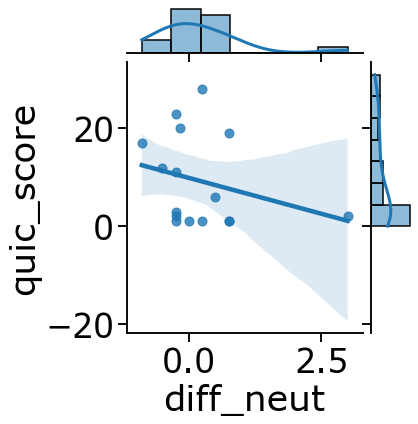

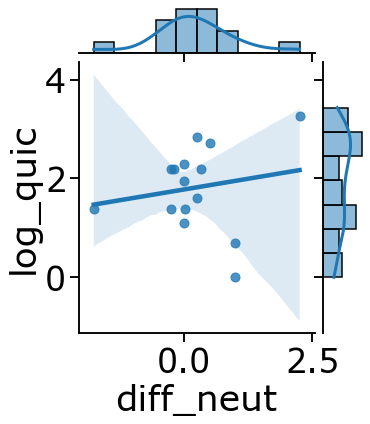

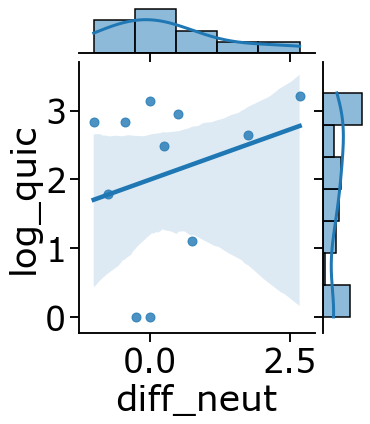

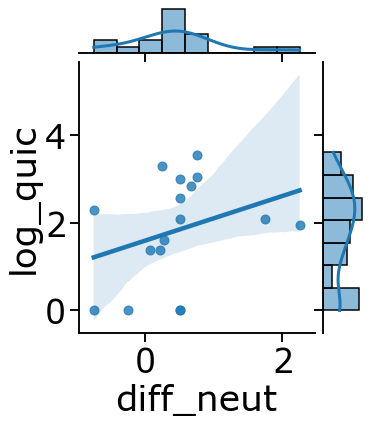

In [38]:
print(pg.corr(quic_1['diff_neut'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut',y='quic_score',kind="reg",data=quic_1)
if savefig:
    plt.savefig("plots/corr_diff_neut_cond_1.png")

print(pg.corr(quic_2['diff_neut'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig("plots/corr_diff_neut_cond_2.png")


print(pg.corr(quic_5['diff_neut'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig("plots/corr_diff_neut_cond_5.png")

print(pg.corr(quic_6['diff_neut'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig("plots/corr_diff_neut_cond_6.png")

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  69  0.061171  [-0.18, 0.29]  0.003742 -0.026448  0.617564  0.078934


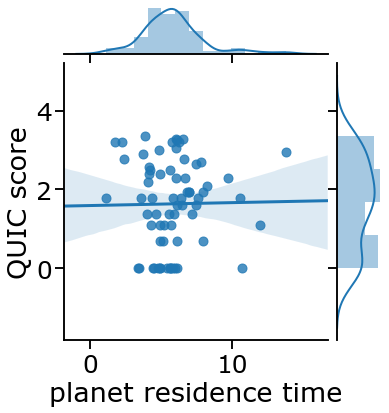

In [145]:
print(pg.corr(quic_df['avg_prt'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='avg_prt',y='log_quic',kind="reg",data=quic_df)
plt.ylabel("QUIC score")
plt.xlabel('planet residence time')
if savefig:
    plt.savefig(round +"/corr_prt_quic_all.png")

           n         r          CI95%        r2   adj_r2     p-val    power
spearman  55 -0.004569  [-0.27, 0.26]  0.000021 -0.03844  0.973591  0.04984
           n         r         CI95%        r2    adj_r2     p-val     power
spearman  61  0.167171  [-0.09, 0.4]  0.027946 -0.005573  0.197842  0.253148
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  56 -0.060309  [-0.32, 0.21]  0.003637 -0.033961  0.658825  0.072472
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  61 -0.099694  [-0.34, 0.16]  0.009939 -0.024201  0.444607  0.119388


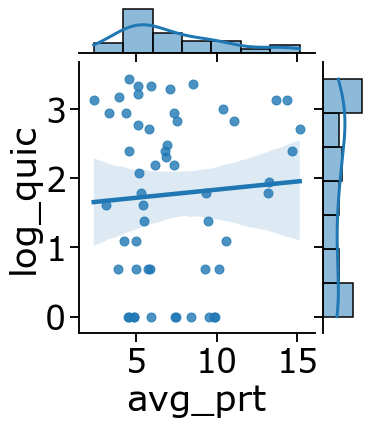

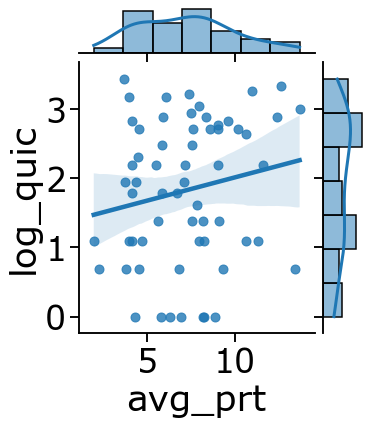

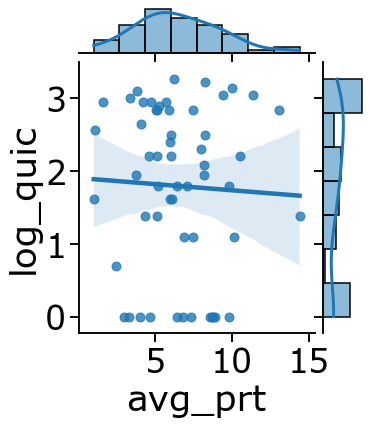

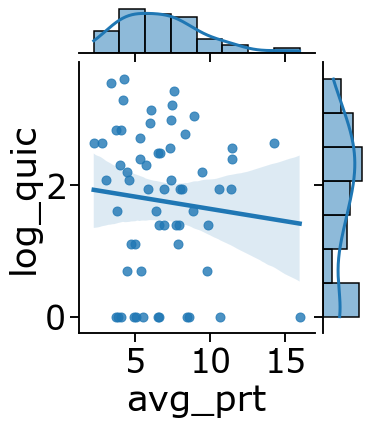

In [41]:
print(pg.corr(quic_1['avg_prt'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='avg_prt',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig(round +"/corr_avg_prt_cond_1.png")

print(pg.corr(quic_2['avg_prt'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='avg_prt',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig(round +"/corr_avg_prt_cond_2.png")


print(pg.corr(quic_5['avg_prt'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='avg_prt',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig(round +"/corr_avg-prt_cond_5.png")
    
    
print(pg.corr(quic_6['avg_prt'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='avg_prt',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig(round +"/corr_avg-prt_cond_6.png")

            n         r          CI95%        r2    adj_r2     p-val     power
spearman  207  0.017694  [-0.12, 0.15]  0.000313 -0.009488  0.800232  0.057301


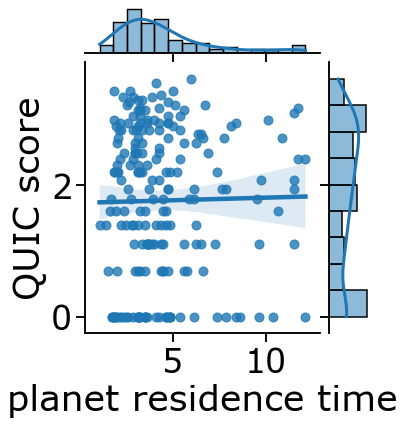

In [42]:
print(pg.corr(quic_df['neutral_prt'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='neutral_prt',y='log_quic',kind="reg",data=quic_df)
plt.ylabel("QUIC score")
plt.xlabel('planet residence time')
if savefig:
    plt.savefig(round +"/corr_neutral_prt_quic_all.png")

           n        r          CI95%        r2    adj_r2     p-val     power
spearman  51  0.00874  [-0.27, 0.28]  0.000076 -0.041587  0.951461  0.050119
           n         r         CI95%       r2    adj_r2     p-val     power
spearman  54 -0.069354  [-0.33, 0.2]  0.00481 -0.034217  0.618256  0.078795
           n         r          CI95%        r2    adj_r2    p-val     power
spearman  49  0.055739  [-0.23, 0.33]  0.003107 -0.040236  0.70365  0.066526
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  53  0.121786  [-0.15, 0.38]  0.014832 -0.024575  0.385005  0.140408


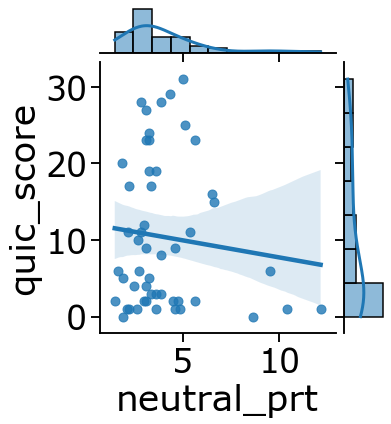

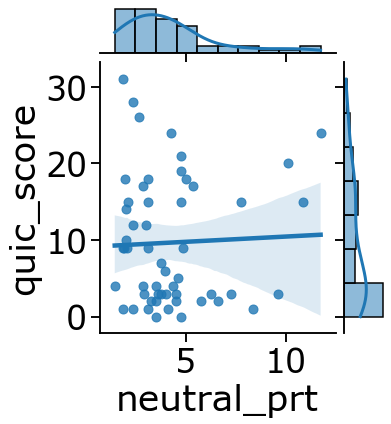

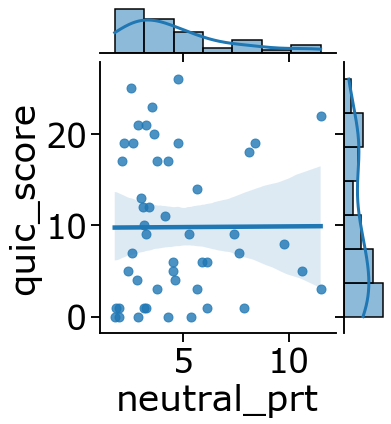

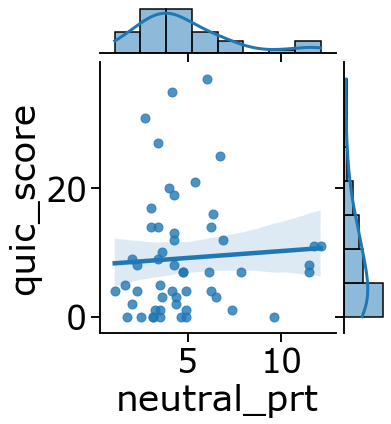

In [43]:
print(pg.corr(quic_1['neutral_prt'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='neutral_prt',y='quic_score',kind="reg",data=quic_1)
if savefig:
    plt.savefig("plots/corr_neutral_prt_cond_1.png")

print(pg.corr(quic_2['neutral_prt'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='neutral_prt',y='quic_score',kind="reg",data=quic_2)
if savefig:
    plt.savefig("plots/corr_neutral_prt_cond_2.png")


print(pg.corr(quic_5['neutral_prt'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='neutral_prt',y='quic_score',kind="reg",data=quic_5)
if savefig:
    plt.savefig("plots/corr_neutral_prt_cond_5.png")

print(pg.corr(quic_6['neutral_prt'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='neutral_prt',y='quic_score',kind="reg",data=quic_6)
if savefig:
    plt.savefig("plots/corr_neutral_prt_cond_6.png")

            n         r          CI95%        r2    adj_r2     p-val     power
spearman  207  0.076033  [-0.06, 0.21]  0.005781 -0.003966  0.276206  0.193312


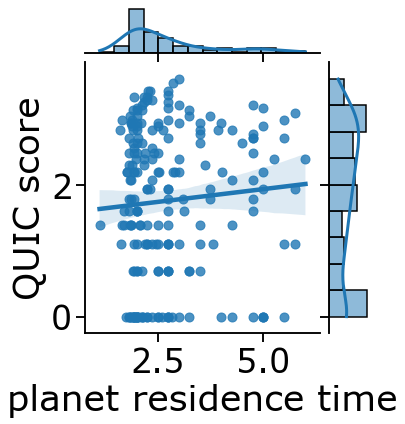

In [44]:
print(pg.corr(quic_df['poor_prt'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='poor_prt',y='log_quic',kind="reg",data=quic_df)
plt.ylabel("QUIC score")
plt.xlabel('planet residence time')
if savefig:
    plt.savefig("plots/corr_poor_prt_quic_all.png")

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  51 -0.147165  [-0.41, 0.13]  0.021658 -0.019107  0.302757  0.178739
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  54  0.108973  [-0.16, 0.37]  0.011875 -0.026875  0.432814  0.123207
           n         r         CI95%        r2    adj_r2     p-val     power
spearman  49  0.023859  [-0.26, 0.3]  0.000569 -0.042884  0.870736  0.052736
           n         r         CI95%        r2    adj_r2     p-val     power
spearman  53  0.284239  [0.02, 0.51]  0.080792  0.044023  0.039141  0.549209


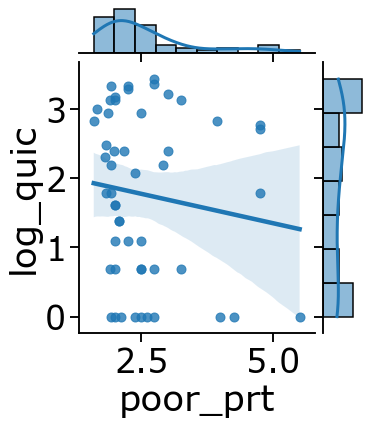

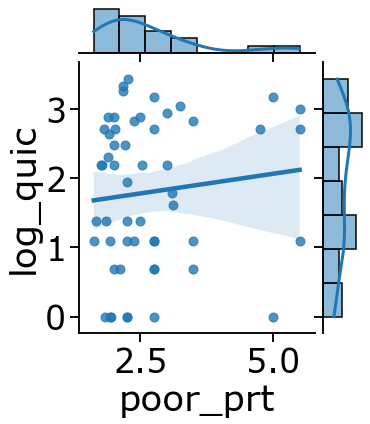

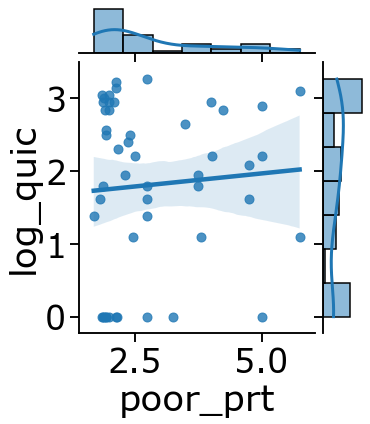

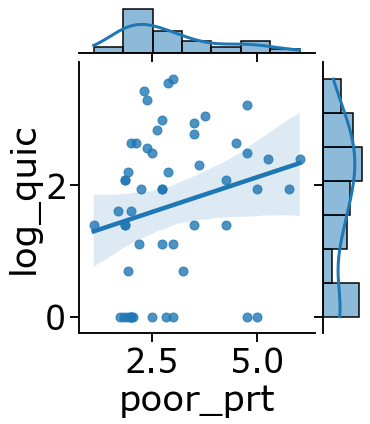

In [46]:
print(pg.corr(quic_1['poor_prt'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='poor_prt',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig(round +"/corr_poor_prt_cond_1.png")

print(pg.corr(quic_2['poor_prt'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='poor_prt',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig(round +"/corr_poor_prt_cond_2.png")


print(pg.corr(quic_5['poor_prt'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='poor_prt',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig(round +"/corr_poor_prt_cond_5.png")
    
    
print(pg.corr(quic_6['poor_prt'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='poor_prt',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig(round +"/corr_poor_prt_cond_6.png")

# Correlations relative to MVT

In [47]:
x1 = avgd_data_post.query('galaxy == 2 and preced_gal == 0').groupby('sub_num').prt_rel_mvt.mean()
x2 = avgd_data_post.query('galaxy == 2 and preced_gal == 1').groupby('sub_num').prt_rel_mvt.mean()
diff_rich = x1 - x2


x1 = avgd_data_post.query('galaxy == 0 and preced_gal == 1').groupby('sub_num').prt_rel_mvt.mean()
x2 = avgd_data_post.query('galaxy == 0 and preced_gal == 2').groupby('sub_num').prt_rel_mvt.mean()
diff_poor = x1-x2

x1 = avgd_data_post.query('galaxy == 1 and preced_gal == 2').groupby('sub_num').prt_rel_mvt.mean()
x2 = avgd_data_post.query('galaxy == 1 and preced_gal == 0').groupby('sub_num').prt_rel_mvt.mean()
diff_neut = x1-x2


quic_df['diff_rich_rel_mvt'] = diff_rich
quic_df['diff_poor_rel_mvt'] = diff_poor
quic_df['diff_neut_rel_mvt'] = diff_neut
quic_df["neutral_prt_rel_mvt"] = avgd_data_post.query("galaxy == 1").groupby("sub_num").prt_rel_mvt.mean()
quic_df["poor_prt_rel_mvt"] = avgd_data_post.query("galaxy == 0").groupby("sub_num").prt_rel_mvt.mean()

In [48]:
quic_1 = quic_df.loc[quic_df['condition']==1]
quic_2 = quic_df.loc[quic_df['condition']==2]
quic_5 = quic_df.loc[quic_df['condition']==5]
quic_6 = quic_df.loc[quic_df['condition']==6]

# diff rich

            n         r          CI95%       r2    adj_r2    p-val     power
spearman  207 -0.075895  [-0.21, 0.06]  0.00576 -0.003987  0.27708  0.192778


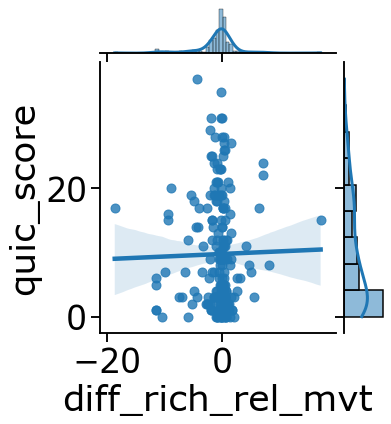

In [74]:
print(pg.corr(quic_df['diff_rich_rel_mvt'],quic_df['quic_score'],method='spearman'))
sns.jointplot(x='diff_rich_rel_mvt',y='quic_score',kind="reg",data=quic_df)
if savefig:
    plt.savefig(round +"/corr_diff_rich_rel_prt.png")

           n        r         CI95%        r2    adj_r2     p-val     power
spearman  51 -0.08345  [-0.35, 0.2]  0.006964 -0.034413  0.560436  0.089625
           n         r          CI95%       r2    adj_r2    p-val     power
spearman  54  0.010936  [-0.26, 0.28]  0.00012 -0.039091  0.93744  0.050418
           n         r          CI95%        r2    adj_r2    p-val     power
spearman  49 -0.060236  [-0.34, 0.22]  0.003628 -0.039692  0.68097  0.069391
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  53 -0.183408  [-0.43, 0.09]  0.033638 -0.005016  0.188653  0.262143


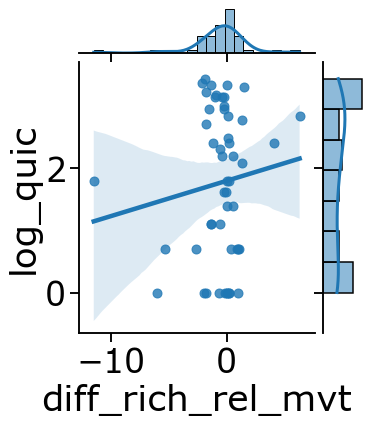

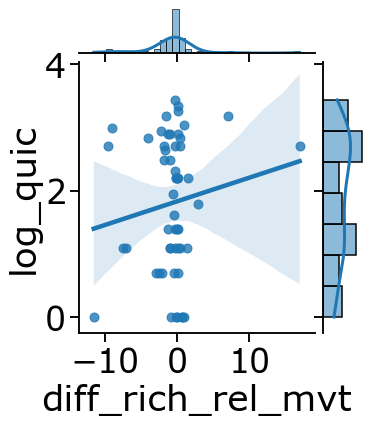

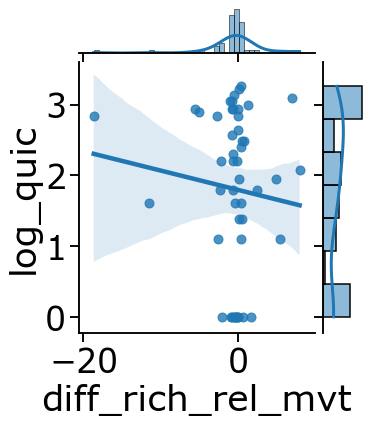

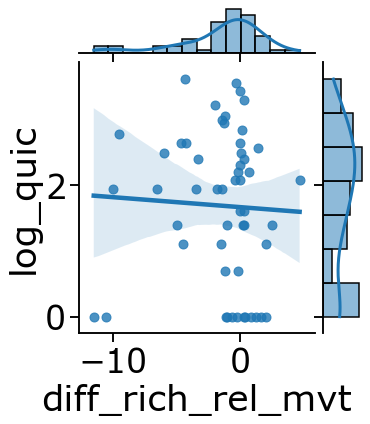

In [75]:
print(pg.corr(quic_1['diff_rich_rel_mvt'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_rel_mvt',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig("plots/corr_diff_rich_rel_mvt_cond_1.png")

print(pg.corr(quic_2['diff_rich_rel_mvt'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_rel_mvt',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig("plots/corr_diff_rich_rel_mvt_cond_2.png")

print(pg.corr(quic_5['diff_rich_rel_mvt'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_rel_mvt',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig("plots/corr_diff_rich_rel_mvt_cond_5.png")
    
print(pg.corr(quic_6['diff_rich_rel_mvt'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_rel_mvt',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig("plots/corr_diff_rich_rel_mvt_cond_6.png")

# diff poor

            n         r          CI95%        r2    adj_r2     p-val     power
spearman  129 -0.087396  [-0.26, 0.09]  0.007638 -0.008114  0.324697  0.166709


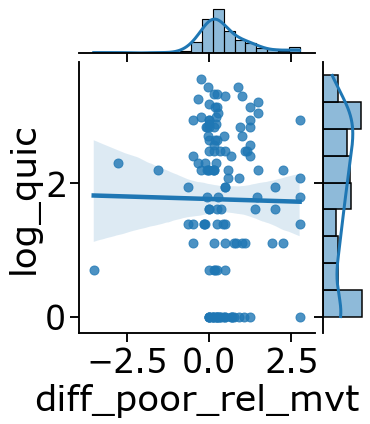

In [76]:
print(pg.corr(quic_df['diff_poor_rel_mvt'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='diff_poor_rel_mvt',y='log_quic',kind="reg",data=quic_df)
if savefig:
    plt.savefig(round +"/corr_poor_poor_rel_mvt.png")

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  33 -0.039547  [-0.38, 0.31]  0.001564 -0.064998  0.827037  0.055067
           n         r           CI95%        r2    adj_r2     p-val     power
spearman  33 -0.368169  [-0.63, -0.03]  0.135548  0.077918  0.035022  0.572773
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  32 -0.017437  [-0.36, 0.33]  0.000304 -0.068641  0.924537  0.050555
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  31  0.100519  [-0.26, 0.44]  0.010104 -0.060603  0.590556  0.083652


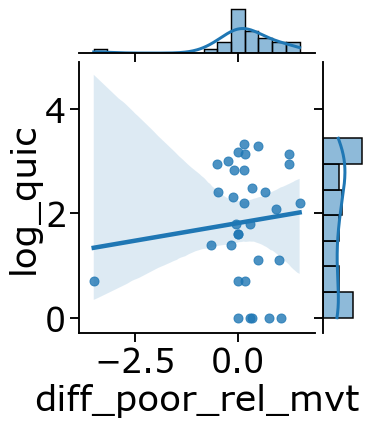

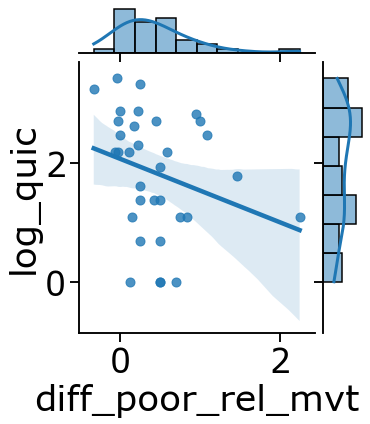

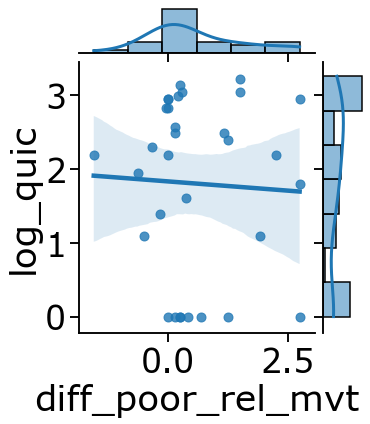

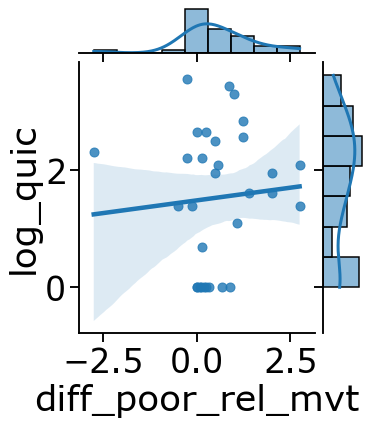

In [77]:
print(pg.corr(quic_1['diff_poor_rel_mvt'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_poor_rel_mvt',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig("plots/corr_diff_poor_rel_mvt_cond_1.png")

print(pg.corr(quic_2['diff_poor_rel_mvt'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_poor_rel_mvt',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig("plots/corr_diff_poor_rel_mvt_cond_2.png")

print(pg.corr(quic_5['diff_poor_rel_mvt'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_poor_rel_mvt',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig("plots/corr_diff_poor_rel_mvt_cond_5.png")
    
    
print(pg.corr(quic_6['diff_poor_rel_mvt'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_poor_rel_mvt',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig("plots/corr_diff_poor_rel_mvt_cond_6.png")

# diff neutral

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  59  0.078147  [-0.18, 0.33]  0.006107 -0.029389  0.556321  0.090488


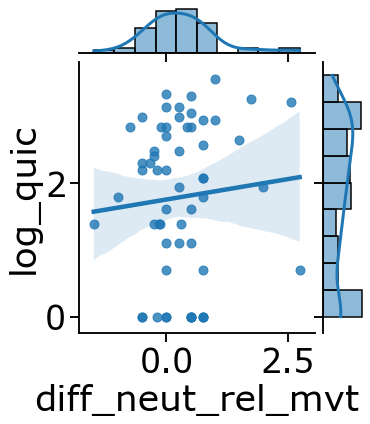

In [53]:
print(pg.corr(quic_df['diff_neut_rel_mvt'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_rel_mvt',y='log_quic',kind="reg",data=quic_df)
if savefig:
    plt.savefig(round +"/corr_diff_neut_rel_mvt.png")

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  16 -0.240305  [-0.66, 0.29]  0.057746 -0.087216  0.369993  0.147689
           n         r         CI95%        r2    adj_r2     p-val     power
spearman  15 -0.018083  [-0.53, 0.5]  0.000327 -0.166285  0.948998  0.049542
           n        r          CI95%        r2    adj_r2     p-val     power
spearman  11  0.30115  [-0.36, 0.76]  0.090691 -0.136636  0.368161  0.149224
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  17  0.262208  [-0.25, 0.66]  0.068753 -0.064282  0.309299  0.176991


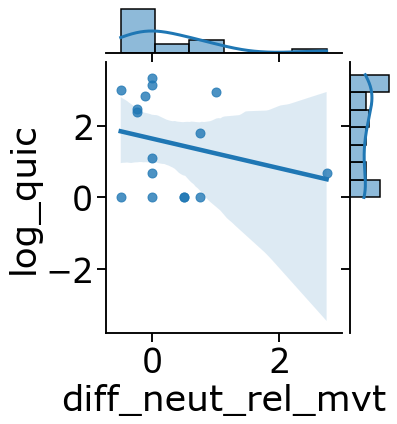

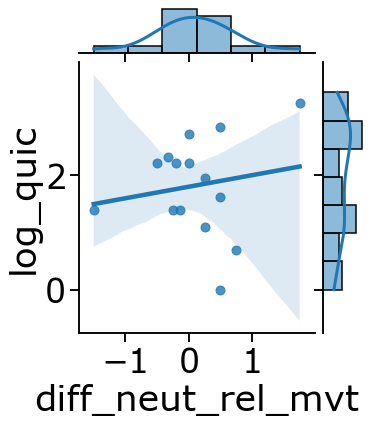

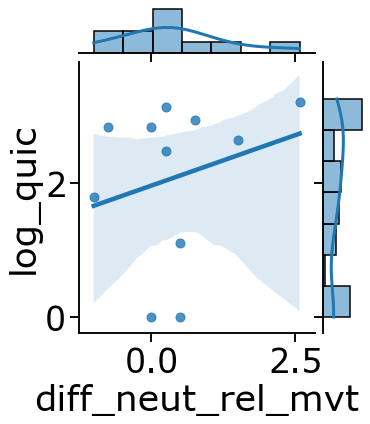

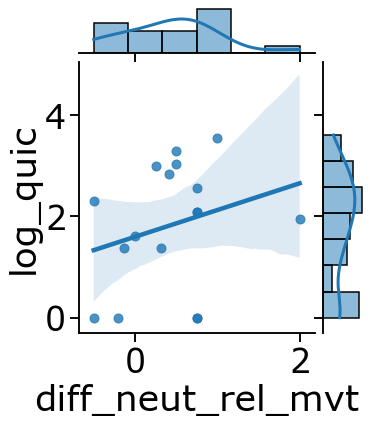

In [54]:
print(pg.corr(quic_1['diff_neut_rel_mvt'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_rel_mvt',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig("plots/corr_diff_neut_rel_mvt_cond_1.png")

print(pg.corr(quic_2['diff_neut_rel_mvt'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_rel_mvt',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig("plots/corr_diff_neut_rel_mvt_cond_2.png")

print(pg.corr(quic_5['diff_neut_rel_mvt'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_rel_mvt',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig("plots/corr_diff_neut_rel_mvt_cond_5.png")
    
print(pg.corr(quic_6['diff_neut_rel_mvt'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_rel_mvt',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig("plots/corr_diff_neut_rel_mvt_cond_6.png")

# difference between average neutral and average poor

In [55]:
quic_df["diff_neut_poor"] = avgd_data_post.query("galaxy == 1").groupby("sub_num").prt.mean() - avgd_data_post.query("galaxy == 0").groupby("sub_num").prt.mean()

In [56]:
quic_1 = quic_df.loc[quic_df['condition']==1]
quic_2 = quic_df.loc[quic_df['condition']==2]
quic_5 = quic_df.loc[quic_df['condition']==5]
quic_6 = quic_df.loc[quic_df['condition']==6]

            n         r         CI95%        r2    adj_r2     p-val     power
spearman  207 -0.035004  [-0.17, 0.1]  0.001225 -0.008567  0.616566  0.079156


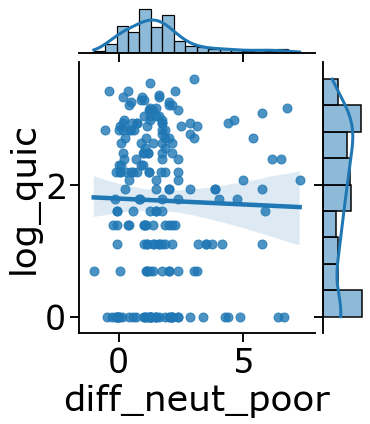

In [57]:
print(pg.corr(quic_df['diff_neut_poor'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor',y='log_quic',kind="reg",data=quic_df)
if savefig:
    plt.savefig(round +"/corr_ddiff_neut_poor.png")

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  51 -0.007918  [-0.28, 0.27]  0.000063 -0.041601  0.956023  0.050042
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  54 -0.159797  [-0.41, 0.11]  0.025535 -0.012679  0.248408  0.212557
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  49  0.074443  [-0.21, 0.35]  0.005542 -0.037696  0.611206  0.079987
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  53  0.007413  [-0.26, 0.28]  0.000055 -0.039943  0.957984  0.050023


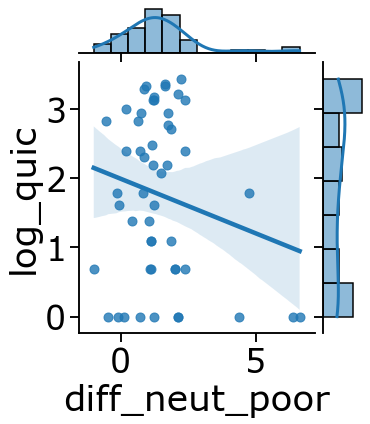

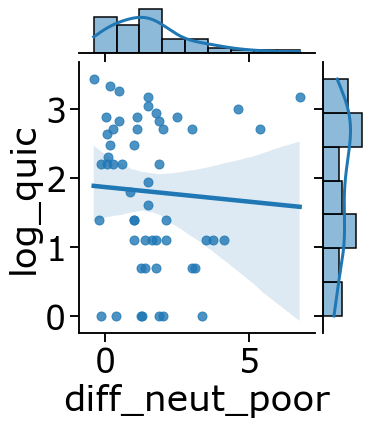

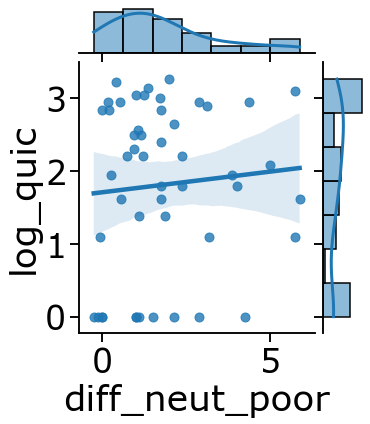

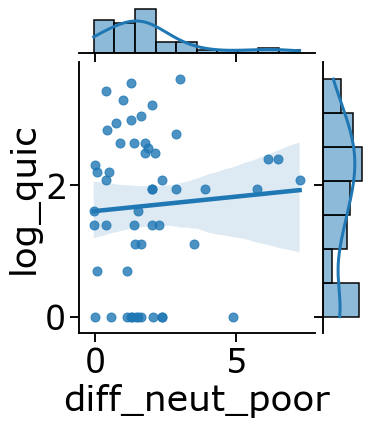

In [58]:
print(pg.corr(quic_1['diff_neut_poor'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig("plots/corr_diff_neut_poor_cond_1.png")

print(pg.corr(quic_2['diff_neut_poor'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig("plots/corr_diff_neut_poor_cond_2.png")

print(pg.corr(quic_5['diff_neut_poor'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig("plots/corr_diff_neut_poor_cond_5.png")
    
    
print(pg.corr(quic_6['diff_neut_poor'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig("plots/corr_diff_neut_poor_cond_6.png")

# difference between average neutral and average rich

In [78]:
quic_df["diff_rich_neut"] = avgd_data_post.query("galaxy == 2").groupby("sub_num").prt.mean() - avgd_data_post.query("galaxy == 1").groupby("sub_num").prt.mean()

In [79]:
quic_1 = quic_df.loc[quic_df['condition']==1]
quic_2 = quic_df.loc[quic_df['condition']==2]
quic_5 = quic_df.loc[quic_df['condition']==5]
quic_6 = quic_df.loc[quic_df['condition']==6]

            n         r          CI95%        r2    adj_r2    p-val     power
spearman  207 -0.013378  [-0.15, 0.12]  0.000179 -0.009623  0.84828  0.054132


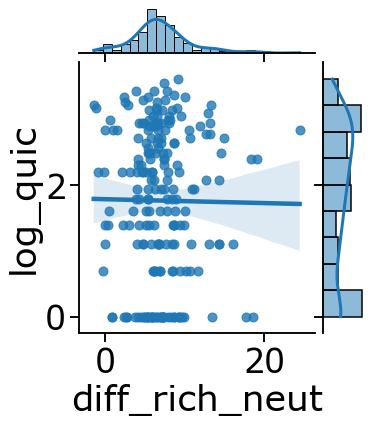

In [80]:
print(pg.corr(quic_df['diff_rich_neut'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut',y='log_quic',kind="reg",data=quic_df)
if savefig:
    plt.savefig(round +"/corr_diff_rich_neut.png")

           n         r         CI95%       r2    adj_r2     p-val     power
spearman  51 -0.076221  [-0.34, 0.2]  0.00581 -0.035615  0.594999  0.082876
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  54 -0.154598  [-0.41, 0.12]  0.023901 -0.014378  0.264334  0.201729
           n         r          CI95%        r2    adj_r2     p-val     power
spearman  49  0.198536  [-0.09, 0.45]  0.039416 -0.002348  0.171459  0.280016
           n        r          CI95%        r2    adj_r2     p-val     power
spearman  53  0.00954  [-0.26, 0.28]  0.000091 -0.039905  0.945944  0.050233


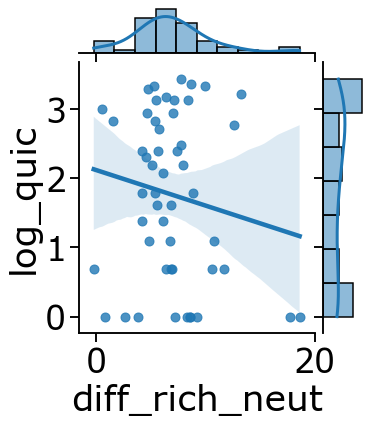

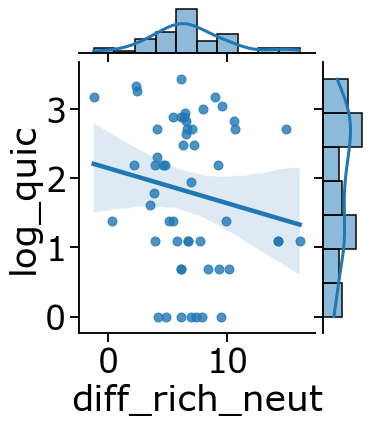

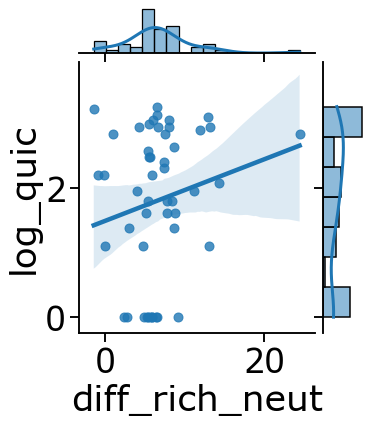

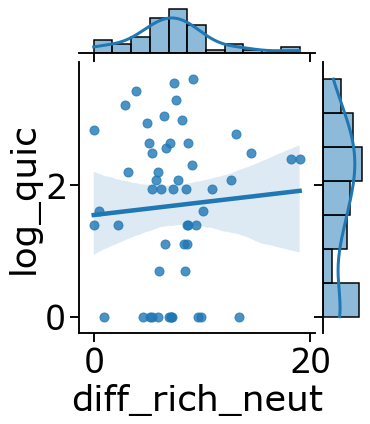

In [81]:
print(pg.corr(quic_1['diff_rich_neut'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig("plots/corr_diff_rich_neut_cond_1.png")

print(pg.corr(quic_2['diff_rich_neut'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig("plots/corr_diff_rich_neut_cond_2.png")

print(pg.corr(quic_5['diff_rich_neut'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig("plots/corr_diff_rich_neut_cond_5.png")
    
print(pg.corr(quic_6['diff_rich_neut'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig("plots/corr_diff_rich_neut_cond_6.png")

# difference between average neutral and average poor relative to to mvt

In [64]:
quic_df["diff_neut_poor_rel_mvt"] = avgd_data_post.query("galaxy == 1").groupby("sub_num").prt_rel_mvt.mean() - avgd_data_post.query("galaxy == 0").groupby("sub_num").prt_rel_mvt.mean()

quic_1 = quic_df.loc[quic_df['condition']==1]
quic_2 = quic_df.loc[quic_df['condition']==2]
quic_5 = quic_df.loc[quic_df['condition']==5]
quic_6 = quic_df.loc[quic_df['condition']==6]

            n         r         CI95%        r2    adj_r2   p-val    power
spearman  207 -0.039276  [-0.17, 0.1]  0.001543 -0.008246  0.5742  0.08687


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


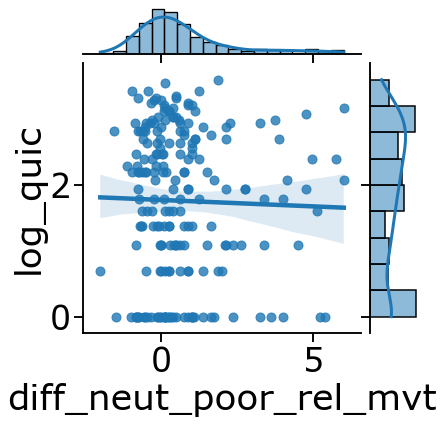

In [65]:
print(pg.corr(quic_df['diff_neut_poor_rel_mvt'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor_rel_mvt',y='log_quic',kind="reg",data=quic_df)
if savefig:
    plt.savefig(round +"/corr_ddiff_neut_poor_rel_mvt.png")

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  51 -0.004528  [-0.28, 0.27]  0.000021 -0.041645  0.974844  0.049806


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


           n         r          CI95%        r2    adj_r2     p-val     power
spearman  54 -0.178056  [-0.43, 0.09]  0.031704 -0.006268  0.197694  0.253521


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


           n         r          CI95%        r2    adj_r2     p-val     power
spearman  49  0.066338  [-0.22, 0.34]  0.004401 -0.038886  0.650639  0.073652


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


           n         r          CI95%        r2    adj_r2     p-val     power
spearman  53 -0.007192  [-0.28, 0.26]  0.000052 -0.039946  0.959239  0.050004


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


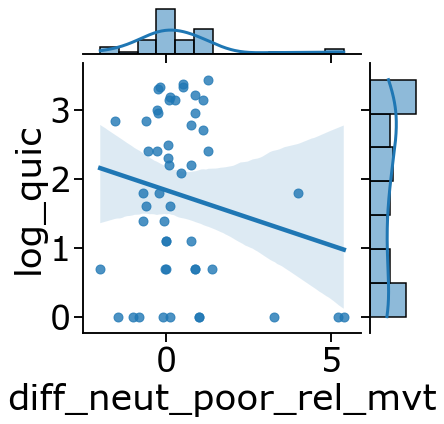

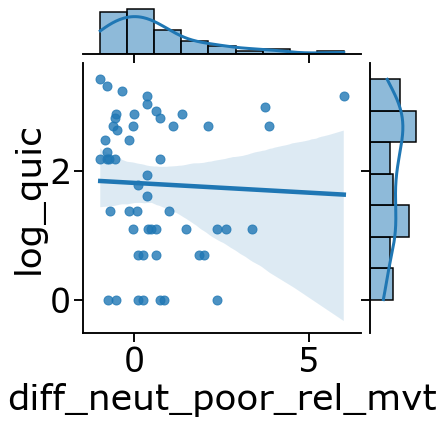

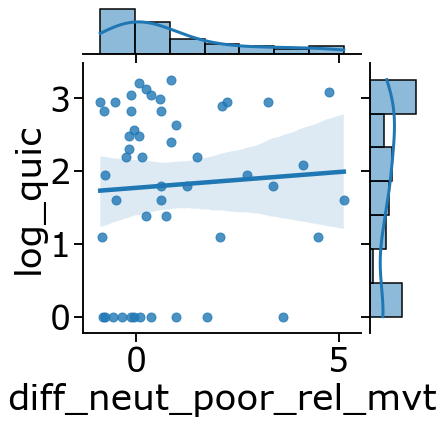

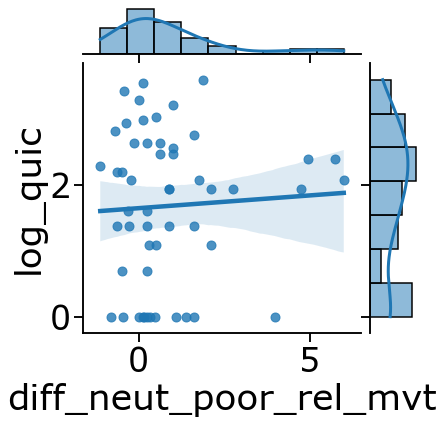

In [67]:
print(pg.corr(quic_1['diff_neut_poor_rel_mvt'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor_rel_mvt',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig(round +"/corr_diff_neut_poor_rel_mvt_cond_1.png")

print(pg.corr(quic_2['diff_neut_poor_rel_mvt'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor_rel_mvt',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig(round +"/corr_diff_neut_poor_rel_mvt_cond_2.png")

print(pg.corr(quic_5['diff_neut_poor_rel_mvt'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor_rel_mvt',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig(round +"/corr_diff_neut_poor_rel_mvt_cond_5.png")
    
print(pg.corr(quic_6['diff_neut_poor_rel_mvt'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_neut_poor_rel_mvt',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig(round +"/corr_diff_neut_poor_rel_mvt_cond_6.png")

# difference between average neutral and average rich relative to mvt

In [69]:
quic_df["diff_rich_neut_rel_mvt"] = avgd_data_post.query("galaxy == 2").groupby("sub_num").prt_rel_mvt.mean() - avgd_data_post.query("galaxy == 1").groupby("sub_num").prt_rel_mvt.mean()

quic_1 = quic_df.loc[quic_df['condition']==1]
quic_2 = quic_df.loc[quic_df['condition']==2]
quic_5 = quic_df.loc[quic_df['condition']==5]
quic_6 = quic_df.loc[quic_df['condition']==6]

            n         r          CI95%        r2    adj_r2     p-val     power
spearman  207  0.008235  [-0.13, 0.14]  0.000068 -0.009735  0.906252  0.051515


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


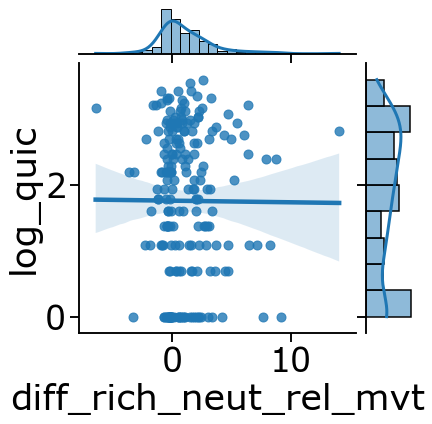

In [70]:
print(pg.corr(quic_df['diff_rich_neut_rel_mvt'],quic_df['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut_rel_mvt',y='log_quic',kind="reg",data=quic_df)
if savefig:
    plt.savefig(round +"/corr_diff_rich_neut_rel_mvt.png")

           n         r          CI95%        r2    adj_r2     p-val     power
spearman  51 -0.085771  [-0.35, 0.19]  0.007357 -0.034003  0.549541  0.091933


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


           n         r          CI95%        r2    adj_r2     p-val     power
spearman  54 -0.130142  [-0.38, 0.14]  0.016937 -0.021615  0.348262  0.155933


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


           n         r          CI95%        r2   adj_r2     p-val     power
spearman  49  0.266587  [-0.02, 0.51]  0.071068  0.03068  0.064084  0.463792


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


           n         r          CI95%        r2    adj_r2     p-val     power
spearman  53 -0.018513  [-0.29, 0.25]  0.000343 -0.039644  0.895321  0.051699


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/axisgrid.py:1629: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


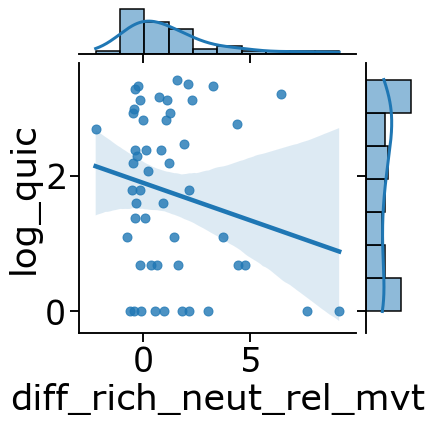

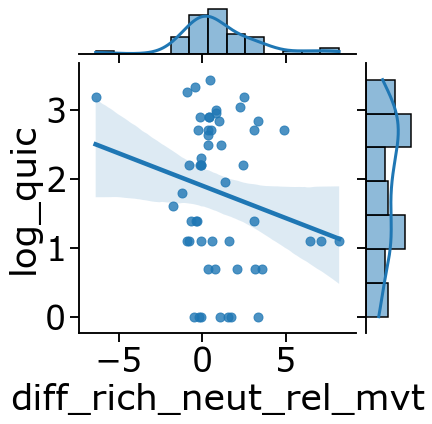

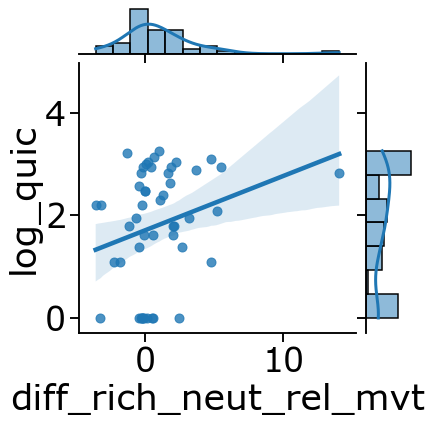

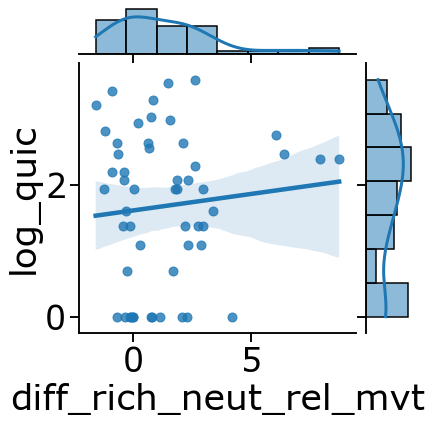

In [73]:
print(pg.corr(quic_1['diff_rich_neut_rel_mvt'],quic_1['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut_rel_mvt',y='log_quic',kind="reg",data=quic_1)
if savefig:
    plt.savefig(round +"/corr_diff_rich_neut_rel_mvt_cond_1.png")

print(pg.corr(quic_2['diff_rich_neut_rel_mvt'],quic_2['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut_rel_mvt',y='log_quic',kind="reg",data=quic_2)
if savefig:
    plt.savefig(round +"/corr_diff_rich_neut_rel_mvt_cond_2.png")

print(pg.corr(quic_5['diff_rich_neut_rel_mvt'],quic_5['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut_rel_mvt',y='log_quic',kind="reg",data=quic_5)
if savefig:
    plt.savefig(round +"/corr_diff_rich_neut_rel_mvt_cond_5.png")
    
print(pg.corr(quic_6['diff_rich_neut_rel_mvt'],quic_6['log_quic'],method='spearman'))
sns.jointplot(x='diff_rich_neut_rel_mvt',y='log_quic',kind="reg",data=quic_6)
if savefig:
    plt.savefig(round +"/corr_diff_rich_neut_rel_mvt_cond_6.png")

In [1]:
quic_df["diff_rich_neut_rel_mvt"] = avgd_data.query("galaxy == 1 & prior_galaxy==2").groupby("sub_num").prt_rel_mvt.mean() - avgd_data.query("galaxy == 1 & prior_galaxy==0").groupby("sub_num").prt_rel_mvt.mean()


NameError: name 'avgd_data' is not defined

In [163]:
high_quic = quic_df.loc[quic_df['quic_score']>13].reset_index(drop=True)
low_quic = quic_df.loc[quic_df['quic_score']<3].reset_index(drop=True)

In [164]:
high_quic['group'] = 'high_quic'
low_quic['group'] = 'low_quic'
sep_quic = pd.concat([high_quic,low_quic],ignore_index=True)

In [204]:
all_data.to_csv('all_data_dataset_2022.csv')

In [182]:
all_data.query("sub_num==1").condition.tolist()[0]

5

In [63]:
def _sim(cond):
    condition = dc.condition_type(cond)
    exp_struc, rho_0,decay = dc.load_data(condition)
    
    total_treasure = 0
    total_time = 10
    max_block_time = 360

    harvest_time = 2
    travel_time =15.5
    iti = 1.5

    k=[1]
    prts=[]
    planet_vis = []

    for block in range(5):
        t = (5.5 + harvest_time + iti)
        planet = 0
        r = 0
        next_reward = rho_0[block][planet]
        block_prts = []
        block_planet_vis = []
        while t < max_block_time:
            total_treasure += next_reward

            if r > 0:
                k.append(decay[block][planet][r-1])

            v_stay = next_reward*(sum(k)/len(k))
            v_leave = ((total_treasure/total_time)*(harvest_time+iti))

            if v_stay > v_leave:
                choice = 1
            else:
                choice=0


            if choice == 0:
                block_prts.append(r)
                r=0
                block_planet_vis.append(planet)
                planet += 1
                next_reward = rho_0[block][planet]
                t += travel_time
                total_time += travel_time
            else:
                next_reward = next_reward*decay[block][planet][r]
                r+=1
                t += (harvest_time + iti)
                total_time += (harvest_time + iti)
        print('global_rr: ' + str(total_treasure/total_time))
        prts.append(block_prts)
        planet_vis.append(block_planet_vis)
    return total_treasure,prts,planet_vis

global_rr: 8.9541385571695
global_rr: 9.7324106260411
global_rr: 9.802297691870198
global_rr: 10.437378820318687
global_rr: 10.671937962921824
[[1, 1, 1, 1, 1, 1, 7, 9, 8, 1, 1, 1, 1, 1], [7, 9, 5, 9, 1, 1, 1, 1, 1, 2, 2, 2], [2, 2, 2, 2, 1, 1, 1, 1, 7, 7, 5, 7], [7, 15, 10, 5, 11, 1, 1, 1, 1, 1], [2, 2, 2, 2, 9, 10, 6, 8, 7, 1, 1]]


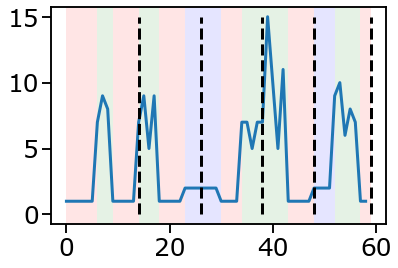

In [64]:
cond_num = 1
total_treasure,prts,planet_vis=_sim(cond_num )

condition = dc.condition_type(cond_num )

exp_struc, rho_0,decay = dc.load_data(condition)


plt.plot(dc.flatten_list(prts))
plt.plot([len(prts[0]),len(prts[0])],[0,15],'k--')
plt.plot([len(prts[1])+len(prts[0]),len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[2])+len(prts[1])+len(prts[0]),len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0]),len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[4])+len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0]),len(prts[4])+len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')

for block in range(5):
    for planet in range(len(prts[block])):
        planet_num = planet + sum([planet_vis[i][-1] + 1 for i in range(block)])
        galaxy = dc.flatten_list(exp_struc[block])[planet]
        if galaxy == 0:
            plt.axvspan(planet_num, planet_num+1, facecolor='r', alpha=0.1)
        elif galaxy == 1:
            plt.axvspan(planet_num, planet_num+1, facecolor='b', alpha=0.1)
        elif galaxy == 2:
            plt.axvspan(planet_num, planet_num+1, facecolor='g', alpha=0.1)
print(prts)

global_rr: 10.09409566068481
global_rr: 10.284472454679772
global_rr: 10.176058125800438
global_rr: 10.716055356421476
global_rr: 10.894454924663826
[[1, 1, 1, 1, 1, 1, 1, 1, 2, 10, 6, 9, 4], [6, 5, 12, 5, 3, 2, 2, 2, 2, 1, 1, 1], [2, 2, 2, 2, 1, 1, 1, 1, 7, 7, 5, 6], [7, 14, 10, 5, 11, 1, 1, 1, 1, 1], [2, 2, 2, 2, 9, 10, 6, 8, 7, 1, 1]]


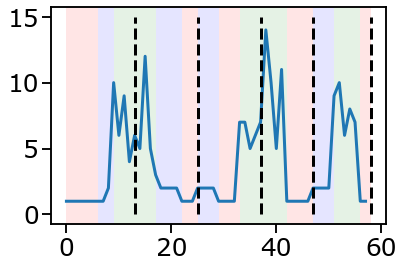

In [65]:
cond_num = 2
total_treasure,prts,planet_vis=_sim(cond_num )

condition = dc.condition_type(cond_num )

exp_struc, rho_0,decay = dc.load_data(condition)


plt.plot(dc.flatten_list(prts))
plt.plot([len(prts[0]),len(prts[0])],[0,15],'k--')
plt.plot([len(prts[1])+len(prts[0]),len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[2])+len(prts[1])+len(prts[0]),len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0]),len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[4])+len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0]),len(prts[4])+len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')

for block in range(5):
    for planet in range(len(prts[block])):
        planet_num = planet + sum([planet_vis[i][-1] + 1 for i in range(block)])
        galaxy = dc.flatten_list(exp_struc[block])[planet]
        if galaxy == 0:
            plt.axvspan(planet_num, planet_num+1, facecolor='r', alpha=0.1)
        elif galaxy == 1:
            plt.axvspan(planet_num, planet_num+1, facecolor='b', alpha=0.1)
        elif galaxy == 2:
            plt.axvspan(planet_num, planet_num+1, facecolor='g', alpha=0.1)
print(prts)

global_rr: 11.49349488569011
global_rr: 10.790549944879036
global_rr: 10.381836308638503
global_rr: 10.86733437796842
global_rr: 11.014149315331379
[[4, 5, 6, 5, 10, 4, 1, 1, 2, 1, 1, 1], [1, 1, 1, 1, 2, 1, 2, 3, 2, 5, 7, 6, 7], [2, 2, 2, 2, 1, 1, 1, 1, 7, 7, 5, 6, 3], [7, 14, 10, 5, 11, 1, 1, 1, 1, 1], [2, 2, 2, 2, 9, 10, 6, 8, 7, 1, 1]]


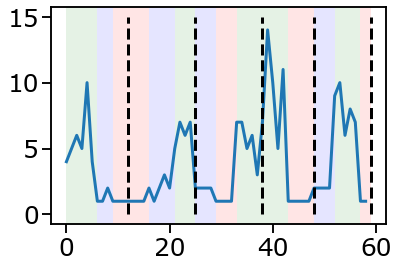

In [66]:
cond_num = 5
total_treasure,prts,planet_vis=_sim(cond_num )

condition = dc.condition_type(cond_num )

exp_struc, rho_0,decay = dc.load_data(condition)


plt.plot(dc.flatten_list(prts))
plt.plot([len(prts[0]),len(prts[0])],[0,15],'k--')
plt.plot([len(prts[1])+len(prts[0]),len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[2])+len(prts[1])+len(prts[0]),len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0]),len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[4])+len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0]),len(prts[4])+len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')

for block in range(5):
    for planet in range(len(prts[block])):
        planet_num = planet + sum([planet_vis[i][-1] + 1 for i in range(block)])
        galaxy = dc.flatten_list(exp_struc[block])[planet]
        if galaxy == 0:
            plt.axvspan(planet_num, planet_num+1, facecolor='r', alpha=0.1)
        elif galaxy == 1:
            plt.axvspan(planet_num, planet_num+1, facecolor='b', alpha=0.1)
        elif galaxy == 2:
            plt.axvspan(planet_num, planet_num+1, facecolor='g', alpha=0.1)
print(prts)

global_rr: 12.723927804992604
global_rr: 11.73231708533215
global_rr: 11.005206818909883
global_rr: 11.33484348292873
global_rr: 11.385564853483903
[[4, 8, 2, 3, 7, 5, 1, 1, 1, 9], [1, 1, 1, 1, 6, 6, 5, 7, 9, 2, 2, 2], [2, 2, 2, 2, 1, 1, 1, 1, 7, 7, 5, 6, 3], [7, 14, 10, 4, 11, 1, 1, 1, 1, 1], [2, 2, 2, 2, 9, 10, 6, 7, 7, 1, 1]]


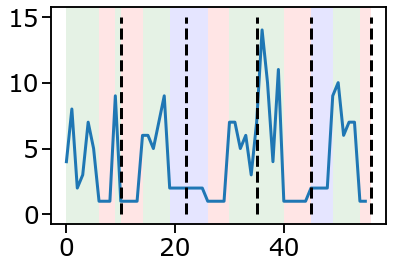

In [67]:
cond_num = 6
total_treasure,prts,planet_vis=_sim(cond_num )

condition = dc.condition_type(cond_num )

exp_struc, rho_0,decay = dc.load_data(condition)


plt.plot(dc.flatten_list(prts))
plt.plot([len(prts[0]),len(prts[0])],[0,15],'k--')
plt.plot([len(prts[1])+len(prts[0]),len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[2])+len(prts[1])+len(prts[0]),len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0]),len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')
plt.plot([len(prts[4])+len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0]),len(prts[4])+len(prts[3])+len(prts[2])+len(prts[1])+len(prts[0])],[0,15],'k--')

for block in range(5):
    for planet in range(len(prts[block])):
        planet_num = planet + sum([planet_vis[i][-1] + 1 for i in range(block)])
        galaxy = dc.flatten_list(exp_struc[block])[planet]
        if galaxy == 0:
            plt.axvspan(planet_num, planet_num+1, facecolor='r', alpha=0.1)
        elif galaxy == 1:
            plt.axvspan(planet_num, planet_num+1, facecolor='b', alpha=0.1)
        elif galaxy == 2:
            plt.axvspan(planet_num, planet_num+1, facecolor='g', alpha=0.1)
print(prts)

# bayesian

In [272]:
import pymc3 as pm
group1 = avgd_data_post.query("condition==5").prt_rel_mvt.tolist()
group2 = avgd_data_post.query("condition==6").prt_rel_mvt.tolist()
pooled = np.concatenate((group1,group2))


In [273]:
μ_m = pooled.mean()
μ_s = pooled.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', mu=μ_m, sd=μ_s)

σ_low = pooled.std()/1000
σ_high = pooled.std()*1000

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)
    

with model:
    ν = pm.Exponential('ν_minus_one', 1/ 1/29.) + 1
    
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=group1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=group2)

In [274]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:15<00:00, 330.38draws/s]


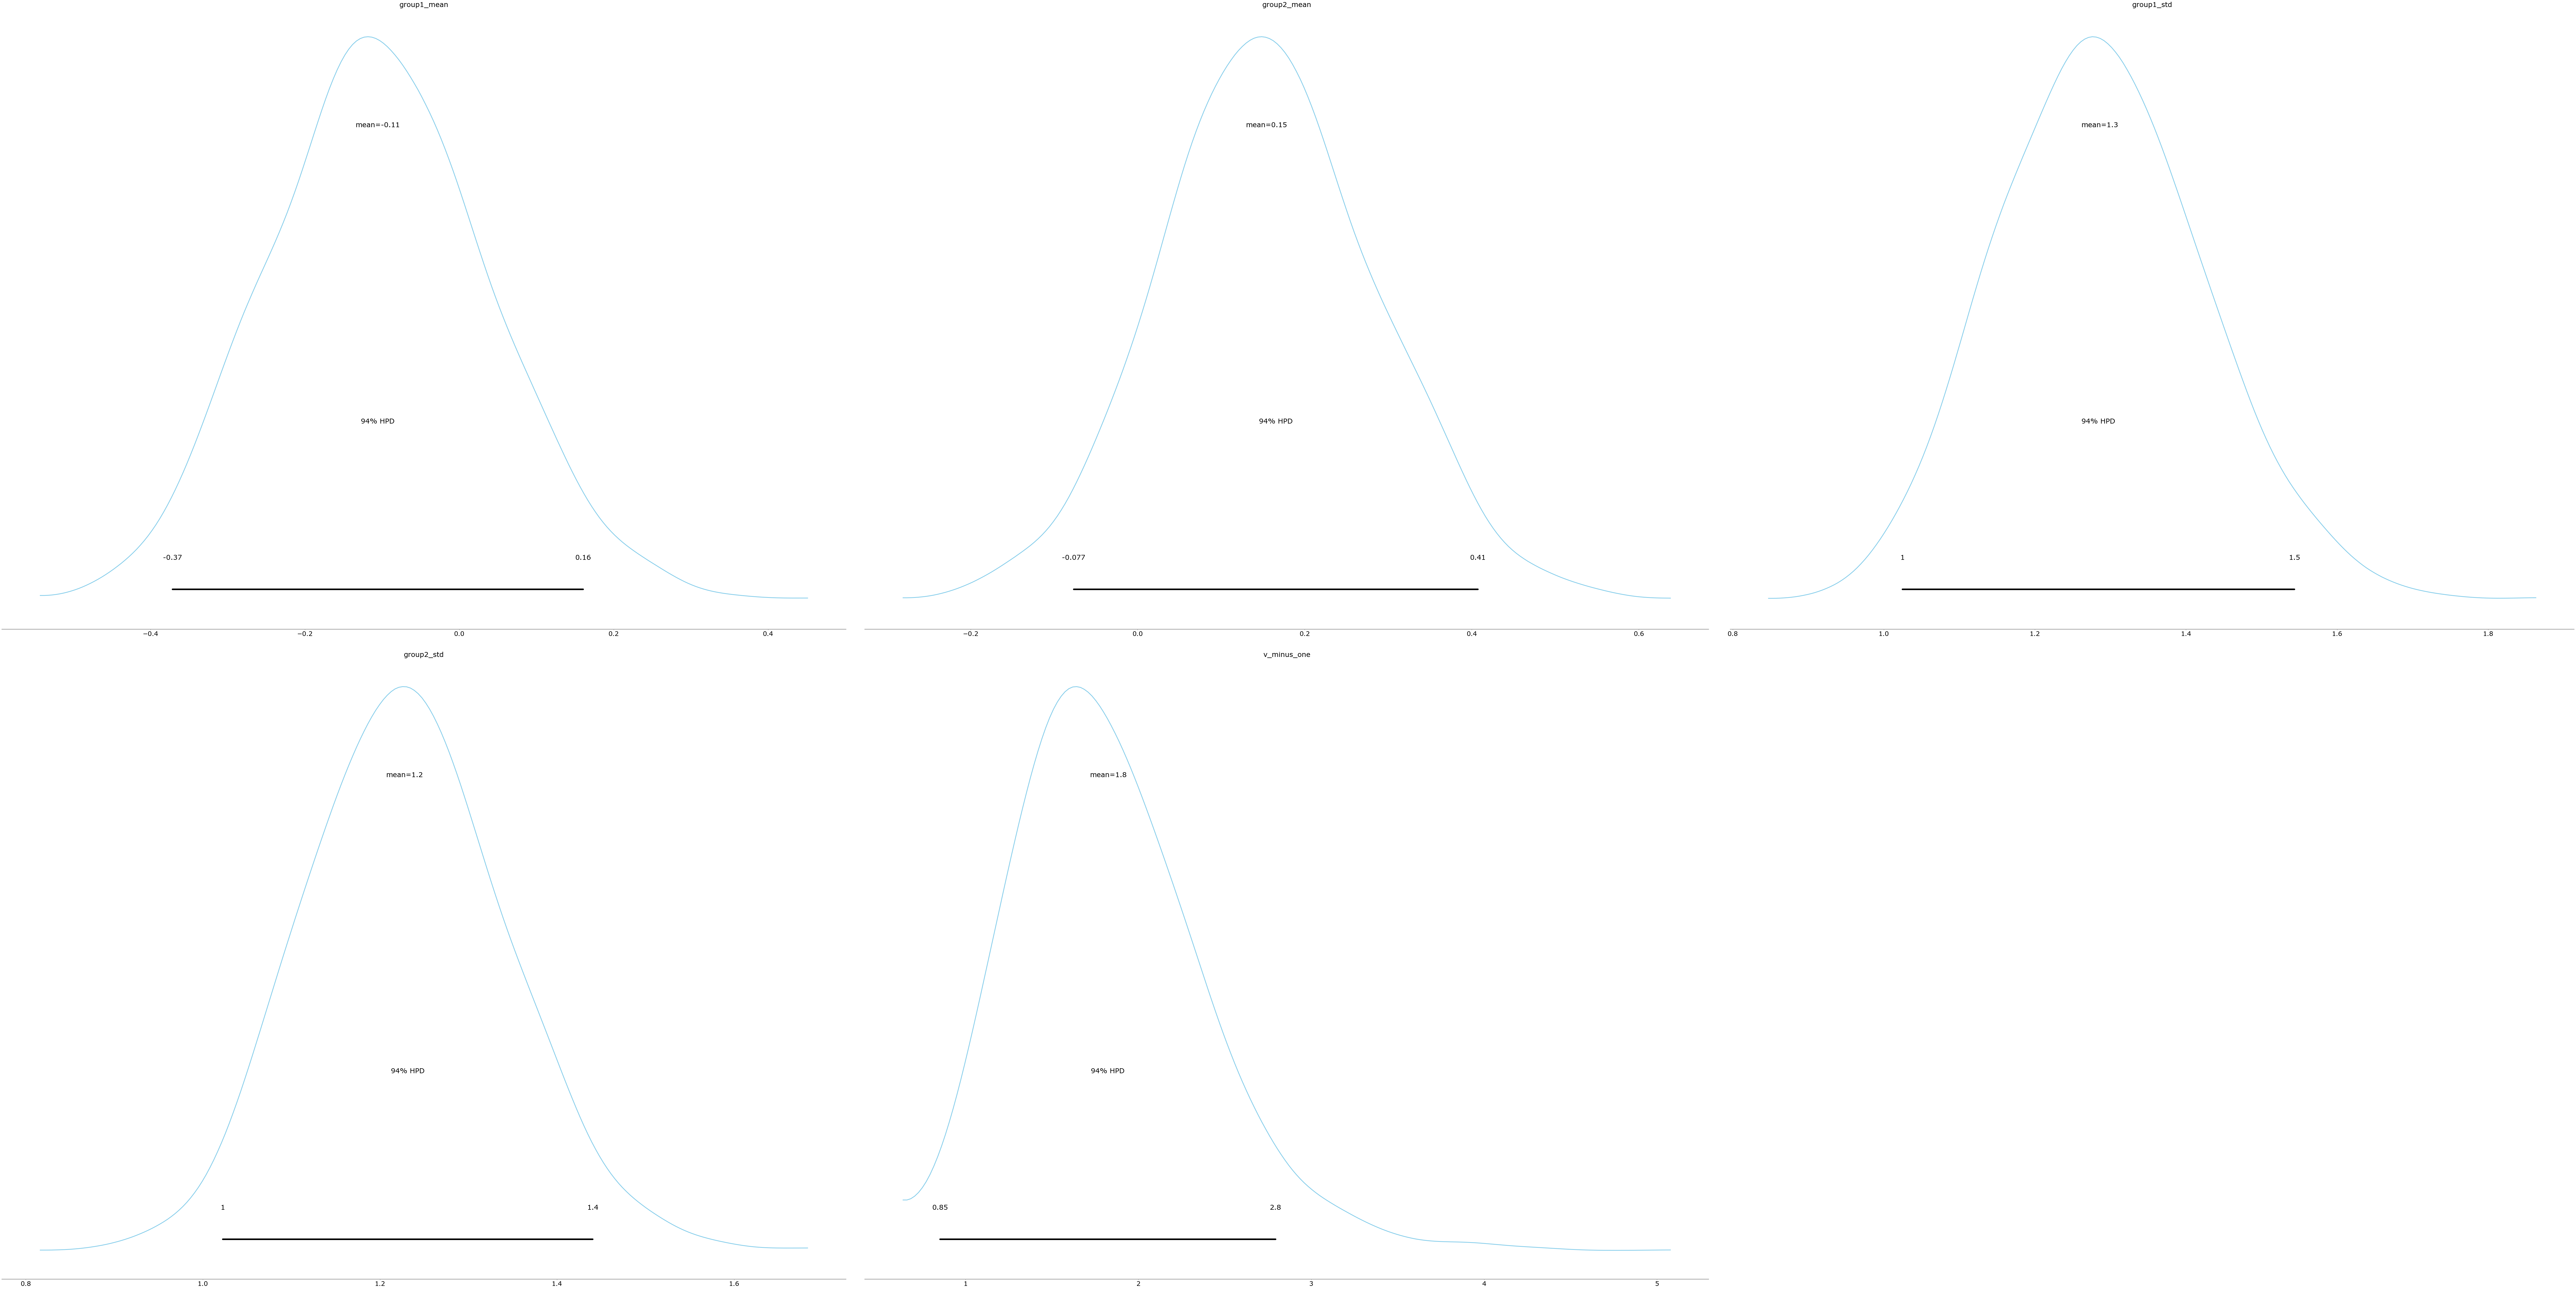

In [275]:

pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

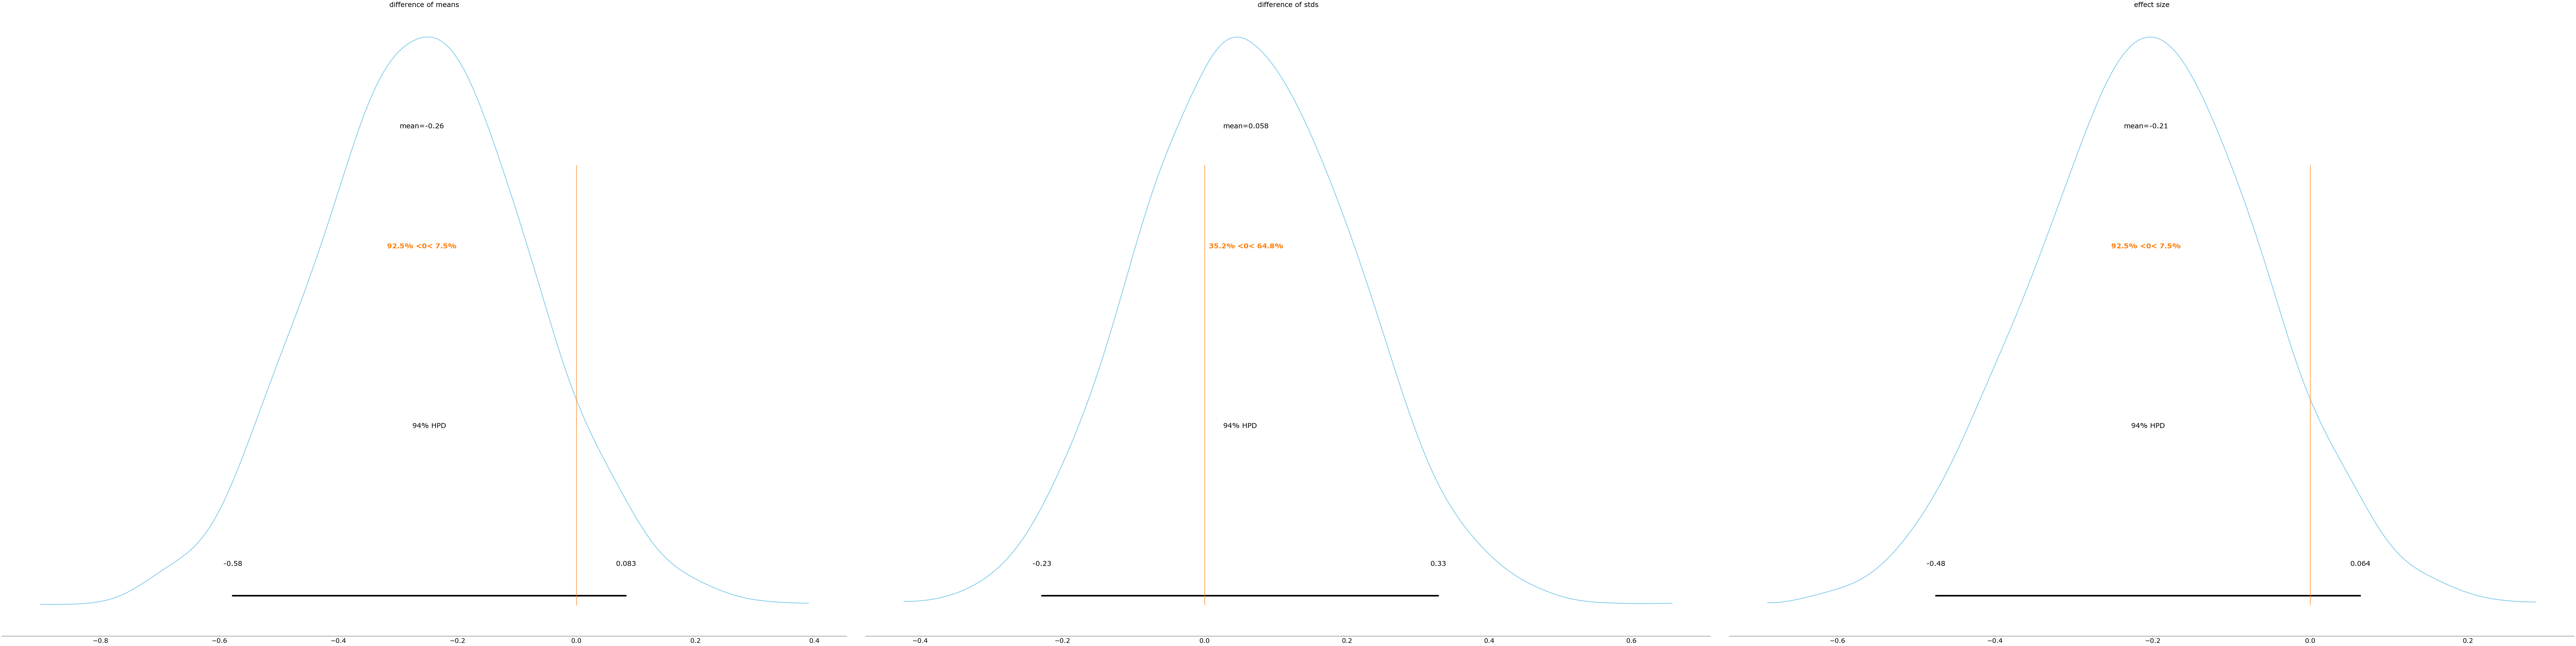

In [276]:

pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

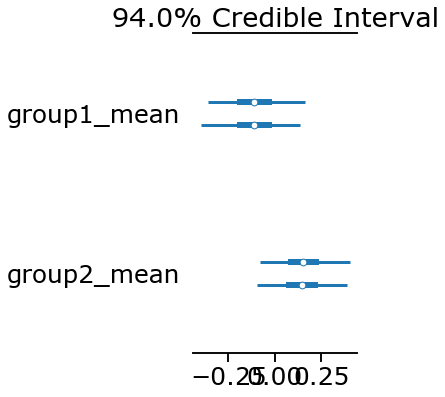

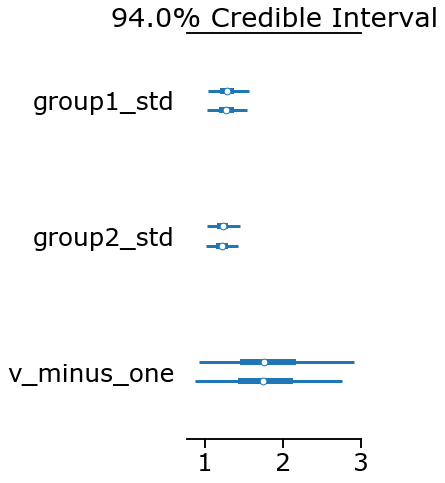

In [277]:

pm.forestplot(trace, var_names=['group1_mean',
                                'group2_mean']);
pm.forestplot(trace, var_names=['group1_std',
                               'group2_std',
                               'ν_minus_one']);

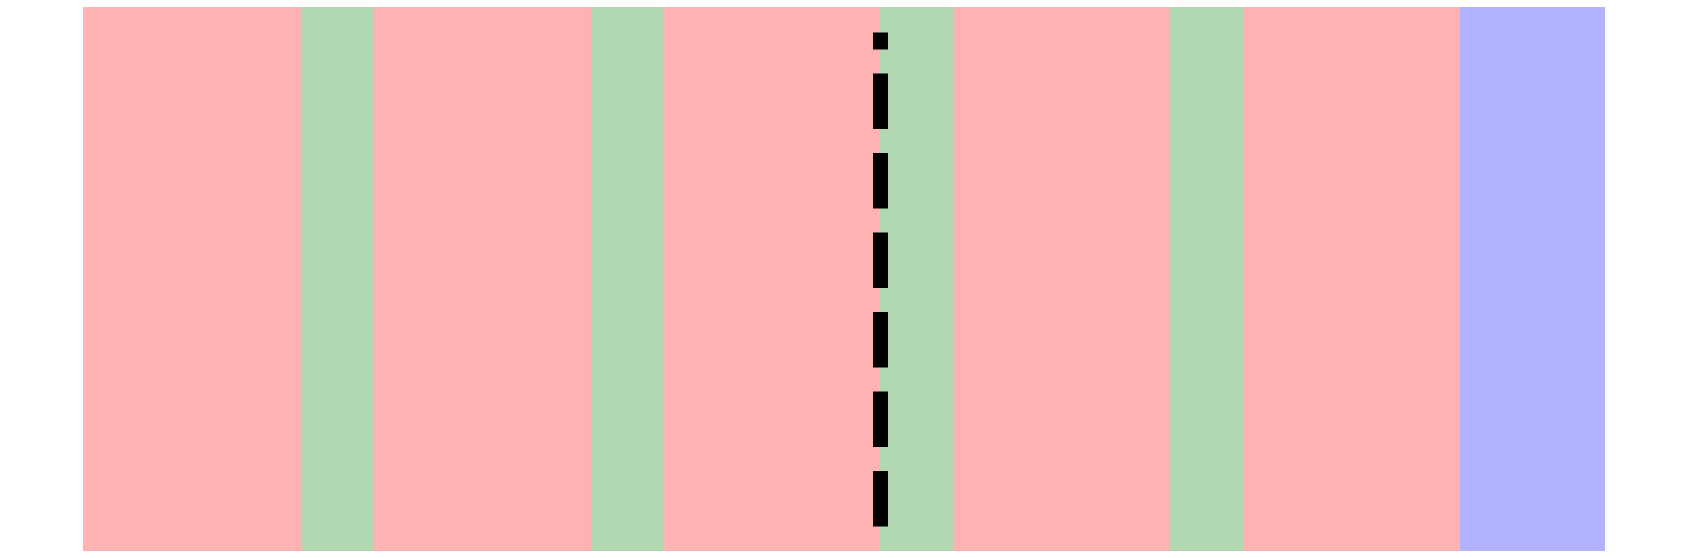

In [367]:
plt.rcParams["figure.figsize"] = (30,10)


plt.axvspan(0,3,facecolor='r', alpha=0.3)
plt.axvspan(3,4,facecolor='g', alpha=0.3)
plt.axvspan(4,7,facecolor='r', alpha=0.3)
plt.axvspan(7,8,facecolor='g', alpha=0.3)
plt.axvspan(8,11,facecolor='r', alpha=0.3)

plt.axvspan(11,12,facecolor='g', alpha=0.3)
plt.axvspan(12,15,facecolor='r', alpha=0.3)
plt.axvspan(15,16,facecolor='g', alpha=0.3)
plt.axvspan(16,19,facecolor='r', alpha=0.3)
plt.axvspan(19,21,facecolor='b', alpha=0.3)

plt.plot([11,11],[0,1],'k--',linewidth=15)
sns.despine(top=True,right=True,bottom=True,left=True)
plt.xticks([])
plt.yticks([])

plt.savefig("plots/exp_struc_poor_extreme_ex.png")

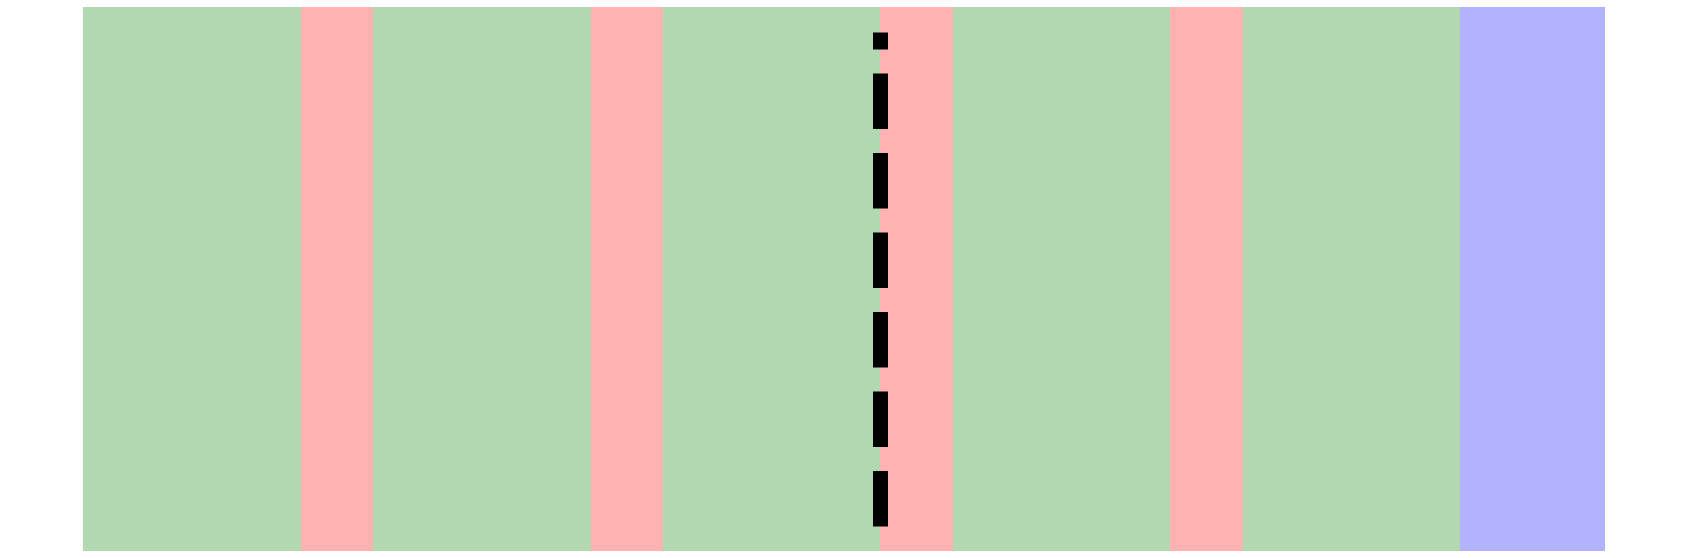

In [368]:
plt.rcParams["figure.figsize"] = (30,10)


plt.axvspan(0,3,facecolor='g', alpha=0.3)
plt.axvspan(3,4,facecolor='r', alpha=0.3)
plt.axvspan(4,7,facecolor='g', alpha=0.3)
plt.axvspan(7,8,facecolor='r', alpha=0.3)
plt.axvspan(8,11,facecolor='g', alpha=0.3)

plt.axvspan(11,12,facecolor='r', alpha=0.3)
plt.axvspan(12,15,facecolor='g', alpha=0.3)
plt.axvspan(15,16,facecolor='r', alpha=0.3)
plt.axvspan(16,19,facecolor='g', alpha=0.3)
plt.axvspan(19,21,facecolor='b', alpha=0.3)

plt.plot([11,11],[0,1],'k--',linewidth=15)
sns.despine(top=True,right=True,bottom=True,left=True)
plt.xticks([])
plt.yticks([])


plt.savefig("plots/exp_struc_rich_extreme_ex.png")

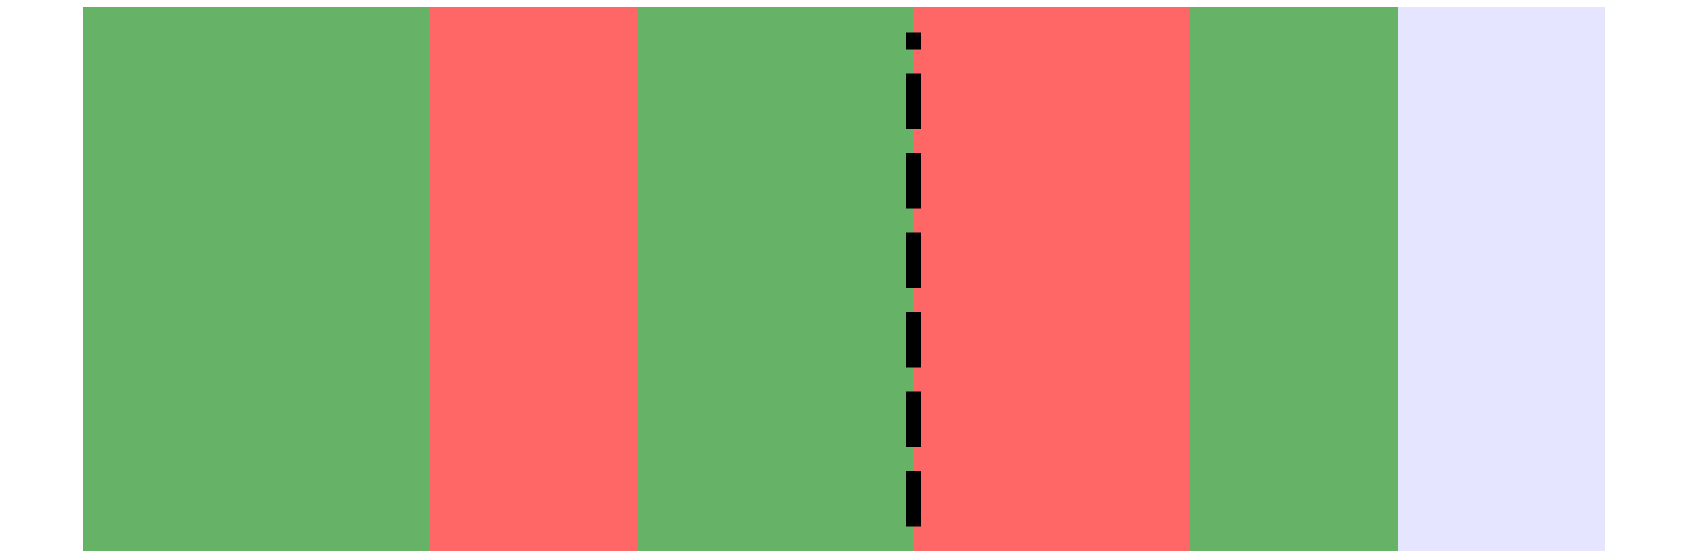

In [234]:
plt.rcParams["figure.figsize"] = (30,10)


plt.axvspan(0,5,facecolor='g', alpha=0.6)
plt.axvspan(5,8,facecolor='r', alpha=0.6)
plt.axvspan(8,12,facecolor='g', alpha=0.6)
plt.axvspan(12,16,facecolor='r', alpha=0.6)
plt.axvspan(16,19,facecolor='g', alpha=0.6)
plt.axvspan(19,22,facecolor='b', alpha=0.1)

plt.plot([12,12],[0,1],'k--',linewidth=15)
sns.despine(top=True,right=True,bottom=True,left=True)
plt.xticks([])
plt.yticks([])

plt.savefig("plots/exp_struc_rich_extreme_ex.png")

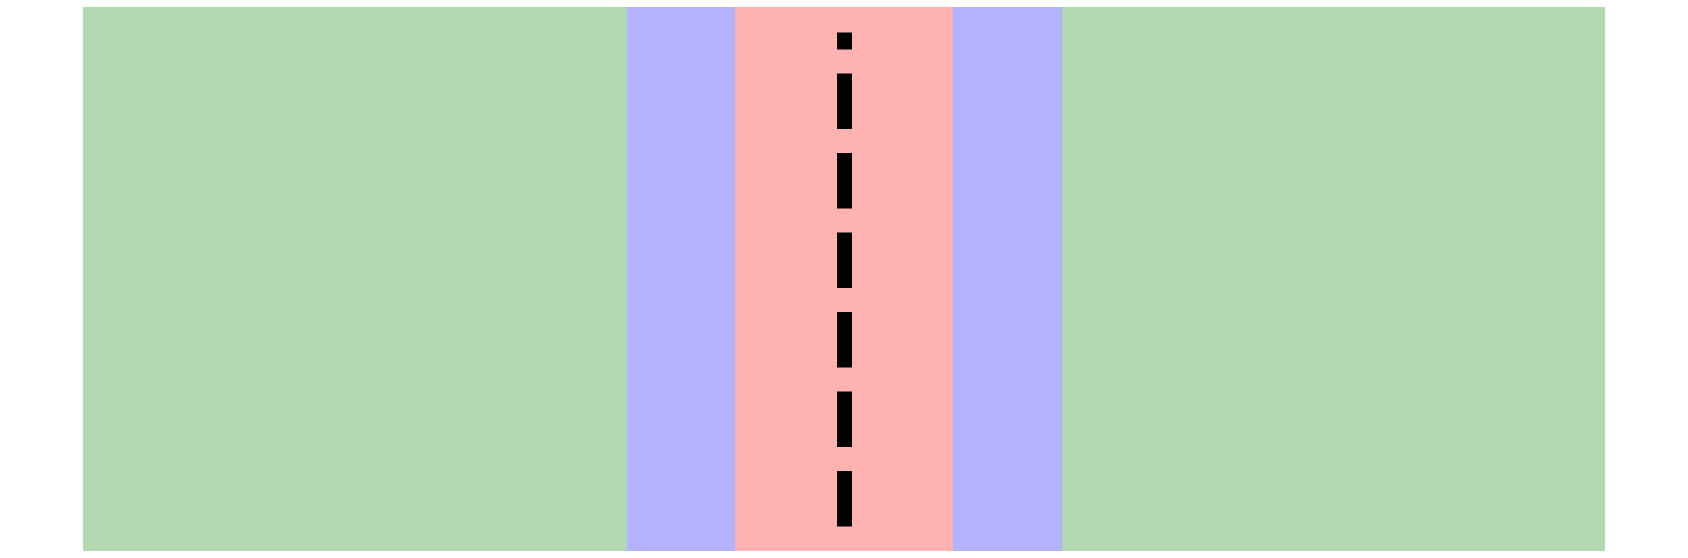

In [326]:
plt.rcParams["figure.figsize"] = (30,10)


plt.axvspan(0,5,facecolor='g', alpha=0.3)
plt.axvspan(5,6,facecolor='b', alpha=0.3)
plt.axvspan(6,7,facecolor='r', alpha=0.3)
plt.axvspan(7,8,facecolor='r', alpha=0.3)
plt.axvspan(8,9,facecolor='b', alpha=0.3)
plt.axvspan(9,14,facecolor='g', alpha=0.3)

plt.plot([7,7],[0,1],'k--',linewidth=15)
sns.despine(top=True,right=True,bottom=True,left=True)
plt.xticks([])
plt.yticks([])

plt.savefig("plots/exp_struc_rich_graded_ex.png")

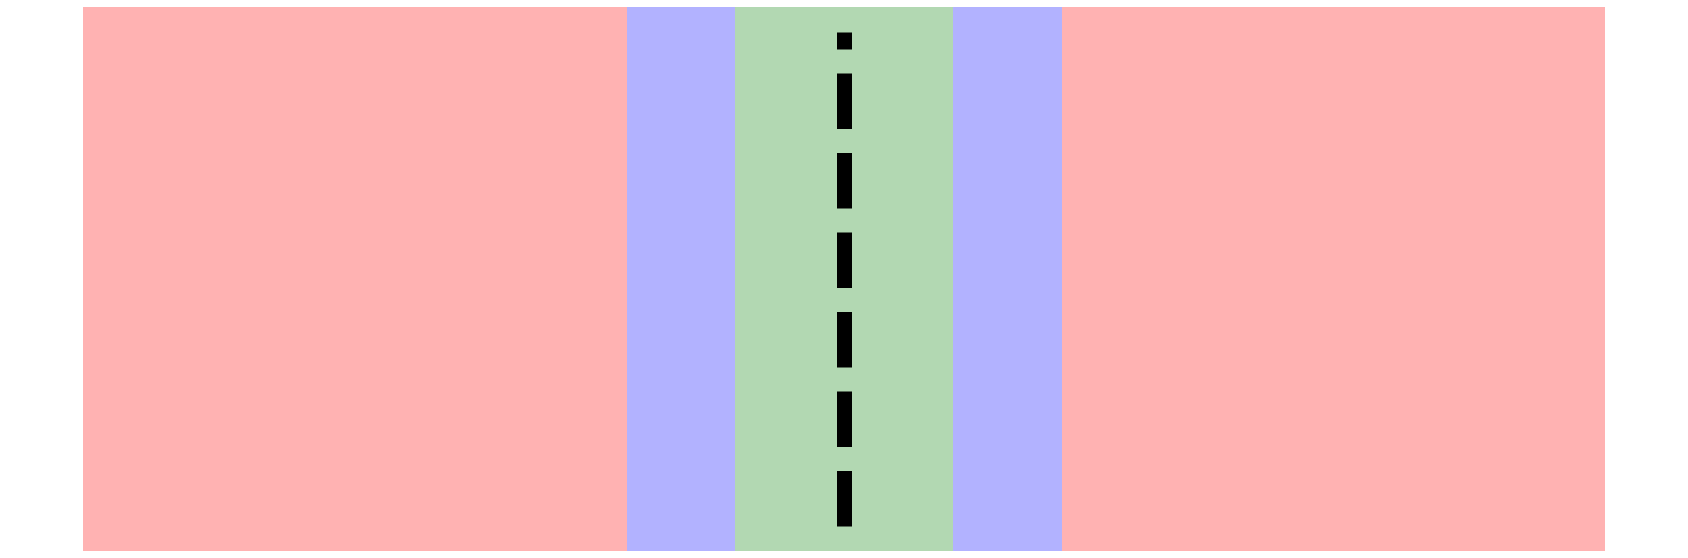

In [325]:
plt.axvspan(0,5,facecolor='r', alpha=0.3)
plt.axvspan(5,6,facecolor='b', alpha=0.3)
plt.axvspan(6,7,facecolor='g', alpha=0.3)
plt.axvspan(7,8,facecolor='g', alpha=0.3)
plt.axvspan(8,9,facecolor='b', alpha=0.3)
plt.axvspan(9,14,facecolor='r', alpha=0.3)

plt.plot([7,7],[0,1],'k--',linewidth=15)
sns.despine(top=True,right=True,bottom=True,left=True)
plt.xticks([])
plt.yticks([])

plt.savefig("plots/exp_struc_poor_graded_ex.png")

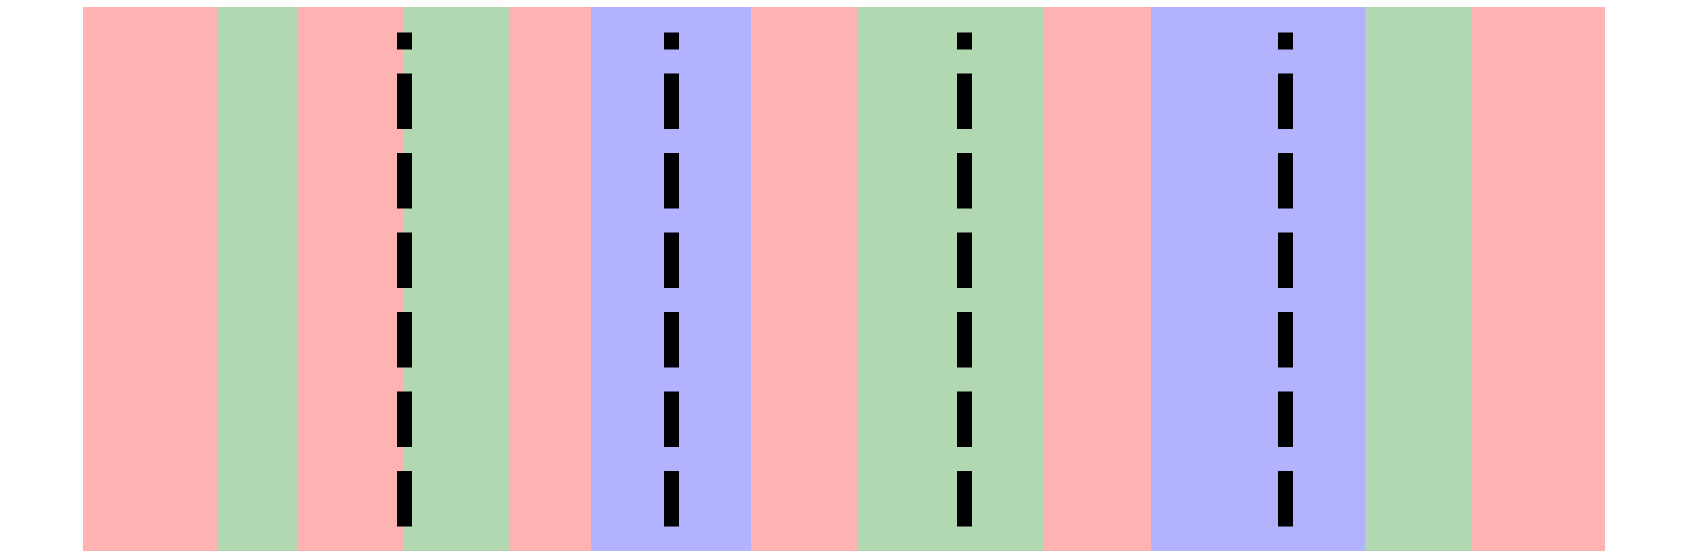

In [190]:
plt.rcParams["figure.figsize"] = (30,10)


plt.axvspan(0,5,facecolor='r', alpha=0.3)
plt.axvspan(5,8,facecolor='g', alpha=0.3)
plt.axvspan(8,12,facecolor='r', alpha=0.3)

plt.axvspan(12,16,facecolor='g', alpha=0.3)
plt.axvspan(16,19,facecolor='r', alpha=0.3)
plt.axvspan(19,22,facecolor='b', alpha=0.3)

plt.axvspan(22,25,facecolor='b', alpha=0.3)
plt.axvspan(25,29,facecolor='r', alpha=0.3)
plt.axvspan(29,33,facecolor='g', alpha=0.3)

plt.axvspan(33,36,facecolor='g', alpha=0.3)
plt.axvspan(36,40,facecolor='r', alpha=0.3)
plt.axvspan(40,45,facecolor='b', alpha=0.3)

plt.axvspan(45,48,facecolor='b', alpha=0.3)
plt.axvspan(48,52,facecolor='g', alpha=0.3)
plt.axvspan(52,57,facecolor='r', alpha=0.3)

plt.plot([12,12],[0,1],'k--',linewidth=15)
plt.plot([22,22],[0,1],'k--',linewidth=15)
plt.plot([33,33],[0,1],'k--',linewidth=15)
plt.plot([45,45],[0,1],'k--',linewidth=15)



sns.despine(top=True,right=True,bottom=True,left=True)
plt.xticks([])
plt.yticks([])

plt.savefig("plots/whole.png")

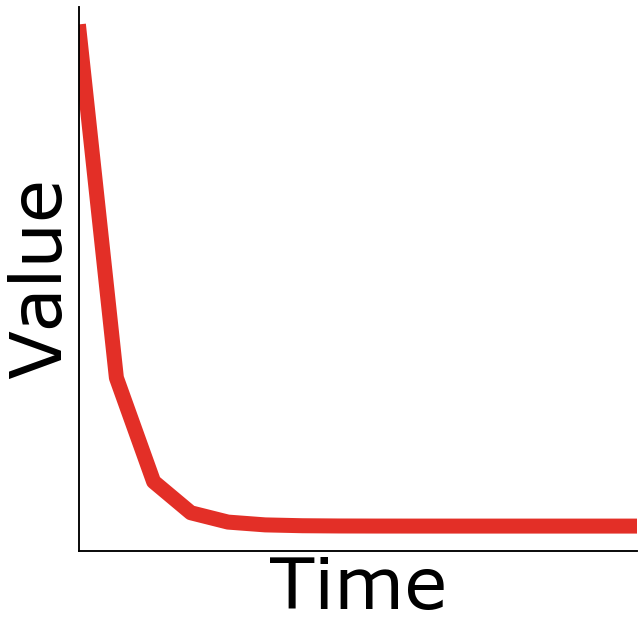

In [360]:
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context('talk',font_scale=4)

x = range(100)
y = [1*((0.3)**(i)) for i in x]

plt.plot(x,y,linewidth=15,color=pal[0])
plt.xlim([0,15])
sns.despine(right=True,top=True)
plt.ylabel('Value')
plt.yticks([])
plt.xlabel('Time')
plt.xticks([])

plt.savefig("plots/poor.png")

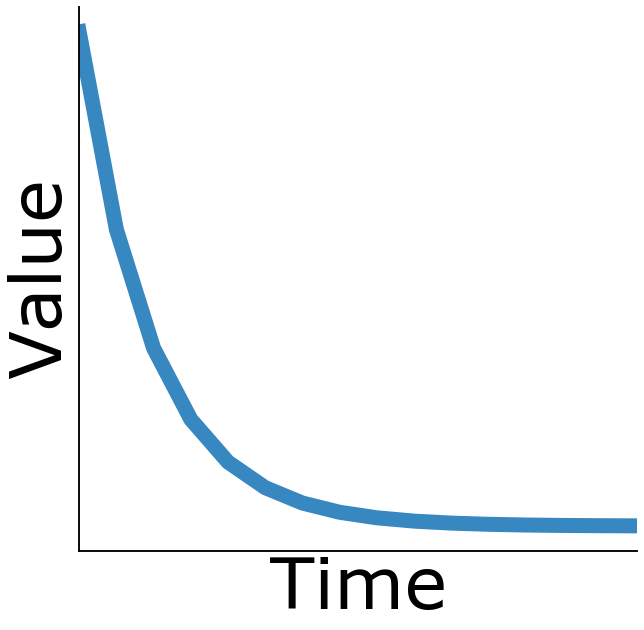

In [361]:

x = range(100)
y = [1*((0.6)**(i)) for i in x]

plt.plot(x,y,linewidth=15,color= sns.color_palette("Blues_r", 2)[0])
plt.xlim([0,15])
sns.despine(right=True,top=True)
plt.ylabel('Value')
plt.yticks([])
plt.xlabel('Time')
plt.xticks([])

plt.savefig("plots/neutral.png")

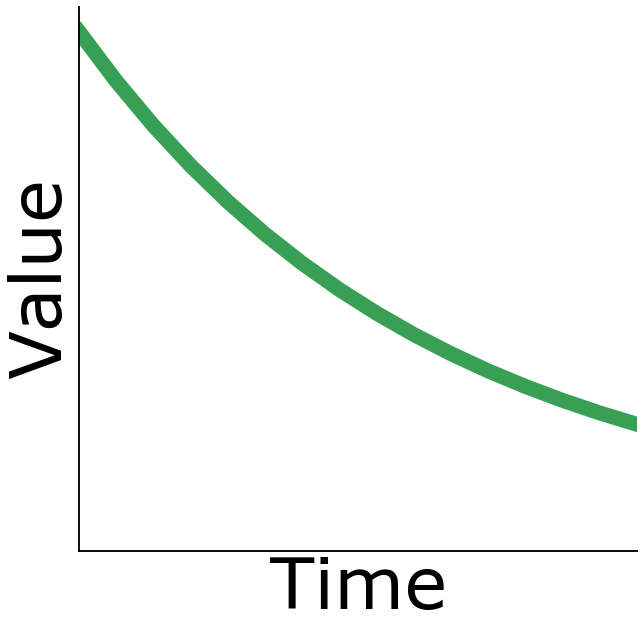

In [362]:

x = range(100)
y = [1*((0.9)**(i)) for i in x]

plt.plot(x,y,linewidth=15,color= pal[2])
plt.xlim([0,15])
sns.despine(right=True,top=True)
plt.ylabel('Value')
plt.yticks([])
plt.xlabel('Time')
plt.xticks([])

plt.savefig("plots/rich.png")

In [16]:
avgd_data_post.groupby("condition").prt_rel_mvt.mean().reset_index(drop=False).to_csv("fit_plot_condition_average.csv")

# sim for determining travel time

In [1]:
import sim 
import pandas as pd
import seaborn as sns

def run_sim(cond_num):
    total_treasure,prts = sim.sim(cond_num)

    block_n_planets = [len(x) for x in prts] 
    exp_struc, rho_0, all_decay = sim.load_data(sim.condition_type(cond_num))
    exp_struc = [sim.flatten_list(x) for x in exp_struc]
    exp_planets = [exp_struc[i][:block_n_planets[i]] for i in range(5)]
    
    post_prts = prts[2:]
    exp_planets = exp_planets[2:]

    exp_planets = sim.flatten_list(exp_planets)
    exp_struc = sim.flatten_list(exp_struc)

    df = pd.DataFrame({'condition':[cond_num]*len(exp_planets),'galaxy':exp_planets,'prt':sim.flatten_list(post_prts)})

    return df

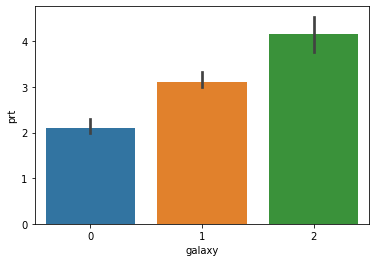

In [2]:
df_1 = run_sim(1)
sns.barplot(x='galaxy',y='prt',data=df_1)

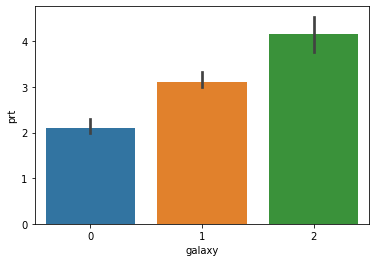

In [3]:
df_2 = run_sim(2)
sns.barplot(x='galaxy',y='prt',data=df_2)

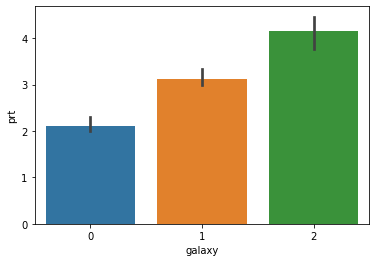

In [4]:
df_5 = run_sim(5)
sns.barplot(x='galaxy',y='prt',data=df_5)

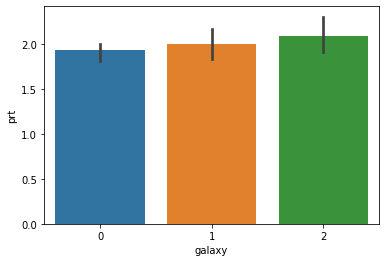

In [5]:
df_6 = run_sim(6)
sns.barplot(x='galaxy',y='prt',data=df_6)